##### Copyright 2019 The TensorFlow Authors.

In [1]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# 시계열 예측

<table class="tfo-notebook-buttons" align="left">
  <td>     <a target="_blank" href="https://www.tensorflow.org/tutorials/structured_data/time_series"><img src="https://www.tensorflow.org/images/tf_logo_32px.png"> TensorFlow.org에서 보기</a> </td>
  <td>     <a target="_blank" href="https://colab.research.google.com/github/tensorflow/docs-l10n/blob/master/site/ko/tutorials/structured_data/time_series.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png">Google Colab에서 실행</a>   </td>
  <td><a target="_blank" href="https://github.com/tensorflow/docs-l10n/blob/master/site/ko/tutorials/structured_data/time_series.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png">GitHub에서소스 보기</a></td>
  <td><a href="https://storage.googleapis.com/tensorflow_docs/docs-l10n/site/ko/tutorials/structured_data/time_series.ipynb"><img src="https://www.tensorflow.org/images/download_logo_32px.png">노트북 다운로드</a></td>
</table>

이 튜토리얼에서는 TensorFlow를 사용한 시계열 예측을 소개합니다. Convolutional/Recurrent Neural Network(CNN 및 RNN)를 포함하여 몇 가지 다른 스타일의 모델을 빌드합니다.

이 내용은 각각 하위 항목이 있는 두 부분으로 나누어 생각합니다.

- 단일 타임스텝 예측:
    - 단일 특성
    - 모든 특성
- 다중 스텝 예측:
    - 싱글샷: 모두 한 번에 예측합니다.
    - 자가 회귀: 한 번에 하나의 예측을 수행하고 결과를 모델로 피드백합니다.

## 설정

In [2]:
import os
import datetime

import IPython
import IPython.display
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf

mpl.rcParams['figure.figsize'] = (8, 6)
mpl.rcParams['axes.grid'] = False

2022-12-14 22:54:50.306096: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2022-12-14 22:54:50.306217: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory
2022-12-14 22:54:50.306228: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Cannot dlopen some TensorRT libraries. If you would like to use Nvidia GPU with TensorRT, please make sure the missing libraries mentioned above are installed properly.


## 날씨 데이터세트

이 튜토리얼은 <a class="external" href="https://www.bgc-jena.mpg.de/wetter/">막스 플랑크 생물 지구화학 연구소</a>에서 기록한 <a class="external" href="https://www.bgc-jena.mpg.de">날씨 시계열 데이터세트</a>를 사용합니다.

이 데이터세트에는 온도, 대기압 및 습도와 같은 14가지 특성이 있습니다. 이러한 데이터는 2003년부터 시작해 10분 간격으로 수집되었습니다. 효율성을 위해 2009년과 2016년 사이에 수집된 데이터만 사용하겠습니다. 이 데이터세트 부분은 François Chollet이 자신이 저술한 책 [Deep Learning with Python](https://www.manning.com/books/deep-learning-with-python)을 위해 준비했습니다.

In [3]:
zip_path = tf.keras.utils.get_file(
    origin='https://storage.googleapis.com/tensorflow/tf-keras-datasets/jena_climate_2009_2016.csv.zip',
    fname='jena_climate_2009_2016.csv.zip',
    extract=True)
csv_path, _ = os.path.splitext(zip_path)

    8192/13568290 [..............................] - ETA: 0s

 4202496/13568290 [========>.....................] - ETA: 0s

13279232/13568290 [============================>.] - ETA: 0s

13568290/13568290 [==============================] - 0s 0us/step


이 튜토리얼은 **시간별 예측**만 다루므로 10분 간격부터 1시간까지 데이터를 서브 샘플링하는 것으로 시작합니다.

In [4]:
df = pd.read_csv(csv_path)
# Slice [start:stop:step], starting from index 5 take every 6th record.
df = df[5::6]

date_time = pd.to_datetime(df.pop('Date Time'), format='%d.%m.%Y %H:%M:%S')

데이터를 살펴보겠습니다. 다음은 처음 몇 개의 행입니다.

In [5]:
df.head()

,p (mbar),T (degC),Tpot (K),Tdew (degC),rh (%),VPmax (mbar),VPact (mbar),VPdef (mbar),sh (g/kg),H2OC (mmol/mol),rho (g/m**3),wv (m/s),max. wv (m/s),wd (deg)
5,996.50,-8.05,265.38,-8.78,94.4,3.33,3.14,0.19,1.96,3.15,1307.86,0.21,0.63,192.7
11,996.62,-8.88,264.54,-9.77,93.2,3.12,2.90,0.21,1.81,2.91,1312.25,0.25,0.63,190.3
17,996.84,-8.81,264.59,-9.66,93.5,3.13,2.93,0.20,1.83,2.94,1312.18,0.18,0.63,167.2
23,996.99,-9.05,264.34,-10.02,92.6,3.07,2.85,0.23,1.78,2.85,1313.61,0.10,0.38,240.0
29,997.46,-9.63,263.72,-10.65,92.2,2.94,2.71,0.23,1.69,2.71,1317.19,0.40,0.88,157.0


시간이 지남에 따른 몇 가지 특성의 전개 양상은 다음과 같습니다.

/tmpfs/tmp/ipykernel_750642/637349053.py:7: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  plot_features.index = date_time[:480]


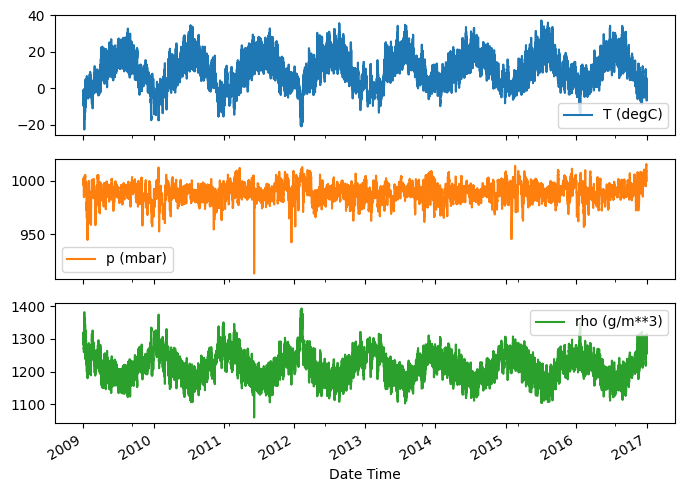

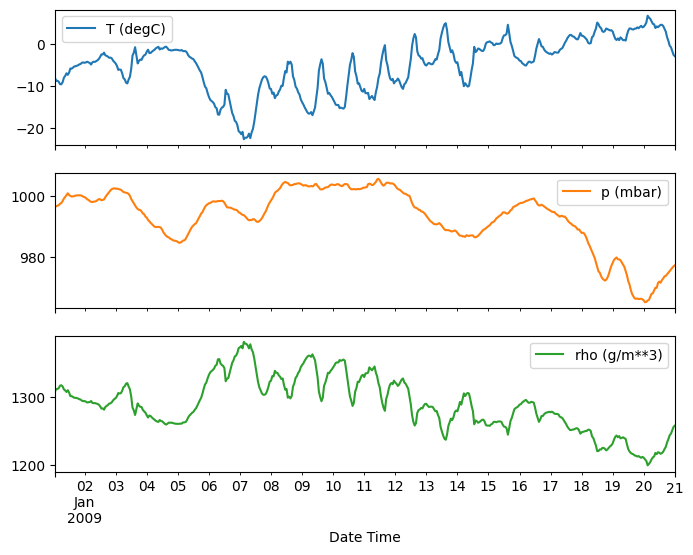

In [6]:
plot_cols = ['T (degC)', 'p (mbar)', 'rho (g/m**3)']
plot_features = df[plot_cols]
plot_features.index = date_time
_ = plot_features.plot(subplots=True)

plot_features = df[plot_cols][:480]
plot_features.index = date_time[:480]
_ = plot_features.plot(subplots=True)

### 검사 및 정리하기

다음으로 데이터세트의 통계를 살펴봅니다.

In [7]:
df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
p (mbar),70091.0,989.212842,8.358886,913.60,984.20,989.57,994.720,1015.29
T (degC),70091.0,9.450482,8.423384,-22.76,3.35,9.41,15.480,37.28
Tpot (K),70091.0,283.493086,8.504424,250.85,277.44,283.46,289.530,311.21
Tdew (degC),70091.0,4.956471,6.730081,-24.80,0.24,5.21,10.080,23.06
rh (%),70091.0,76.009788,16.474920,13.88,65.21,79.30,89.400,100.00
VPmax (mbar),70091.0,13.576576,7.739883,0.97,7.77,11.82,17.610,63.77
VPact (mbar),70091.0,9.533968,4.183658,0.81,6.22,8.86,12.360,28.25
VPdef (mbar),70091.0,4.042536,4.898549,0.00,0.87,2.19,5.300,46.01
sh (g/kg),70091.0,6.022560,2.655812,0.51,3.92,5.59,7.800,18.07
H2OC (mmol/mol),70091.0,9.640437,4.234862,0.81,6.29,8.96,12.490,28.74


#### 풍속

한 가지 눈에 띄는 점은 풍속(`wv (m/s)`)의 `min` 값과 최댓값(`max. wv (m/s)`) 열입니다. `-9999`는 오류일 수 있습니다.

별도의 풍향 열이 있으므로 속도는 0보다 커야 합니다({code 0}&gt;=0{/code 0}). 0으로 교체합니다.

In [8]:
wv = df['wv (m/s)']
bad_wv = wv == -9999.0
wv[bad_wv] = 0.0

max_wv = df['max. wv (m/s)']
bad_max_wv = max_wv == -9999.0
max_wv[bad_max_wv] = 0.0

# The above inplace edits are reflected in the DataFrame.
df['wv (m/s)'].min()

0.0

### 특성 엔지니어링

모델을 구축하기 전에 데이터를 이해하고 모델에 적절한 형식의 데이터를 전달하고 있는지 확인하는 것이 중요합니다.

#### 바람

데이터의 마지막 열인 `wd (deg)` - 바람의 방향을 도 단위로 제공합니다. 각도는 좋은 모델 입력을 만들지 않습니다. 360°와 0°는 서로 가깝고 부드럽게 둘러싸야 합니다. 바람이 불지 않으면 방향은 중요하지 않습니다.

현재, 바람 데이터의 분포는 다음과 같습니다.

Text(0, 0.5, 'Wind Velocity [m/s]')

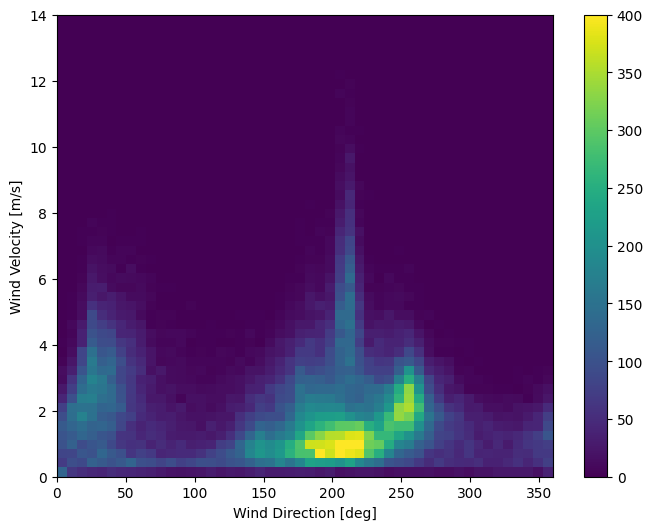

In [9]:
plt.hist2d(df['wd (deg)'], df['wv (m/s)'], bins=(50, 50), vmax=400)
plt.colorbar()
plt.xlabel('Wind Direction [deg]')
plt.ylabel('Wind Velocity [m/s]')

그러나 풍향과 속도 열을 바람 **벡터**로 변환하면 모델이 해석하기가 더 쉽습니다.

In [10]:
wv = df.pop('wv (m/s)')
max_wv = df.pop('max. wv (m/s)')

# Convert to radians.
wd_rad = df.pop('wd (deg)')*np.pi / 180

# Calculate the wind x and y components.
df['Wx'] = wv*np.cos(wd_rad)
df['Wy'] = wv*np.sin(wd_rad)

# Calculate the max wind x and y components.
df['max Wx'] = max_wv*np.cos(wd_rad)
df['max Wy'] = max_wv*np.sin(wd_rad)

바람 벡터의 분포는 모델이 올바르게 해석하는 데 훨씬 간단합니다.

(-11.305513973134667, 8.24469928549079, -8.27438540335515, 7.7338312955467785)

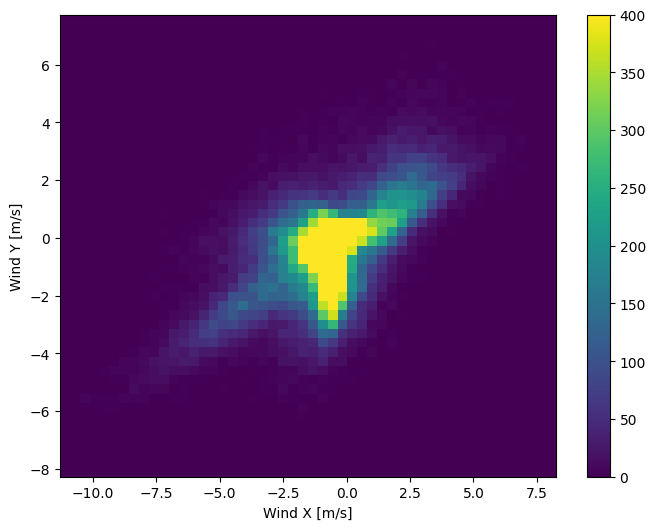

In [11]:
plt.hist2d(df['Wx'], df['Wy'], bins=(50, 50), vmax=400)
plt.colorbar()
plt.xlabel('Wind X [m/s]')
plt.ylabel('Wind Y [m/s]')
ax = plt.gca()
ax.axis('tight')

#### 시간

마찬가지로 `Date Time` 열은 매우 유용하지만 이 문자열 형식은 아닙니다. 초로 변환하여 시작하십시오.

In [12]:
timestamp_s = date_time.map(pd.Timestamp.timestamp)

풍향과 유사하게 초 단위의 시간은 유용한 모델 입력이 아닙니다. 날씨 데이터이기 때문에 일별 및 연간 주기가 명확합니다. 주기성을 다룰 수 있는 방법은 여러 가지가 있습니다.

사인 및 코사인 변환을 사용하여 "시간" 및 "시간" 신호를 지우면 사용 가능한 신호를 얻을 수 있습니다.

In [13]:
day = 24*60*60
year = (365.2425)*day

df['Day sin'] = np.sin(timestamp_s * (2 * np.pi / day))
df['Day cos'] = np.cos(timestamp_s * (2 * np.pi / day))
df['Year sin'] = np.sin(timestamp_s * (2 * np.pi / year))
df['Year cos'] = np.cos(timestamp_s * (2 * np.pi / year))

Text(0.5, 1.0, 'Time of day signal')

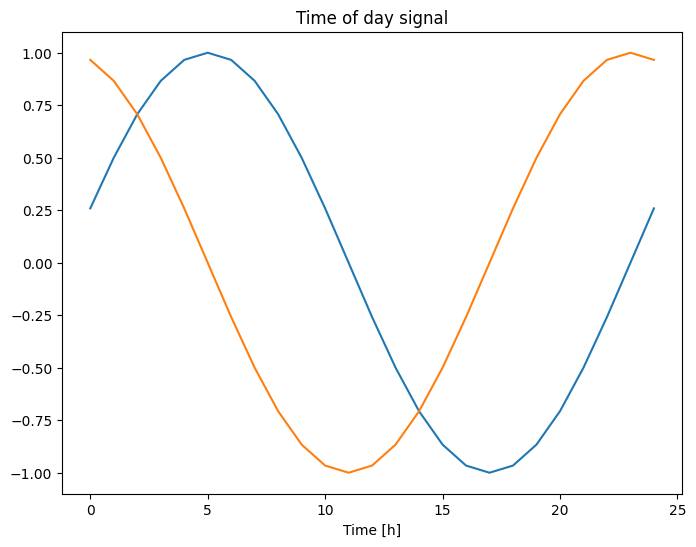

In [14]:
plt.plot(np.array(df['Day sin'])[:25])
plt.plot(np.array(df['Day cos'])[:25])
plt.xlabel('Time [h]')
plt.title('Time of day signal')

그러면 모델이 가장 중요한 빈도 특성에 액세스할 수 있습니다. 이 경우 어떤 빈도가 중요한지 미리 알고 있었습니다.

해당 정보가 없는 경우 <a href="https://en.wikipedia.org/wiki/Fast_Fourier_transform" class="external">고속 푸리에 변환</a>을 사용하여 특성을 추출하여 중요한 빈도를 결정할 수 있습니다. 가정을 확인하기 위해 시간 경과에 따른 온도의 `tf.signal.rfft`가 있습니다. `1/year` 및 `1/day`에 가까운 빈도에서 명백한 피크가 있다는 점에 주목하세요.


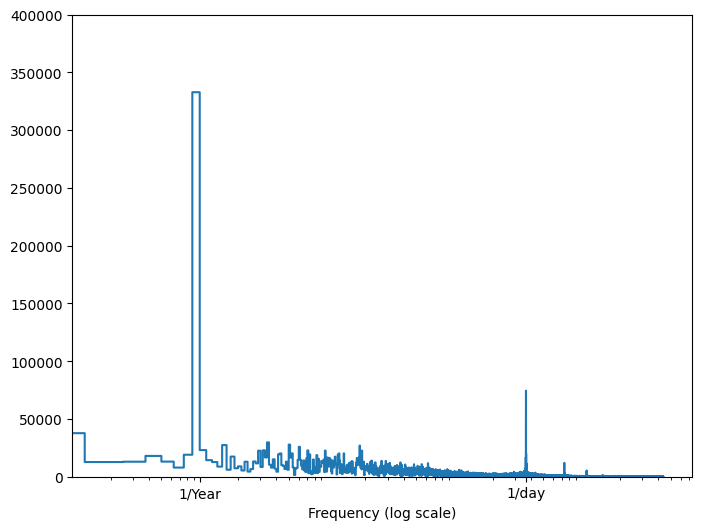

In [15]:
fft = tf.signal.rfft(df['T (degC)'])
f_per_dataset = np.arange(0, len(fft))

n_samples_h = len(df['T (degC)'])
hours_per_year = 24*365.2524
years_per_dataset = n_samples_h/(hours_per_year)

f_per_year = f_per_dataset/years_per_dataset
plt.step(f_per_year, np.abs(fft))
plt.xscale('log')
plt.ylim(0, 400000)
plt.xlim([0.1, max(plt.xlim())])
plt.xticks([1, 365.2524], labels=['1/Year', '1/day'])
_ = plt.xlabel('Frequency (log scale)')

### 데이터 분할

훈련, 검증 및 테스트 세트에 `(70%, 20%, 10%)` 분할을 사용합니다. 분할하기 전에 데이터가 임의로 셔플되지 **않습니다**. 이것은 두 가지 이유 때문입니다.

1. 데이터를 연속된 샘플의 창으로 자르는 것이 여전히 가능합니다.
2. 모델을 훈련한 후 수집된 데이터를 바탕으로 평가하므로 검증/테스트 결과가 보다 현실적입니다.

In [16]:
column_indices = {name: i for i, name in enumerate(df.columns)}

n = len(df)
train_df = df[0:int(n*0.7)]
val_df = df[int(n*0.7):int(n*0.9)]
test_df = df[int(n*0.9):]

num_features = df.shape[1]

### 데이터 정규화

신경망을 훈련하기 전에 특성의 크기를 정하는 것이 중요합니다. 정규화는 평균을 빼고 각 특성의 표준 편차로 나누어 크기 조정을 수행하는 일반적인 방법입니다.

모델이 검증 및 테스트 세트의 값에 액세스할 수 없도록 훈련 데이터를 사용해서만 평균 및 표준 편차를 계산해야 합니다.

또한 모델이 훈련할 때 훈련 세트의 미래 값에 액세스할 수 없어야 하고 이 정규화가 이동 평균을 사용하여 수행되어야 한다고 말할 수도 있습니다. 이 내용은 본 튜토리얼의 중점 사항이 아니며, 검증 및 테스트 세트가 있기 때문에 (다소) 정직한 메트릭을 얻을 수 있습니다. 따라서 단순화를 위해 이 튜토리얼에서는 단순 평균을 사용합니다.

In [17]:
train_mean = train_df.mean()
train_std = train_df.std()

train_df = (train_df - train_mean) / train_std
val_df = (val_df - train_mean) / train_std
test_df = (test_df - train_mean) / train_std

이제 특성의 분포를 살펴봅니다. 일부 특성은 꼬리가 길지만 `-9999` 풍속 값과 같은 명백한 오류는 없습니다.

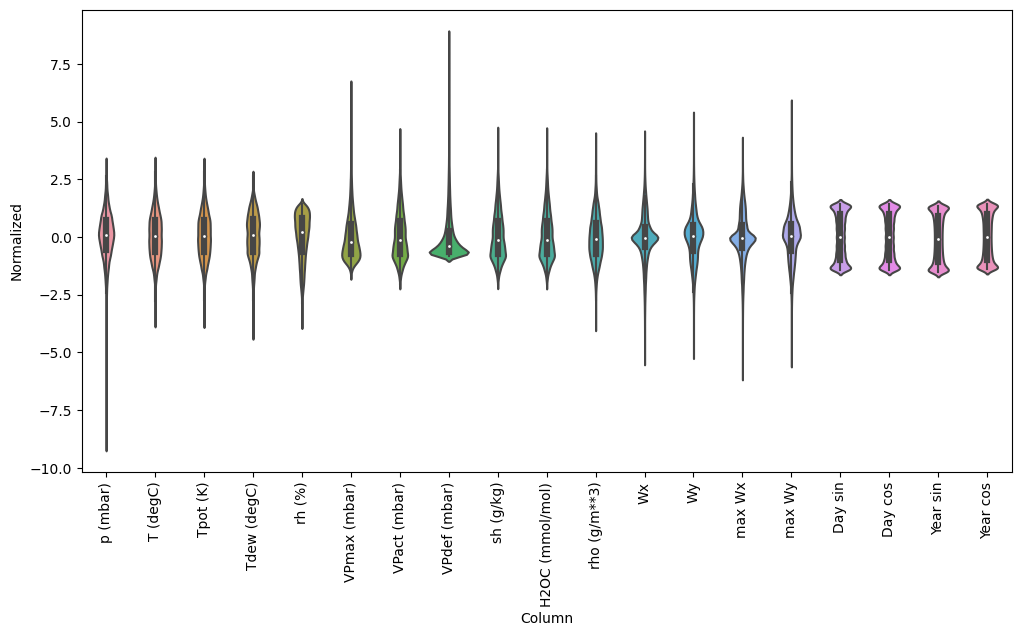

In [18]:
df_std = (df - train_mean) / train_std
df_std = df_std.melt(var_name='Column', value_name='Normalized')
plt.figure(figsize=(12, 6))
ax = sns.violinplot(x='Column', y='Normalized', data=df_std)
_ = ax.set_xticklabels(df.keys(), rotation=90)

## 데이터 창 작업

이 튜토리얼의 모델은 데이터의 연속된 샘플 창을 기반으로 일련의 예측을 수행합니다.

입력 창의 주요 특성은 다음과 같습니다.

- 입력 및 레이블 창의 너비(타임스텝 수)
- 각 사이의 시간 오프셋
- 입력, 레이블 또는 둘 모두로 사용되는 특성

이 튜토리얼은 다양한 모델(선형, DNN, CNN 및 RNN 모델 포함)을 빌드하고 다음 두 가지 목적으로 이 모델을 사용합니다.

- *단일 출력* 및 *다중 출력* 예측
- *단일 타임스텝* 및 *다중 타임스텝* 예측

이 섹션에서는 모든 모델에 재사용할 수 있도록 데이터 창 작업을 구현하는 부분에 중점을 둡니다.


작업 및 모델 유형에 따라 다양한 데이터 창을 생성할 수 있습니다. 다음은 몇 가지 예입니다.

1. 예를 들어, 24시간의 기록이 주어졌을 때 앞으로 24시간의 미래를 단일 예측하기 위해 다음과 같은 창을 정의할 수 있습니다.

![One prediction 24h into the future.](images/raw_window_24h.png)

1. 6시간의 기록이 주어졌을 때 앞으로 1시간의 미래를 예측하는 모델에는 다음과 같은 창이 필요할 수 있습니다.

![One prediction 1h into the future.](images/raw_window_1h.png)

이 섹션의 나머지 부분에서는 `WindowGenerator` 클래스를 정의합니다. 이 클래스는 다음을 수행할 수 있습니다.

1. 위의 다이어그램과 같이 인덱스와 오프셋을 처리합니다.
2. 특성 창을 `(features, labels)` 쌍으로 분할합니다.
3. 결과 창의 내용을 플롯합니다.
4. `tf.data.Dataset`를 사용하여 훈련, 평가 및 테스트 데이터로부터 이러한 창을 여러 배치로 효율적으로 생성합니다.

### 1. 인덱스 및 오프셋

우선 `WindowGenerator` 클래스를 만듭니다. `__init__` 메서드에는 입력 및 레이블 인덱스에 필요한 모든 논리가 포함됩니다.

또한 훈련, 평가 및 테스트 DataFrame을 입력으로 사용합니다. 이러한 DataFrame은 나중에 창의 `tf.data.Dataset`로 변환됩니다.

In [19]:
class WindowGenerator():
  def __init__(self, input_width, label_width, shift,
               train_df=train_df, val_df=val_df, test_df=test_df,
               label_columns=None):
    # Store the raw data.
    self.train_df = train_df
    self.val_df = val_df
    self.test_df = test_df

    # Work out the label column indices.
    self.label_columns = label_columns
    if label_columns is not None:
      self.label_columns_indices = {name: i for i, name in
                                    enumerate(label_columns)}
    self.column_indices = {name: i for i, name in
                           enumerate(train_df.columns)}

    # Work out the window parameters.
    self.input_width = input_width
    self.label_width = label_width
    self.shift = shift

    self.total_window_size = input_width + shift

    self.input_slice = slice(0, input_width)
    self.input_indices = np.arange(self.total_window_size)[self.input_slice]

    self.label_start = self.total_window_size - self.label_width
    self.labels_slice = slice(self.label_start, None)
    self.label_indices = np.arange(self.total_window_size)[self.labels_slice]

  def __repr__(self):
    return '\n'.join([
        f'Total window size: {self.total_window_size}',
        f'Input indices: {self.input_indices}',
        f'Label indices: {self.label_indices}',
        f'Label column name(s): {self.label_columns}'])

이 섹션의 시작 부분에서 다이어그램에 나타낸 두 개의 창을 만드는 코드는 다음과 같습니다.

In [20]:
w1 = WindowGenerator(input_width=24, label_width=1, shift=24,
                     label_columns=['T (degC)'])
w1

Total window size: 48
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23]
Label indices: [47]
Label column name(s): ['T (degC)']

In [21]:
w2 = WindowGenerator(input_width=6, label_width=1, shift=1,
                     label_columns=['T (degC)'])
w2

Total window size: 7
Input indices: [0 1 2 3 4 5]
Label indices: [6]
Label column name(s): ['T (degC)']

### 2. 분할

연속적인 입력 목록이 주어지면 `split_window` 메서드는 이 목록을 입력 창과 레이블 창으로 변환합니다.

위에서 정의한 예제 `w2`는 다음과 같이 분할됩니다.

![The initial window is all consecuitive samples, this splits it into an (inputs, labels) pairs](https://github.com/tensorflow/docs-l10n/blob/master/site/ko/tutorials/structured_data/images/split_window.png?raw=true)

이 다이어그램에는 데이터의 `features` 축이 나와 있지 않지만 이 `split_window` 함수는 단일 출력과 다중 출력 예에서 모두 사용될 수 있도록 `label_columns`를 처리합니다.

In [22]:
def split_window(self, features):
  inputs = features[:, self.input_slice, :]
  labels = features[:, self.labels_slice, :]
  if self.label_columns is not None:
    labels = tf.stack(
        [labels[:, :, self.column_indices[name]] for name in self.label_columns],
        axis=-1)

  # Slicing doesn't preserve static shape information, so set the shapes
  # manually. This way the `tf.data.Datasets` are easier to inspect.
  inputs.set_shape([None, self.input_width, None])
  labels.set_shape([None, self.label_width, None])

  return inputs, labels

WindowGenerator.split_window = split_window

다음을 사용해 보세요.

In [23]:
# Stack three slices, the length of the total window.
example_window = tf.stack([np.array(train_df[:w2.total_window_size]),
                           np.array(train_df[100:100+w2.total_window_size]),
                           np.array(train_df[200:200+w2.total_window_size])])

example_inputs, example_labels = w2.split_window(example_window)

print('All shapes are: (batch, time, features)')
print(f'Window shape: {example_window.shape}')
print(f'Inputs shape: {example_inputs.shape}')
print(f'Labels shape: {example_labels.shape}')

All shapes are: (batch, time, features)
Window shape: (3, 7, 19)
Inputs shape: (3, 6, 19)
Labels shape: (3, 1, 1)


일반적으로 TensorFlow의 데이터는 가장 바깥 쪽 인덱스가 여러 예제("배치" 차원)에 걸쳐 있는 배열로 구성됩니다. 중간 인덱스는 "시간" 또는 "공간"(너비, 높이) 차원입니다. 가장 안쪽 인덱스는 특성입니다.

위의 코드는 3개의  7-타임스텝 창 배치를 사용하며 각 타임스텝에는 19개의 특성이 있습니다. 그러면 이것을 한 배치 당 6-타임스텝과 19개의 특성 입력 및 1-타임스텝 1-특성 레이블로 분할합니다. 레이블에는 하나의 특성만 있는데 이는 `WindowGenerator`가 `label_columns=['T (degC)']`로 초기화되었기 때문입니다. 우선 이 튜토리얼에서는 단일 출력 레이블을 예측하는 모델을 빌드합니다.

### 3. 플롯하기

다음은 분할 창을 간단하게 시각화할 수 있는 플롯 메서드입니다.

In [24]:
w2.example = example_inputs, example_labels

In [25]:
def plot(self, model=None, plot_col='T (degC)', max_subplots=3):
  inputs, labels = self.example
  plt.figure(figsize=(12, 8))
  plot_col_index = self.column_indices[plot_col]
  max_n = min(max_subplots, len(inputs))
  for n in range(max_n):
    plt.subplot(max_n, 1, n+1)
    plt.ylabel(f'{plot_col} [normed]')
    plt.plot(self.input_indices, inputs[n, :, plot_col_index],
             label='Inputs', marker='.', zorder=-10)

    if self.label_columns:
      label_col_index = self.label_columns_indices.get(plot_col, None)
    else:
      label_col_index = plot_col_index

    if label_col_index is None:
      continue

    plt.scatter(self.label_indices, labels[n, :, label_col_index],
                edgecolors='k', label='Labels', c='#2ca02c', s=64)
    if model is not None:
      predictions = model(inputs)
      plt.scatter(self.label_indices, predictions[n, :, label_col_index],
                  marker='X', edgecolors='k', label='Predictions',
                  c='#ff7f0e', s=64)

    if n == 0:
      plt.legend()

  plt.xlabel('Time [h]')

WindowGenerator.plot = plot

이 플롯은 항목이 참조하는 시간을 기준으로 입력, 레이블 및 (나중에) 예측값을 정렬합니다.

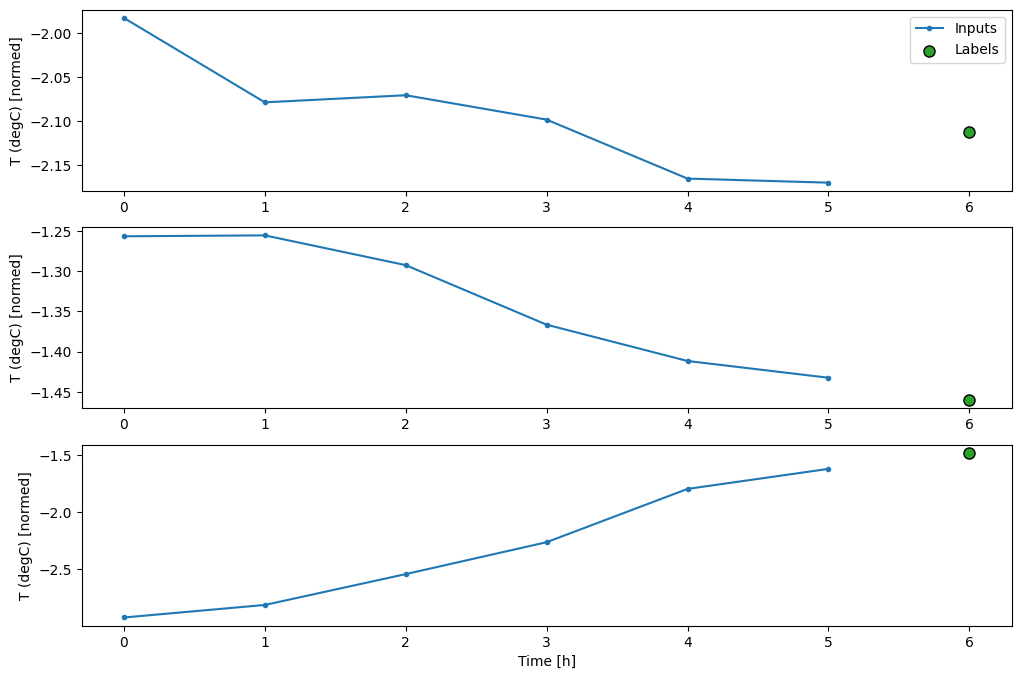

In [26]:
w2.plot()

다른 열을 플롯할 수 있지만 예제 창 `w2` 구성에는 `T (degC)` 열에 대한 레이블만 있습니다.

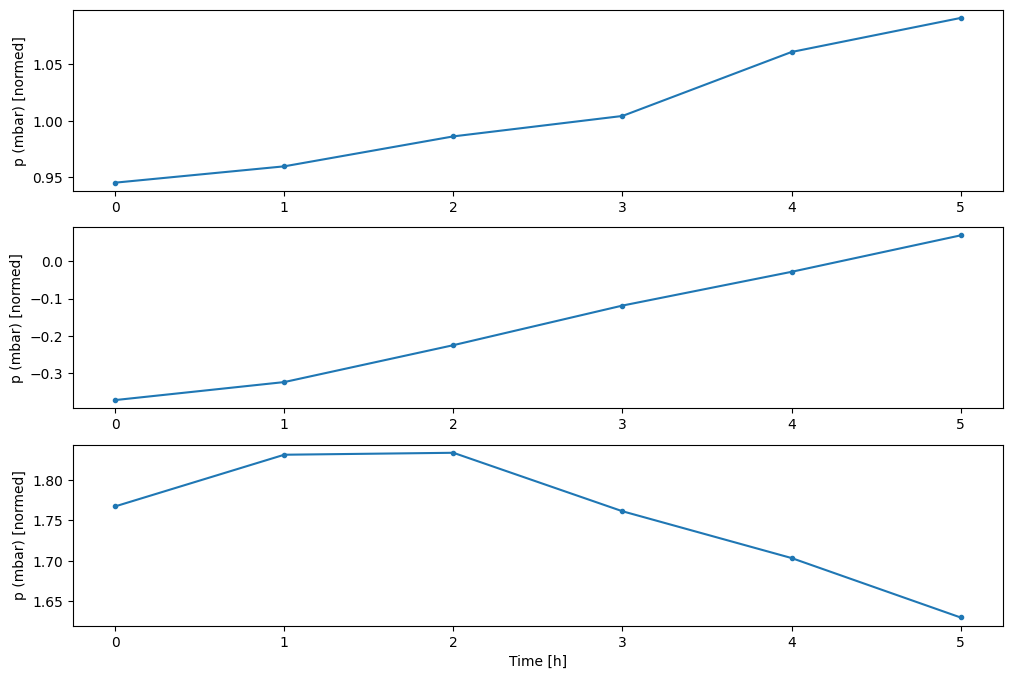

In [27]:
w2.plot(plot_col='p (mbar)')

### 4. `tf.data.Dataset` 만들기

마지막으로, 이 `make_dataset` 메서드는 시계열 DataFrame을 가져와 `tf.keras.utils.timeseries_dataset_from_array` 함수를 이용해 `(input_window, label_window)` 쌍의 `tf.data.Dataset`로 변환합니다.

In [28]:
def make_dataset(self, data):
  data = np.array(data, dtype=np.float32)
  ds = tf.keras.utils.timeseries_dataset_from_array(
      data=data,
      targets=None,
      sequence_length=self.total_window_size,
      sequence_stride=1,
      shuffle=True,
      batch_size=32,)

  ds = ds.map(self.split_window)

  return ds

WindowGenerator.make_dataset = make_dataset

`WindowGenerator` 객체는 훈련, 검증, 테스트 데이터를 보존합니다.

앞에서 정의한 `make_dataset` 메서드를 사용하여 `tf.data.Dataset`로 액세스하기 위한 속성을 추가합니다. 또한 쉽게 액세스하고 플로팅할 수 있도록 표준 예제 배치를 추가합니다.

In [29]:
@property
def train(self):
  return self.make_dataset(self.train_df)

@property
def val(self):
  return self.make_dataset(self.val_df)

@property
def test(self):
  return self.make_dataset(self.test_df)

@property
def example(self):
  """Get and cache an example batch of `inputs, labels` for plotting."""
  result = getattr(self, '_example', None)
  if result is None:
    # No example batch was found, so get one from the `.train` dataset
    result = next(iter(self.train))
    # And cache it for next time
    self._example = result
  return result

WindowGenerator.train = train
WindowGenerator.val = val
WindowGenerator.test = test
WindowGenerator.example = example

이제 `WindowGenerator` 객체가 `tf.data.Dataset` 객체에 대한 액세스 권한을 부여하므로 데이터를 쉽게 반복할 수 있습니다.

`Dataset.element_spec` 속성은 데이터세트 요소의 구조, 데이터 유형, 형상을 알려줍니다.

In [30]:
# Each element is an (inputs, label) pair.
w2.train.element_spec

(TensorSpec(shape=(None, 6, 19), dtype=tf.float32, name=None),
 TensorSpec(shape=(None, 1, 1), dtype=tf.float32, name=None))

`Dataset`를 반복하면 구체적인 배치가 생성됩니다.

In [31]:
for example_inputs, example_labels in w2.train.take(1):
  print(f'Inputs shape (batch, time, features): {example_inputs.shape}')
  print(f'Labels shape (batch, time, features): {example_labels.shape}')

Inputs shape (batch, time, features): (32, 6, 19)
Labels shape (batch, time, features): (32, 1, 1)


## 단일 스텝 모델

이러한 종류의 데이터를 기반으로 빌드할 수 있는 가장 간단한 모델은 현재 조건만을 기초로 1 타임스텝(1시간) 후의 단일 특성 값을 예측하는 모델입니다.

따라서 1시간 미래의 `T (degC)` 값을 예측하는 모델을 빌드하는 것으로 시작하겠습니다.

![Predict the next time step](images/narrow_window.png)

다음과 같은 단일 스텝 `(input, label)` 쌍을 생성하도록 `WindowGenerator` 객체를 구성합니다.

In [32]:
single_step_window = WindowGenerator(
    input_width=1, label_width=1, shift=1,
    label_columns=['T (degC)'])
single_step_window

Total window size: 2
Input indices: [0]
Label indices: [1]
Label column name(s): ['T (degC)']

`window` 객체는 훈련, 검증 및 테스트 세트로부터 `tf.data.Datasets`를 생성하므로 데이터 배치를 쉽게 반복할 수 있습니다.


In [33]:
for example_inputs, example_labels in single_step_window.train.take(1):
  print(f'Inputs shape (batch, time, features): {example_inputs.shape}')
  print(f'Labels shape (batch, time, features): {example_labels.shape}')

Inputs shape (batch, time, features): (32, 1, 19)
Labels shape (batch, time, features): (32, 1, 1)


### 기준

훈련 가능한 모델을 빌드하기 전에 나중에 더 복잡한 모델과 비교하기 위한 포인트로 성능 기준을 갖는 것이 좋습니다.

첫 번째 작업은 모든 특성의 현재 값을 고려하여 1시간 후의 온도를 예측하는 것입니다. 현재 값에는 현재 온도가 포함됩니다.

따라서 예측으로 현재 온도를 반환하여 "변화 없음"을 예측하는 모델로 시작하겠습니다. 온도가 천천히 변하기 때문에 이것은 합리적인 기준입니다. 물론, 더 미래로 들어가면 이 기준의 예측 효과를 떨어질 것입니다.

![Send the input to the output](images/baseline.png)

In [34]:
class Baseline(tf.keras.Model):
  def __init__(self, label_index=None):
    super().__init__()
    self.label_index = label_index

  def call(self, inputs):
    if self.label_index is None:
      return inputs
    result = inputs[:, :, self.label_index]
    return result[:, :, tf.newaxis]

이 모델을 인스턴스화하고 평가합니다.

In [35]:
baseline = Baseline(label_index=column_indices['T (degC)'])

baseline.compile(loss=tf.keras.losses.MeanSquaredError(),
                 metrics=[tf.keras.metrics.MeanAbsoluteError()])

val_performance = {}
performance = {}
val_performance['Baseline'] = baseline.evaluate(single_step_window.val)
performance['Baseline'] = baseline.evaluate(single_step_window.test, verbose=0)

  1/439 [..............................] - ETA: 1:25 - loss: 0.0102 - mean_absolute_error: 0.0725

 26/439 [>.............................] - ETA: 0s - loss: 0.0119 - mean_absolute_error: 0.0770  

 53/439 [==>...........................] - ETA: 0s - loss: 0.0131 - mean_absolute_error: 0.0787

 81/439 [====>.........................] - ETA: 0s - loss: 0.0125 - mean_absolute_error: 0.0779

110/439 [======>.......................] - ETA: 0s - loss: 0.0125 - mean_absolute_error: 0.0777

137/439 [========>.....................] - ETA: 0s - loss: 0.0126 - mean_absolute_error: 0.0781

164/439 [==========>...................] - ETA: 0s - loss: 0.0123 - mean_absolute_error: 0.0773

191/439 [============>.................] - ETA: 0s - loss: 0.0124 - mean_absolute_error: 0.0774

218/439 [=============>................] - ETA: 0s - loss: 0.0126 - mean_absolute_error: 0.0777

245/439 [===============>..............] - ETA: 0s - loss: 0.0126 - mean_absolute_error: 0.0781

273/439 [=================>............] - ETA: 0s - loss: 0.0126 - mean_absolute_error: 0.0782

301/439 [===================>..........] - ETA: 0s - loss: 0.0125 - mean_absolute_error: 0.0781

330/439 [=====================>........] - ETA: 0s - loss: 0.0125 - mean_absolute_error: 0.0780

358/439 [=======================>......] - ETA: 0s - loss: 0.0126 - mean_absolute_error: 0.0781

386/439 [=========================>....] - ETA: 0s - loss: 0.0126 - mean_absolute_error: 0.0781

414/439 [===========================>..] - ETA: 0s - loss: 0.0127 - mean_absolute_error: 0.0784

439/439 [==============================] - 1s 2ms/step - loss: 0.0128 - mean_absolute_error: 0.0785


몇 가지 성능 메트릭을 출력했지만 모델이 얼마나 잘 동작하는지에 대한 느낌은 주지 않습니다.

`WindowGenerator`에는 플롯 메서드가 있지만 단일 샘플만으로는 플롯이 그다지 흥미롭지 않습니다.

따라서 한 번에 24시간 연속 입력 및 레이블 창을 생성하는 더 넓은 `WindowGenerator`를 만듭니다. 새로운 `wide_window`는 모델이 작동하는 방식을 변경하지 않습니다. 이 모델은 단일 입력 타임스텝을 기반으로 1시간 미래를을 예측합니다. 여기서 `time` 축은 `batch` 축과 같은 역할을 합니다. 각 예측은 타임스텝 사이의 상호 작용 없이 독립적으로 이루어집니다.

In [36]:
wide_window = WindowGenerator(
    input_width=24, label_width=24, shift=1,
    label_columns=['T (degC)'])

wide_window

Total window size: 25
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23]
Label indices: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24]
Label column name(s): ['T (degC)']

이 확장된 창은 어떠한 코드 변경 없이 동일한 `baseline` 모델에 직접 전달할 수 있습니다. 이는 입력과 레이블이 동일한 수의 타임스텝을 가지며 기준이 입력을 출력으로 전달하기 때문에 가능합니다.

![One prediction 1h into the future, ever hour.](images/last_window.png)

In [37]:
print('Input shape:', wide_window.example[0].shape)
print('Output shape:', baseline(wide_window.example[0]).shape)

Input shape: (32, 24, 19)
Output shape: (32, 24, 1)


기준 모델의 예측을 플롯하면 1시간씩 오른쪽으로 이동한 단순한 레이블임을 알 수 있습니다.

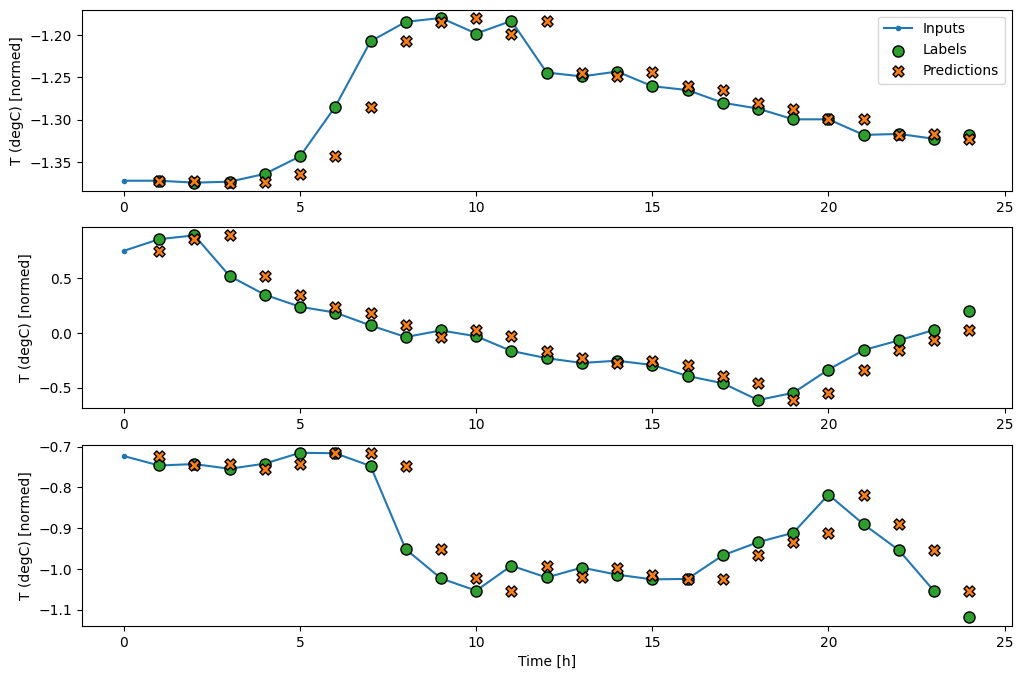

In [38]:
wide_window.plot(baseline)

위의 세 가지 예제 플롯에서 단일 스텝 모델은 24시간 동안 실행됩니다. 이에 관해 몇 가지 설명이 필요합니다.

- 파란색 `Inputs` 라인은 각 타임스텝의 입력 온도를 보여줍니다. 이 모델은 모든 특성을 수신하며 이 플롯은 온도만 표시합니다.
- 녹색 `Labels` 점은 목표 예측 값을 나타냅니다. 이러한 점은 입력 시간이 아니라 예측 시간에 표시됩니다. 레이벨의 범위가 입력에 상대적으로 한 스텝 이동하는 이유가 여기에 있습니다.
- 주황색 `Predictions` 십자는 각 출력 타임스텝에 대한 모델의 예측입니다. 모델이 완벽하게 예측하는 경우 예측은 `Labels` 바로 위에 놓여집니다.

### 선형 모델

이 작업에 적용할 수 있는 가장 간단한 **훈련 가능한** 모델은 입력과 출력 사이에 선형 변환을 삽입하는 것입니다. 이 경우 타임스텝의 출력은 해당 스텝에만 의존합니다.

![A single step prediction](images/narrow_window.png)

`activation` 세트가 없는 `tf.keras.layers.Dense`는 선형 모델입니다. 레이어는 데이터의 마지막 축을 `(batch, time, inputs)`에서 `(batch, time, units)`로만 변환하며, `batch` 및 `time` 축의 모든 항목에 독립적으로 적용됩니다.

In [39]:
linear = tf.keras.Sequential([
    tf.keras.layers.Dense(units=1)
])

In [40]:
print('Input shape:', single_step_window.example[0].shape)
print('Output shape:', linear(single_step_window.example[0]).shape)

Input shape: (32, 1, 19)


Output shape: (32, 1, 1)


이 튜토리얼은 많은 모델을 훈련하므로 훈련 절차를 하나의 함수 패키지로 만듭니다.

In [41]:
MAX_EPOCHS = 20

def compile_and_fit(model, window, patience=2):
  early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                    patience=patience,
                                                    mode='min')

  model.compile(loss=tf.keras.losses.MeanSquaredError(),
                optimizer=tf.keras.optimizers.Adam(),
                metrics=[tf.keras.metrics.MeanAbsoluteError()])

  history = model.fit(window.train, epochs=MAX_EPOCHS,
                      validation_data=window.val,
                      callbacks=[early_stopping])
  return history

모델을 훈련하고 성능을 평가합니다.

In [42]:
history = compile_and_fit(linear, single_step_window)

val_performance['Linear'] = linear.evaluate(single_step_window.val)
performance['Linear'] = linear.evaluate(single_step_window.test, verbose=0)

Epoch 1/20


   1/1534 [..............................] - ETA: 18:04 - loss: 4.2131 - mean_absolute_error: 1.5781

  20/1534 [..............................] - ETA: 4s - loss: 6.2882 - mean_absolute_error: 2.0040   

  40/1534 [..............................] - ETA: 3s - loss: 5.8004 - mean_absolute_error: 1.9310

  60/1534 [>.............................] - ETA: 3s - loss: 5.3894 - mean_absolute_error: 1.8501

  81/1534 [>.............................] - ETA: 3s - loss: 4.9586 - mean_absolute_error: 1.7736

 101/1534 [>.............................] - ETA: 3s - loss: 4.6297 - mean_absolute_error: 1.7087

 121/1534 [=>............................] - ETA: 3s - loss: 4.3185 - mean_absolute_error: 1.6438

 142/1534 [=>............................] - ETA: 3s - loss: 3.9882 - mean_absolute_error: 1.5713

 164/1534 [==>...........................] - ETA: 3s - loss: 3.6969 - mean_absolute_error: 1.5043

 185/1534 [==>...........................] - ETA: 3s - loss: 3.4349 - mean_absolute_error: 1.4396

 205/1534 [===>..........................] - ETA: 3s - loss: 3.2087 - mean_absolute_error: 1.3808

 225/1534 [===>..........................] - ETA: 3s - loss: 2.9975 - mean_absolute_error: 1.3231

 245/1534 [===>..........................] - ETA: 3s - loss: 2.8155 - mean_absolute_error: 1.2718

 265/1534 [====>.........................] - ETA: 3s - loss: 2.6488 - mean_absolute_error: 1.2225

 285/1534 [====>.........................] - ETA: 3s - loss: 2.4978 - mean_absolute_error: 1.1756

 304/1534 [====>.........................] - ETA: 3s - loss: 2.3666 - mean_absolute_error: 1.1330

 325/1534 [=====>........................] - ETA: 3s - loss: 2.2335 - mean_absolute_error: 1.0888

 345/1534 [=====>........................] - ETA: 3s - loss: 2.1216 - mean_absolute_error: 1.0515

 365/1534 [======>.......................] - ETA: 2s - loss: 2.0190 - mean_absolute_error: 1.0158

 385/1534 [======>.......................] - ETA: 2s - loss: 1.9254 - mean_absolute_error: 0.9824

 406/1534 [======>.......................] - ETA: 2s - loss: 1.8349 - mean_absolute_error: 0.9487

 427/1534 [=======>......................] - ETA: 2s - loss: 1.7527 - mean_absolute_error: 0.9182

 447/1534 [=======>......................] - ETA: 2s - loss: 1.6807 - mean_absolute_error: 0.8908

 468/1534 [========>.....................] - ETA: 2s - loss: 1.6104 - mean_absolute_error: 0.8629

 489/1534 [========>.....................] - ETA: 2s - loss: 1.5454 - mean_absolute_error: 0.8366

 510/1534 [========>.....................] - ETA: 2s - loss: 1.4852 - mean_absolute_error: 0.8117

 531/1534 [=========>....................] - ETA: 2s - loss: 1.4298 - mean_absolute_error: 0.7889

 552/1534 [=========>....................] - ETA: 2s - loss: 1.3783 - mean_absolute_error: 0.7672

 574/1534 [==========>...................] - ETA: 2s - loss: 1.3277 - mean_absolute_error: 0.7453

 595/1534 [==========>...................] - ETA: 2s - loss: 1.2828 - mean_absolute_error: 0.7258

 616/1534 [===========>..................] - ETA: 2s - loss: 1.2408 - mean_absolute_error: 0.7072

 638/1534 [===========>..................] - ETA: 2s - loss: 1.1997 - mean_absolute_error: 0.6887

 659/1534 [===========>..................] - ETA: 2s - loss: 1.1628 - mean_absolute_error: 0.6720

 680/1534 [============>.................] - ETA: 2s - loss: 1.1281 - mean_absolute_error: 0.6561

 701/1534 [============>.................] - ETA: 2s - loss: 1.0953 - mean_absolute_error: 0.6408

 722/1534 [=============>................] - ETA: 2s - loss: 1.0643 - mean_absolute_error: 0.6262

 744/1534 [=============>................] - ETA: 1s - loss: 1.0338 - mean_absolute_error: 0.6116

 765/1534 [=============>................] - ETA: 1s - loss: 1.0061 - mean_absolute_error: 0.5982

 787/1534 [==============>...............] - ETA: 1s - loss: 0.9787 - mean_absolute_error: 0.5850

 808/1534 [==============>...............] - ETA: 1s - loss: 0.9538 - mean_absolute_error: 0.5728

 829/1534 [===============>..............] - ETA: 1s - loss: 0.9302 - mean_absolute_error: 0.5611

 850/1534 [===============>..............] - ETA: 1s - loss: 0.9076 - mean_absolute_error: 0.5497

 870/1534 [================>.............] - ETA: 1s - loss: 0.8873 - mean_absolute_error: 0.5396

 891/1534 [================>.............] - ETA: 1s - loss: 0.8667 - mean_absolute_error: 0.5291

 912/1534 [================>.............] - ETA: 1s - loss: 0.8471 - mean_absolute_error: 0.5191

 933/1534 [=================>............] - ETA: 1s - loss: 0.8284 - mean_absolute_error: 0.5095

 955/1534 [=================>............] - ETA: 1s - loss: 0.8097 - mean_absolute_error: 0.5000

 976/1534 [==================>...........] - ETA: 1s - loss: 0.7926 - mean_absolute_error: 0.4913

 997/1534 [==================>...........] - ETA: 1s - loss: 0.7762 - mean_absolute_error: 0.4829

1018/1534 [==================>...........] - ETA: 1s - loss: 0.7605 - mean_absolute_error: 0.4748

1038/1534 [===================>..........] - ETA: 1s - loss: 0.7461 - mean_absolute_error: 0.4674

1060/1534 [===================>..........] - ETA: 1s - loss: 0.7309 - mean_absolute_error: 0.4595

1080/1534 [====================>.........] - ETA: 1s - loss: 0.7176 - mean_absolute_error: 0.4527

1100/1534 [====================>.........] - ETA: 1s - loss: 0.7048 - mean_absolute_error: 0.4459

1120/1534 [====================>.........] - ETA: 1s - loss: 0.6925 - mean_absolute_error: 0.4396

1141/1534 [=====================>........] - ETA: 0s - loss: 0.6800 - mean_absolute_error: 0.4331

1161/1534 [=====================>........] - ETA: 0s - loss: 0.6685 - mean_absolute_error: 0.4271

1182/1534 [======================>.......] - ETA: 0s - loss: 0.6568 - mean_absolute_error: 0.4209

1203/1534 [======================>.......] - ETA: 0s - loss: 0.6456 - mean_absolute_error: 0.4151

1224/1534 [======================>.......] - ETA: 0s - loss: 0.6347 - mean_absolute_error: 0.4094

1245/1534 [=======================>......] - ETA: 0s - loss: 0.6242 - mean_absolute_error: 0.4040

1265/1534 [=======================>......] - ETA: 0s - loss: 0.6145 - mean_absolute_error: 0.3989

1286/1534 [========================>.....] - ETA: 0s - loss: 0.6047 - mean_absolute_error: 0.3938

1307/1534 [========================>.....] - ETA: 0s - loss: 0.5952 - mean_absolute_error: 0.3888

1328/1534 [========================>.....] - ETA: 0s - loss: 0.5859 - mean_absolute_error: 0.3839

1349/1534 [=========================>....] - ETA: 0s - loss: 0.5770 - mean_absolute_error: 0.3791

1370/1534 [=========================>....] - ETA: 0s - loss: 0.5683 - mean_absolute_error: 0.3745

1390/1534 [==========================>...] - ETA: 0s - loss: 0.5603 - mean_absolute_error: 0.3703

1410/1534 [==========================>...] - ETA: 0s - loss: 0.5525 - mean_absolute_error: 0.3662

1431/1534 [==========================>...] - ETA: 0s - loss: 0.5446 - mean_absolute_error: 0.3621

1451/1534 [===========================>..] - ETA: 0s - loss: 0.5372 - mean_absolute_error: 0.3582

1471/1534 [===========================>..] - ETA: 0s - loss: 0.5301 - mean_absolute_error: 0.3544

1491/1534 [============================>.] - ETA: 0s - loss: 0.5231 - mean_absolute_error: 0.3507

1511/1534 [============================>.] - ETA: 0s - loss: 0.5164 - mean_absolute_error: 0.3471

1532/1534 [============================>.] - ETA: 0s - loss: 0.5095 - mean_absolute_error: 0.3435

1534/1534 [==============================] - 5s 3ms/step - loss: 0.5091 - mean_absolute_error: 0.3433 - val_loss: 0.0114 - val_mean_absolute_error: 0.0803


Epoch 2/20


   1/1534 [..............................] - ETA: 39s - loss: 0.0050 - mean_absolute_error: 0.0572

  20/1534 [..............................] - ETA: 4s - loss: 0.0114 - mean_absolute_error: 0.0803 

  41/1534 [..............................] - ETA: 3s - loss: 0.0109 - mean_absolute_error: 0.0795

  61/1534 [>.............................] - ETA: 3s - loss: 0.0118 - mean_absolute_error: 0.0814

  82/1534 [>.............................] - ETA: 3s - loss: 0.0116 - mean_absolute_error: 0.0804

 102/1534 [>.............................] - ETA: 3s - loss: 0.0114 - mean_absolute_error: 0.0799

 124/1534 [=>............................] - ETA: 3s - loss: 0.0114 - mean_absolute_error: 0.0800

 146/1534 [=>............................] - ETA: 3s - loss: 0.0117 - mean_absolute_error: 0.0804

 167/1534 [==>...........................] - ETA: 3s - loss: 0.0114 - mean_absolute_error: 0.0799

 188/1534 [==>...........................] - ETA: 3s - loss: 0.0114 - mean_absolute_error: 0.0797

 209/1534 [===>..........................] - ETA: 3s - loss: 0.0113 - mean_absolute_error: 0.0795

 229/1534 [===>..........................] - ETA: 3s - loss: 0.0114 - mean_absolute_error: 0.0798

 250/1534 [===>..........................] - ETA: 3s - loss: 0.0114 - mean_absolute_error: 0.0798

 271/1534 [====>.........................] - ETA: 3s - loss: 0.0113 - mean_absolute_error: 0.0794

 292/1534 [====>.........................] - ETA: 3s - loss: 0.0113 - mean_absolute_error: 0.0794

 313/1534 [=====>........................] - ETA: 3s - loss: 0.0113 - mean_absolute_error: 0.0791

 334/1534 [=====>........................] - ETA: 2s - loss: 0.0112 - mean_absolute_error: 0.0792

 355/1534 [=====>........................] - ETA: 2s - loss: 0.0112 - mean_absolute_error: 0.0792

 376/1534 [======>.......................] - ETA: 2s - loss: 0.0111 - mean_absolute_error: 0.0790

 397/1534 [======>.......................] - ETA: 2s - loss: 0.0111 - mean_absolute_error: 0.0790

 418/1534 [=======>......................] - ETA: 2s - loss: 0.0111 - mean_absolute_error: 0.0788

 439/1534 [=======>......................] - ETA: 2s - loss: 0.0110 - mean_absolute_error: 0.0787

 460/1534 [=======>......................] - ETA: 2s - loss: 0.0110 - mean_absolute_error: 0.0788

 481/1534 [========>.....................] - ETA: 2s - loss: 0.0111 - mean_absolute_error: 0.0789

 502/1534 [========>.....................] - ETA: 2s - loss: 0.0111 - mean_absolute_error: 0.0789

 523/1534 [=========>....................] - ETA: 2s - loss: 0.0111 - mean_absolute_error: 0.0788

 543/1534 [=========>....................] - ETA: 2s - loss: 0.0111 - mean_absolute_error: 0.0787

 563/1534 [==========>...................] - ETA: 2s - loss: 0.0110 - mean_absolute_error: 0.0785

 584/1534 [==========>...................] - ETA: 2s - loss: 0.0110 - mean_absolute_error: 0.0786

 605/1534 [==========>...................] - ETA: 2s - loss: 0.0110 - mean_absolute_error: 0.0786

 626/1534 [===========>..................] - ETA: 2s - loss: 0.0111 - mean_absolute_error: 0.0787

 647/1534 [===========>..................] - ETA: 2s - loss: 0.0111 - mean_absolute_error: 0.0787

 667/1534 [============>.................] - ETA: 2s - loss: 0.0111 - mean_absolute_error: 0.0788

 688/1534 [============>.................] - ETA: 2s - loss: 0.0111 - mean_absolute_error: 0.0786

 708/1534 [============>.................] - ETA: 2s - loss: 0.0111 - mean_absolute_error: 0.0785

 728/1534 [=============>................] - ETA: 1s - loss: 0.0111 - mean_absolute_error: 0.0786

 748/1534 [=============>................] - ETA: 1s - loss: 0.0111 - mean_absolute_error: 0.0785

 768/1534 [==============>...............] - ETA: 1s - loss: 0.0110 - mean_absolute_error: 0.0785

 788/1534 [==============>...............] - ETA: 1s - loss: 0.0110 - mean_absolute_error: 0.0784

 808/1534 [==============>...............] - ETA: 1s - loss: 0.0110 - mean_absolute_error: 0.0784

 829/1534 [===============>..............] - ETA: 1s - loss: 0.0110 - mean_absolute_error: 0.0784

 849/1534 [===============>..............] - ETA: 1s - loss: 0.0110 - mean_absolute_error: 0.0784

 870/1534 [================>.............] - ETA: 1s - loss: 0.0110 - mean_absolute_error: 0.0783

 890/1534 [================>.............] - ETA: 1s - loss: 0.0110 - mean_absolute_error: 0.0781

 911/1534 [================>.............] - ETA: 1s - loss: 0.0110 - mean_absolute_error: 0.0781

 932/1534 [=================>............] - ETA: 1s - loss: 0.0109 - mean_absolute_error: 0.0780

 953/1534 [=================>............] - ETA: 1s - loss: 0.0110 - mean_absolute_error: 0.0780

 974/1534 [==================>...........] - ETA: 1s - loss: 0.0109 - mean_absolute_error: 0.0779

 995/1534 [==================>...........] - ETA: 1s - loss: 0.0109 - mean_absolute_error: 0.0779

1016/1534 [==================>...........] - ETA: 1s - loss: 0.0109 - mean_absolute_error: 0.0778

1037/1534 [===================>..........] - ETA: 1s - loss: 0.0109 - mean_absolute_error: 0.0777

1057/1534 [===================>..........] - ETA: 1s - loss: 0.0109 - mean_absolute_error: 0.0777

1077/1534 [====================>.........] - ETA: 1s - loss: 0.0108 - mean_absolute_error: 0.0776

1097/1534 [====================>.........] - ETA: 1s - loss: 0.0108 - mean_absolute_error: 0.0776

1118/1534 [====================>.........] - ETA: 1s - loss: 0.0108 - mean_absolute_error: 0.0776

1139/1534 [=====================>........] - ETA: 0s - loss: 0.0108 - mean_absolute_error: 0.0775

1160/1534 [=====================>........] - ETA: 0s - loss: 0.0108 - mean_absolute_error: 0.0774

1181/1534 [======================>.......] - ETA: 0s - loss: 0.0108 - mean_absolute_error: 0.0774

1202/1534 [======================>.......] - ETA: 0s - loss: 0.0108 - mean_absolute_error: 0.0773

1222/1534 [======================>.......] - ETA: 0s - loss: 0.0107 - mean_absolute_error: 0.0772

1243/1534 [=======================>......] - ETA: 0s - loss: 0.0108 - mean_absolute_error: 0.0772

1263/1534 [=======================>......] - ETA: 0s - loss: 0.0108 - mean_absolute_error: 0.0772

1283/1534 [========================>.....] - ETA: 0s - loss: 0.0107 - mean_absolute_error: 0.0772

1303/1534 [========================>.....] - ETA: 0s - loss: 0.0107 - mean_absolute_error: 0.0771

1323/1534 [========================>.....] - ETA: 0s - loss: 0.0107 - mean_absolute_error: 0.0770

1344/1534 [=========================>....] - ETA: 0s - loss: 0.0106 - mean_absolute_error: 0.0769

1365/1534 [=========================>....] - ETA: 0s - loss: 0.0106 - mean_absolute_error: 0.0768

1386/1534 [==========================>...] - ETA: 0s - loss: 0.0106 - mean_absolute_error: 0.0769

1407/1534 [==========================>...] - ETA: 0s - loss: 0.0106 - mean_absolute_error: 0.0768

1428/1534 [==========================>...] - ETA: 0s - loss: 0.0106 - mean_absolute_error: 0.0768

1449/1534 [===========================>..] - ETA: 0s - loss: 0.0106 - mean_absolute_error: 0.0767

1470/1534 [===========================>..] - ETA: 0s - loss: 0.0106 - mean_absolute_error: 0.0767

1491/1534 [============================>.] - ETA: 0s - loss: 0.0106 - mean_absolute_error: 0.0766

1512/1534 [============================>.] - ETA: 0s - loss: 0.0106 - mean_absolute_error: 0.0766

1533/1534 [============================>.] - ETA: 0s - loss: 0.0106 - mean_absolute_error: 0.0765

1534/1534 [==============================] - 5s 3ms/step - loss: 0.0106 - mean_absolute_error: 0.0765 - val_loss: 0.0098 - val_mean_absolute_error: 0.0736


Epoch 3/20


   1/1534 [..............................] - ETA: 42s - loss: 0.0084 - mean_absolute_error: 0.0677

  21/1534 [..............................] - ETA: 3s - loss: 0.0101 - mean_absolute_error: 0.0753 

  42/1534 [..............................] - ETA: 3s - loss: 0.0098 - mean_absolute_error: 0.0740

  63/1534 [>.............................] - ETA: 3s - loss: 0.0105 - mean_absolute_error: 0.0755

  84/1534 [>.............................] - ETA: 3s - loss: 0.0103 - mean_absolute_error: 0.0748

 104/1534 [=>............................] - ETA: 3s - loss: 0.0100 - mean_absolute_error: 0.0744

 125/1534 [=>............................] - ETA: 3s - loss: 0.0101 - mean_absolute_error: 0.0744

 147/1534 [=>............................] - ETA: 3s - loss: 0.0103 - mean_absolute_error: 0.0750

 168/1534 [==>...........................] - ETA: 3s - loss: 0.0101 - mean_absolute_error: 0.0745

 189/1534 [==>...........................] - ETA: 3s - loss: 0.0100 - mean_absolute_error: 0.0743

 210/1534 [===>..........................] - ETA: 3s - loss: 0.0100 - mean_absolute_error: 0.0741

 231/1534 [===>..........................] - ETA: 3s - loss: 0.0100 - mean_absolute_error: 0.0740

 252/1534 [===>..........................] - ETA: 3s - loss: 0.0100 - mean_absolute_error: 0.0739

 273/1534 [====>.........................] - ETA: 3s - loss: 0.0100 - mean_absolute_error: 0.0738

 294/1534 [====>.........................] - ETA: 3s - loss: 0.0100 - mean_absolute_error: 0.0738

 314/1534 [=====>........................] - ETA: 3s - loss: 0.0099 - mean_absolute_error: 0.0734

 335/1534 [=====>........................] - ETA: 2s - loss: 0.0099 - mean_absolute_error: 0.0734

 356/1534 [=====>........................] - ETA: 2s - loss: 0.0099 - mean_absolute_error: 0.0736

 377/1534 [======>.......................] - ETA: 2s - loss: 0.0098 - mean_absolute_error: 0.0734

 398/1534 [======>.......................] - ETA: 2s - loss: 0.0098 - mean_absolute_error: 0.0732

 419/1534 [=======>......................] - ETA: 2s - loss: 0.0097 - mean_absolute_error: 0.0729

 439/1534 [=======>......................] - ETA: 2s - loss: 0.0097 - mean_absolute_error: 0.0729

 460/1534 [=======>......................] - ETA: 2s - loss: 0.0098 - mean_absolute_error: 0.0731

 481/1534 [========>.....................] - ETA: 2s - loss: 0.0098 - mean_absolute_error: 0.0732

 502/1534 [========>.....................] - ETA: 2s - loss: 0.0098 - mean_absolute_error: 0.0733

 523/1534 [=========>....................] - ETA: 2s - loss: 0.0099 - mean_absolute_error: 0.0734

 543/1534 [=========>....................] - ETA: 2s - loss: 0.0099 - mean_absolute_error: 0.0732

 564/1534 [==========>...................] - ETA: 2s - loss: 0.0098 - mean_absolute_error: 0.0731

 585/1534 [==========>...................] - ETA: 2s - loss: 0.0098 - mean_absolute_error: 0.0733

 606/1534 [==========>...................] - ETA: 2s - loss: 0.0099 - mean_absolute_error: 0.0733

 626/1534 [===========>..................] - ETA: 2s - loss: 0.0099 - mean_absolute_error: 0.0734

 646/1534 [===========>..................] - ETA: 2s - loss: 0.0099 - mean_absolute_error: 0.0734

 666/1534 [============>.................] - ETA: 2s - loss: 0.0099 - mean_absolute_error: 0.0734

 686/1534 [============>.................] - ETA: 2s - loss: 0.0099 - mean_absolute_error: 0.0734

 707/1534 [============>.................] - ETA: 2s - loss: 0.0099 - mean_absolute_error: 0.0733

 728/1534 [=============>................] - ETA: 1s - loss: 0.0099 - mean_absolute_error: 0.0733

 749/1534 [=============>................] - ETA: 1s - loss: 0.0099 - mean_absolute_error: 0.0733

 769/1534 [==============>...............] - ETA: 1s - loss: 0.0099 - mean_absolute_error: 0.0733

 789/1534 [==============>...............] - ETA: 1s - loss: 0.0098 - mean_absolute_error: 0.0733

 810/1534 [==============>...............] - ETA: 1s - loss: 0.0099 - mean_absolute_error: 0.0734

 831/1534 [===============>..............] - ETA: 1s - loss: 0.0099 - mean_absolute_error: 0.0734

 852/1534 [===============>..............] - ETA: 1s - loss: 0.0099 - mean_absolute_error: 0.0733

 872/1534 [================>.............] - ETA: 1s - loss: 0.0099 - mean_absolute_error: 0.0732

 892/1534 [================>.............] - ETA: 1s - loss: 0.0099 - mean_absolute_error: 0.0732

 912/1534 [================>.............] - ETA: 1s - loss: 0.0098 - mean_absolute_error: 0.0731

 932/1534 [=================>............] - ETA: 1s - loss: 0.0098 - mean_absolute_error: 0.0731

 952/1534 [=================>............] - ETA: 1s - loss: 0.0098 - mean_absolute_error: 0.0731

 972/1534 [==================>...........] - ETA: 1s - loss: 0.0098 - mean_absolute_error: 0.0730

 992/1534 [==================>...........] - ETA: 1s - loss: 0.0098 - mean_absolute_error: 0.0730

1012/1534 [==================>...........] - ETA: 1s - loss: 0.0098 - mean_absolute_error: 0.0729

1031/1534 [===================>..........] - ETA: 1s - loss: 0.0098 - mean_absolute_error: 0.0729

1051/1534 [===================>..........] - ETA: 1s - loss: 0.0098 - mean_absolute_error: 0.0729

1072/1534 [===================>..........] - ETA: 1s - loss: 0.0098 - mean_absolute_error: 0.0728

1093/1534 [====================>.........] - ETA: 1s - loss: 0.0098 - mean_absolute_error: 0.0728

1114/1534 [====================>.........] - ETA: 1s - loss: 0.0098 - mean_absolute_error: 0.0728

1135/1534 [=====================>........] - ETA: 0s - loss: 0.0098 - mean_absolute_error: 0.0728

1156/1534 [=====================>........] - ETA: 0s - loss: 0.0098 - mean_absolute_error: 0.0727

1177/1534 [======================>.......] - ETA: 0s - loss: 0.0097 - mean_absolute_error: 0.0726

1198/1534 [======================>.......] - ETA: 0s - loss: 0.0097 - mean_absolute_error: 0.0726

1219/1534 [======================>.......] - ETA: 0s - loss: 0.0097 - mean_absolute_error: 0.0726

1240/1534 [=======================>......] - ETA: 0s - loss: 0.0097 - mean_absolute_error: 0.0726

1261/1534 [=======================>......] - ETA: 0s - loss: 0.0097 - mean_absolute_error: 0.0726

1282/1534 [========================>.....] - ETA: 0s - loss: 0.0097 - mean_absolute_error: 0.0726

1303/1534 [========================>.....] - ETA: 0s - loss: 0.0097 - mean_absolute_error: 0.0726

1324/1534 [========================>.....] - ETA: 0s - loss: 0.0097 - mean_absolute_error: 0.0725

1345/1534 [=========================>....] - ETA: 0s - loss: 0.0097 - mean_absolute_error: 0.0724

1365/1534 [=========================>....] - ETA: 0s - loss: 0.0096 - mean_absolute_error: 0.0724

1385/1534 [==========================>...] - ETA: 0s - loss: 0.0096 - mean_absolute_error: 0.0724

1406/1534 [==========================>...] - ETA: 0s - loss: 0.0096 - mean_absolute_error: 0.0723

1426/1534 [==========================>...] - ETA: 0s - loss: 0.0096 - mean_absolute_error: 0.0723

1447/1534 [===========================>..] - ETA: 0s - loss: 0.0096 - mean_absolute_error: 0.0723

1468/1534 [===========================>..] - ETA: 0s - loss: 0.0097 - mean_absolute_error: 0.0723

1488/1534 [============================>.] - ETA: 0s - loss: 0.0096 - mean_absolute_error: 0.0723

1509/1534 [============================>.] - ETA: 0s - loss: 0.0096 - mean_absolute_error: 0.0723

1530/1534 [============================>.] - ETA: 0s - loss: 0.0096 - mean_absolute_error: 0.0722

1534/1534 [==============================] - 5s 3ms/step - loss: 0.0096 - mean_absolute_error: 0.0722 - val_loss: 0.0091 - val_mean_absolute_error: 0.0704


Epoch 4/20


   1/1534 [..............................] - ETA: 41s - loss: 0.0129 - mean_absolute_error: 0.0779

  20/1534 [..............................] - ETA: 4s - loss: 0.0087 - mean_absolute_error: 0.0704 

  40/1534 [..............................] - ETA: 3s - loss: 0.0092 - mean_absolute_error: 0.0712

  60/1534 [>.............................] - ETA: 3s - loss: 0.0100 - mean_absolute_error: 0.0725

  80/1534 [>.............................] - ETA: 3s - loss: 0.0098 - mean_absolute_error: 0.0725

 101/1534 [>.............................] - ETA: 3s - loss: 0.0094 - mean_absolute_error: 0.0714

 122/1534 [=>............................] - ETA: 3s - loss: 0.0096 - mean_absolute_error: 0.0720

 143/1534 [=>............................] - ETA: 3s - loss: 0.0096 - mean_absolute_error: 0.0720

 163/1534 [==>...........................] - ETA: 3s - loss: 0.0096 - mean_absolute_error: 0.0718

 183/1534 [==>...........................] - ETA: 3s - loss: 0.0094 - mean_absolute_error: 0.0715

 204/1534 [==>...........................] - ETA: 3s - loss: 0.0095 - mean_absolute_error: 0.0716

 225/1534 [===>..........................] - ETA: 3s - loss: 0.0095 - mean_absolute_error: 0.0714

 245/1534 [===>..........................] - ETA: 3s - loss: 0.0094 - mean_absolute_error: 0.0712

 266/1534 [====>.........................] - ETA: 3s - loss: 0.0094 - mean_absolute_error: 0.0712

 287/1534 [====>.........................] - ETA: 3s - loss: 0.0094 - mean_absolute_error: 0.0710

 307/1534 [=====>........................] - ETA: 3s - loss: 0.0093 - mean_absolute_error: 0.0708

 327/1534 [=====>........................] - ETA: 3s - loss: 0.0093 - mean_absolute_error: 0.0707

 348/1534 [=====>........................] - ETA: 2s - loss: 0.0094 - mean_absolute_error: 0.0710

 369/1534 [======>.......................] - ETA: 2s - loss: 0.0093 - mean_absolute_error: 0.0709

 390/1534 [======>.......................] - ETA: 2s - loss: 0.0092 - mean_absolute_error: 0.0706

 411/1534 [=======>......................] - ETA: 2s - loss: 0.0092 - mean_absolute_error: 0.0704

 431/1534 [=======>......................] - ETA: 2s - loss: 0.0092 - mean_absolute_error: 0.0703

 451/1534 [=======>......................] - ETA: 2s - loss: 0.0092 - mean_absolute_error: 0.0705

 471/1534 [========>.....................] - ETA: 2s - loss: 0.0093 - mean_absolute_error: 0.0706

 492/1534 [========>.....................] - ETA: 2s - loss: 0.0093 - mean_absolute_error: 0.0706

 513/1534 [=========>....................] - ETA: 2s - loss: 0.0094 - mean_absolute_error: 0.0709

 534/1534 [=========>....................] - ETA: 2s - loss: 0.0094 - mean_absolute_error: 0.0707

 555/1534 [=========>....................] - ETA: 2s - loss: 0.0093 - mean_absolute_error: 0.0707

 576/1534 [==========>...................] - ETA: 2s - loss: 0.0093 - mean_absolute_error: 0.0708

 597/1534 [==========>...................] - ETA: 2s - loss: 0.0093 - mean_absolute_error: 0.0709

 617/1534 [===========>..................] - ETA: 2s - loss: 0.0094 - mean_absolute_error: 0.0710

 638/1534 [===========>..................] - ETA: 2s - loss: 0.0094 - mean_absolute_error: 0.0709

 659/1534 [===========>..................] - ETA: 2s - loss: 0.0094 - mean_absolute_error: 0.0710

 679/1534 [============>.................] - ETA: 2s - loss: 0.0094 - mean_absolute_error: 0.0710

 700/1534 [============>.................] - ETA: 2s - loss: 0.0094 - mean_absolute_error: 0.0710

 721/1534 [=============>................] - ETA: 2s - loss: 0.0094 - mean_absolute_error: 0.0709

 742/1534 [=============>................] - ETA: 1s - loss: 0.0094 - mean_absolute_error: 0.0709

 763/1534 [=============>................] - ETA: 1s - loss: 0.0094 - mean_absolute_error: 0.0709

 784/1534 [==============>...............] - ETA: 1s - loss: 0.0093 - mean_absolute_error: 0.0709

 805/1534 [==============>...............] - ETA: 1s - loss: 0.0094 - mean_absolute_error: 0.0710

 825/1534 [===============>..............] - ETA: 1s - loss: 0.0094 - mean_absolute_error: 0.0710

 845/1534 [===============>..............] - ETA: 1s - loss: 0.0094 - mean_absolute_error: 0.0710

 865/1534 [===============>..............] - ETA: 1s - loss: 0.0094 - mean_absolute_error: 0.0710

 886/1534 [================>.............] - ETA: 1s - loss: 0.0094 - mean_absolute_error: 0.0709

 907/1534 [================>.............] - ETA: 1s - loss: 0.0094 - mean_absolute_error: 0.0709

 928/1534 [=================>............] - ETA: 1s - loss: 0.0094 - mean_absolute_error: 0.0708

 948/1534 [=================>............] - ETA: 1s - loss: 0.0093 - mean_absolute_error: 0.0708

 968/1534 [=================>............] - ETA: 1s - loss: 0.0094 - mean_absolute_error: 0.0708

 988/1534 [==================>...........] - ETA: 1s - loss: 0.0094 - mean_absolute_error: 0.0708

1008/1534 [==================>...........] - ETA: 1s - loss: 0.0093 - mean_absolute_error: 0.0707

1028/1534 [===================>..........] - ETA: 1s - loss: 0.0093 - mean_absolute_error: 0.0707

1048/1534 [===================>..........] - ETA: 1s - loss: 0.0093 - mean_absolute_error: 0.0707

1068/1534 [===================>..........] - ETA: 1s - loss: 0.0093 - mean_absolute_error: 0.0707

1089/1534 [====================>.........] - ETA: 1s - loss: 0.0093 - mean_absolute_error: 0.0706

1109/1534 [====================>.........] - ETA: 1s - loss: 0.0093 - mean_absolute_error: 0.0707

1130/1534 [=====================>........] - ETA: 1s - loss: 0.0093 - mean_absolute_error: 0.0707

1151/1534 [=====================>........] - ETA: 0s - loss: 0.0093 - mean_absolute_error: 0.0707

1171/1534 [=====================>........] - ETA: 0s - loss: 0.0093 - mean_absolute_error: 0.0706

1191/1534 [======================>.......] - ETA: 0s - loss: 0.0093 - mean_absolute_error: 0.0706

1210/1534 [======================>.......] - ETA: 0s - loss: 0.0093 - mean_absolute_error: 0.0705

1231/1534 [=======================>......] - ETA: 0s - loss: 0.0093 - mean_absolute_error: 0.0705

1251/1534 [=======================>......] - ETA: 0s - loss: 0.0093 - mean_absolute_error: 0.0706

1271/1534 [=======================>......] - ETA: 0s - loss: 0.0093 - mean_absolute_error: 0.0706

1291/1534 [========================>.....] - ETA: 0s - loss: 0.0093 - mean_absolute_error: 0.0706

1311/1534 [========================>.....] - ETA: 0s - loss: 0.0093 - mean_absolute_error: 0.0705

1331/1534 [=========================>....] - ETA: 0s - loss: 0.0093 - mean_absolute_error: 0.0705

1351/1534 [=========================>....] - ETA: 0s - loss: 0.0092 - mean_absolute_error: 0.0704

1372/1534 [=========================>....] - ETA: 0s - loss: 0.0092 - mean_absolute_error: 0.0704

1392/1534 [==========================>...] - ETA: 0s - loss: 0.0092 - mean_absolute_error: 0.0704

1412/1534 [==========================>...] - ETA: 0s - loss: 0.0092 - mean_absolute_error: 0.0704

1433/1534 [===========================>..] - ETA: 0s - loss: 0.0092 - mean_absolute_error: 0.0704

1454/1534 [===========================>..] - ETA: 0s - loss: 0.0092 - mean_absolute_error: 0.0704

1475/1534 [===========================>..] - ETA: 0s - loss: 0.0093 - mean_absolute_error: 0.0704

1495/1534 [============================>.] - ETA: 0s - loss: 0.0092 - mean_absolute_error: 0.0704

1516/1534 [============================>.] - ETA: 0s - loss: 0.0092 - mean_absolute_error: 0.0703

1534/1534 [==============================] - 5s 3ms/step - loss: 0.0092 - mean_absolute_error: 0.0703 - val_loss: 0.0088 - val_mean_absolute_error: 0.0693


Epoch 5/20


   1/1534 [..............................] - ETA: 41s - loss: 0.0173 - mean_absolute_error: 0.0875

  20/1534 [..............................] - ETA: 4s - loss: 0.0090 - mean_absolute_error: 0.0711 

  40/1534 [..............................] - ETA: 3s - loss: 0.0088 - mean_absolute_error: 0.0706

  61/1534 [>.............................] - ETA: 3s - loss: 0.0098 - mean_absolute_error: 0.0721

  81/1534 [>.............................] - ETA: 3s - loss: 0.0096 - mean_absolute_error: 0.0715

 102/1534 [>.............................] - ETA: 3s - loss: 0.0092 - mean_absolute_error: 0.0706

 123/1534 [=>............................] - ETA: 3s - loss: 0.0092 - mean_absolute_error: 0.0703

 144/1534 [=>............................] - ETA: 3s - loss: 0.0092 - mean_absolute_error: 0.0705

 165/1534 [==>...........................] - ETA: 3s - loss: 0.0093 - mean_absolute_error: 0.0708

 186/1534 [==>...........................] - ETA: 3s - loss: 0.0093 - mean_absolute_error: 0.0706

 207/1534 [===>..........................] - ETA: 3s - loss: 0.0092 - mean_absolute_error: 0.0704

 228/1534 [===>..........................] - ETA: 3s - loss: 0.0092 - mean_absolute_error: 0.0703

 248/1534 [===>..........................] - ETA: 3s - loss: 0.0092 - mean_absolute_error: 0.0701

 268/1534 [====>.........................] - ETA: 3s - loss: 0.0092 - mean_absolute_error: 0.0701

 289/1534 [====>.........................] - ETA: 3s - loss: 0.0091 - mean_absolute_error: 0.0701

 309/1534 [=====>........................] - ETA: 3s - loss: 0.0091 - mean_absolute_error: 0.0699

 330/1534 [=====>........................] - ETA: 2s - loss: 0.0091 - mean_absolute_error: 0.0698

 350/1534 [=====>........................] - ETA: 2s - loss: 0.0092 - mean_absolute_error: 0.0702

 371/1534 [======>.......................] - ETA: 2s - loss: 0.0091 - mean_absolute_error: 0.0701

 392/1534 [======>.......................] - ETA: 2s - loss: 0.0091 - mean_absolute_error: 0.0698

 413/1534 [=======>......................] - ETA: 2s - loss: 0.0090 - mean_absolute_error: 0.0697

 434/1534 [=======>......................] - ETA: 2s - loss: 0.0090 - mean_absolute_error: 0.0696

 454/1534 [=======>......................] - ETA: 2s - loss: 0.0091 - mean_absolute_error: 0.0698

 474/1534 [========>.....................] - ETA: 2s - loss: 0.0091 - mean_absolute_error: 0.0699

 495/1534 [========>.....................] - ETA: 2s - loss: 0.0092 - mean_absolute_error: 0.0700

 516/1534 [=========>....................] - ETA: 2s - loss: 0.0092 - mean_absolute_error: 0.0701

 537/1534 [=========>....................] - ETA: 2s - loss: 0.0092 - mean_absolute_error: 0.0700

 557/1534 [=========>....................] - ETA: 2s - loss: 0.0092 - mean_absolute_error: 0.0700

 577/1534 [==========>...................] - ETA: 2s - loss: 0.0091 - mean_absolute_error: 0.0701

 597/1534 [==========>...................] - ETA: 2s - loss: 0.0092 - mean_absolute_error: 0.0702

 617/1534 [===========>..................] - ETA: 2s - loss: 0.0092 - mean_absolute_error: 0.0704

 638/1534 [===========>..................] - ETA: 2s - loss: 0.0092 - mean_absolute_error: 0.0703

 659/1534 [===========>..................] - ETA: 2s - loss: 0.0092 - mean_absolute_error: 0.0703

 679/1534 [============>.................] - ETA: 2s - loss: 0.0092 - mean_absolute_error: 0.0703

 699/1534 [============>.................] - ETA: 2s - loss: 0.0092 - mean_absolute_error: 0.0703

 720/1534 [=============>................] - ETA: 2s - loss: 0.0092 - mean_absolute_error: 0.0703

 741/1534 [=============>................] - ETA: 1s - loss: 0.0092 - mean_absolute_error: 0.0702

 762/1534 [=============>................] - ETA: 1s - loss: 0.0092 - mean_absolute_error: 0.0703

 783/1534 [==============>...............] - ETA: 1s - loss: 0.0092 - mean_absolute_error: 0.0703

 803/1534 [==============>...............] - ETA: 1s - loss: 0.0092 - mean_absolute_error: 0.0703

 823/1534 [===============>..............] - ETA: 1s - loss: 0.0092 - mean_absolute_error: 0.0704

 843/1534 [===============>..............] - ETA: 1s - loss: 0.0092 - mean_absolute_error: 0.0703

 864/1534 [===============>..............] - ETA: 1s - loss: 0.0093 - mean_absolute_error: 0.0703

 884/1534 [================>.............] - ETA: 1s - loss: 0.0092 - mean_absolute_error: 0.0702

 904/1534 [================>.............] - ETA: 1s - loss: 0.0092 - mean_absolute_error: 0.0703

 924/1534 [=================>............] - ETA: 1s - loss: 0.0092 - mean_absolute_error: 0.0702

 945/1534 [=================>............] - ETA: 1s - loss: 0.0092 - mean_absolute_error: 0.0702

 965/1534 [=================>............] - ETA: 1s - loss: 0.0092 - mean_absolute_error: 0.0702

 985/1534 [==================>...........] - ETA: 1s - loss: 0.0092 - mean_absolute_error: 0.0701

1006/1534 [==================>...........] - ETA: 1s - loss: 0.0092 - mean_absolute_error: 0.0701

1027/1534 [===================>..........] - ETA: 1s - loss: 0.0092 - mean_absolute_error: 0.0701

1047/1534 [===================>..........] - ETA: 1s - loss: 0.0092 - mean_absolute_error: 0.0700

1068/1534 [===================>..........] - ETA: 1s - loss: 0.0092 - mean_absolute_error: 0.0701

1089/1534 [====================>.........] - ETA: 1s - loss: 0.0092 - mean_absolute_error: 0.0701

1109/1534 [====================>.........] - ETA: 1s - loss: 0.0092 - mean_absolute_error: 0.0700

1129/1534 [=====================>........] - ETA: 1s - loss: 0.0092 - mean_absolute_error: 0.0701

1149/1534 [=====================>........] - ETA: 0s - loss: 0.0092 - mean_absolute_error: 0.0701

1169/1534 [=====================>........] - ETA: 0s - loss: 0.0092 - mean_absolute_error: 0.0700

1188/1534 [======================>.......] - ETA: 0s - loss: 0.0092 - mean_absolute_error: 0.0700

1208/1534 [======================>.......] - ETA: 0s - loss: 0.0091 - mean_absolute_error: 0.0699

1228/1534 [=======================>......] - ETA: 0s - loss: 0.0091 - mean_absolute_error: 0.0699

1248/1534 [=======================>......] - ETA: 0s - loss: 0.0092 - mean_absolute_error: 0.0700

1267/1534 [=======================>......] - ETA: 0s - loss: 0.0092 - mean_absolute_error: 0.0700

1286/1534 [========================>.....] - ETA: 0s - loss: 0.0092 - mean_absolute_error: 0.0700

1306/1534 [========================>.....] - ETA: 0s - loss: 0.0091 - mean_absolute_error: 0.0700

1327/1534 [========================>.....] - ETA: 0s - loss: 0.0091 - mean_absolute_error: 0.0699

1348/1534 [=========================>....] - ETA: 0s - loss: 0.0091 - mean_absolute_error: 0.0698

1369/1534 [=========================>....] - ETA: 0s - loss: 0.0091 - mean_absolute_error: 0.0698

1389/1534 [==========================>...] - ETA: 0s - loss: 0.0091 - mean_absolute_error: 0.0698

1409/1534 [==========================>...] - ETA: 0s - loss: 0.0091 - mean_absolute_error: 0.0698

1429/1534 [==========================>...] - ETA: 0s - loss: 0.0091 - mean_absolute_error: 0.0699

1449/1534 [===========================>..] - ETA: 0s - loss: 0.0091 - mean_absolute_error: 0.0698

1468/1534 [===========================>..] - ETA: 0s - loss: 0.0091 - mean_absolute_error: 0.0698

1487/1534 [============================>.] - ETA: 0s - loss: 0.0091 - mean_absolute_error: 0.0698

1507/1534 [============================>.] - ETA: 0s - loss: 0.0091 - mean_absolute_error: 0.0698

1526/1534 [============================>.] - ETA: 0s - loss: 0.0091 - mean_absolute_error: 0.0698

1534/1534 [==============================] - 5s 3ms/step - loss: 0.0091 - mean_absolute_error: 0.0698 - val_loss: 0.0087 - val_mean_absolute_error: 0.0688


Epoch 6/20


   1/1534 [..............................] - ETA: 42s - loss: 0.0074 - mean_absolute_error: 0.0709

  20/1534 [..............................] - ETA: 4s - loss: 0.0089 - mean_absolute_error: 0.0700 

  40/1534 [..............................] - ETA: 3s - loss: 0.0092 - mean_absolute_error: 0.0711

  60/1534 [>.............................] - ETA: 3s - loss: 0.0097 - mean_absolute_error: 0.0714

  81/1534 [>.............................] - ETA: 3s - loss: 0.0096 - mean_absolute_error: 0.0713

 101/1534 [>.............................] - ETA: 3s - loss: 0.0093 - mean_absolute_error: 0.0706

 122/1534 [=>............................] - ETA: 3s - loss: 0.0092 - mean_absolute_error: 0.0703

 143/1534 [=>............................] - ETA: 3s - loss: 0.0092 - mean_absolute_error: 0.0703

 163/1534 [==>...........................] - ETA: 3s - loss: 0.0091 - mean_absolute_error: 0.0702

 184/1534 [==>...........................] - ETA: 3s - loss: 0.0091 - mean_absolute_error: 0.0701

 204/1534 [==>...........................] - ETA: 3s - loss: 0.0091 - mean_absolute_error: 0.0700

 225/1534 [===>..........................] - ETA: 3s - loss: 0.0092 - mean_absolute_error: 0.0700

 246/1534 [===>..........................] - ETA: 3s - loss: 0.0092 - mean_absolute_error: 0.0699

 267/1534 [====>.........................] - ETA: 3s - loss: 0.0091 - mean_absolute_error: 0.0697

 287/1534 [====>.........................] - ETA: 3s - loss: 0.0091 - mean_absolute_error: 0.0699

 307/1534 [=====>........................] - ETA: 3s - loss: 0.0091 - mean_absolute_error: 0.0696

 327/1534 [=====>........................] - ETA: 3s - loss: 0.0091 - mean_absolute_error: 0.0697

 348/1534 [=====>........................] - ETA: 2s - loss: 0.0091 - mean_absolute_error: 0.0699

 368/1534 [======>.......................] - ETA: 2s - loss: 0.0091 - mean_absolute_error: 0.0698

 389/1534 [======>.......................] - ETA: 2s - loss: 0.0090 - mean_absolute_error: 0.0697

 410/1534 [=======>......................] - ETA: 2s - loss: 0.0090 - mean_absolute_error: 0.0695

 430/1534 [=======>......................] - ETA: 2s - loss: 0.0090 - mean_absolute_error: 0.0695

 450/1534 [=======>......................] - ETA: 2s - loss: 0.0090 - mean_absolute_error: 0.0695

 470/1534 [========>.....................] - ETA: 2s - loss: 0.0090 - mean_absolute_error: 0.0694

 491/1534 [========>.....................] - ETA: 2s - loss: 0.0091 - mean_absolute_error: 0.0697

 511/1534 [========>.....................] - ETA: 2s - loss: 0.0091 - mean_absolute_error: 0.0698

 531/1534 [=========>....................] - ETA: 2s - loss: 0.0091 - mean_absolute_error: 0.0698

 552/1534 [=========>....................] - ETA: 2s - loss: 0.0091 - mean_absolute_error: 0.0696

 573/1534 [==========>...................] - ETA: 2s - loss: 0.0091 - mean_absolute_error: 0.0697

 594/1534 [==========>...................] - ETA: 2s - loss: 0.0091 - mean_absolute_error: 0.0699

 615/1534 [===========>..................] - ETA: 2s - loss: 0.0091 - mean_absolute_error: 0.0700

 635/1534 [===========>..................] - ETA: 2s - loss: 0.0091 - mean_absolute_error: 0.0700

 655/1534 [===========>..................] - ETA: 2s - loss: 0.0091 - mean_absolute_error: 0.0700

 675/1534 [============>.................] - ETA: 2s - loss: 0.0091 - mean_absolute_error: 0.0700

 696/1534 [============>.................] - ETA: 2s - loss: 0.0091 - mean_absolute_error: 0.0701

 716/1534 [=============>................] - ETA: 2s - loss: 0.0091 - mean_absolute_error: 0.0700

 737/1534 [=============>................] - ETA: 1s - loss: 0.0091 - mean_absolute_error: 0.0700

 757/1534 [=============>................] - ETA: 1s - loss: 0.0091 - mean_absolute_error: 0.0700

 778/1534 [==============>...............] - ETA: 1s - loss: 0.0091 - mean_absolute_error: 0.0701

 799/1534 [==============>...............] - ETA: 1s - loss: 0.0091 - mean_absolute_error: 0.0700

 820/1534 [===============>..............] - ETA: 1s - loss: 0.0092 - mean_absolute_error: 0.0701

 841/1534 [===============>..............] - ETA: 1s - loss: 0.0092 - mean_absolute_error: 0.0702

 862/1534 [===============>..............] - ETA: 1s - loss: 0.0092 - mean_absolute_error: 0.0702

 882/1534 [================>.............] - ETA: 1s - loss: 0.0092 - mean_absolute_error: 0.0701

 903/1534 [================>.............] - ETA: 1s - loss: 0.0092 - mean_absolute_error: 0.0701

 924/1534 [=================>............] - ETA: 1s - loss: 0.0092 - mean_absolute_error: 0.0700

 945/1534 [=================>............] - ETA: 1s - loss: 0.0092 - mean_absolute_error: 0.0701

 965/1534 [=================>............] - ETA: 1s - loss: 0.0092 - mean_absolute_error: 0.0700

 986/1534 [==================>...........] - ETA: 1s - loss: 0.0092 - mean_absolute_error: 0.0700

1007/1534 [==================>...........] - ETA: 1s - loss: 0.0092 - mean_absolute_error: 0.0700

1028/1534 [===================>..........] - ETA: 1s - loss: 0.0092 - mean_absolute_error: 0.0700

1049/1534 [===================>..........] - ETA: 1s - loss: 0.0092 - mean_absolute_error: 0.0700

1071/1534 [===================>..........] - ETA: 1s - loss: 0.0092 - mean_absolute_error: 0.0700

1092/1534 [====================>.........] - ETA: 1s - loss: 0.0092 - mean_absolute_error: 0.0700

1112/1534 [====================>.........] - ETA: 1s - loss: 0.0092 - mean_absolute_error: 0.0700

1133/1534 [=====================>........] - ETA: 0s - loss: 0.0092 - mean_absolute_error: 0.0700

1154/1534 [=====================>........] - ETA: 0s - loss: 0.0092 - mean_absolute_error: 0.0700

1174/1534 [=====================>........] - ETA: 0s - loss: 0.0091 - mean_absolute_error: 0.0699

1195/1534 [======================>.......] - ETA: 0s - loss: 0.0091 - mean_absolute_error: 0.0699

1216/1534 [======================>.......] - ETA: 0s - loss: 0.0091 - mean_absolute_error: 0.0698

1237/1534 [=======================>......] - ETA: 0s - loss: 0.0091 - mean_absolute_error: 0.0698

1258/1534 [=======================>......] - ETA: 0s - loss: 0.0091 - mean_absolute_error: 0.0699

1278/1534 [=======================>......] - ETA: 0s - loss: 0.0091 - mean_absolute_error: 0.0699

1299/1534 [========================>.....] - ETA: 0s - loss: 0.0091 - mean_absolute_error: 0.0699

1320/1534 [========================>.....] - ETA: 0s - loss: 0.0091 - mean_absolute_error: 0.0699

1340/1534 [=========================>....] - ETA: 0s - loss: 0.0091 - mean_absolute_error: 0.0698

1360/1534 [=========================>....] - ETA: 0s - loss: 0.0091 - mean_absolute_error: 0.0697

1380/1534 [=========================>....] - ETA: 0s - loss: 0.0091 - mean_absolute_error: 0.0697

1400/1534 [==========================>...] - ETA: 0s - loss: 0.0091 - mean_absolute_error: 0.0697

1420/1534 [==========================>...] - ETA: 0s - loss: 0.0091 - mean_absolute_error: 0.0698

1440/1534 [===========================>..] - ETA: 0s - loss: 0.0091 - mean_absolute_error: 0.0698

1461/1534 [===========================>..] - ETA: 0s - loss: 0.0091 - mean_absolute_error: 0.0698

1482/1534 [===========================>..] - ETA: 0s - loss: 0.0091 - mean_absolute_error: 0.0698

1503/1534 [============================>.] - ETA: 0s - loss: 0.0091 - mean_absolute_error: 0.0698

1524/1534 [============================>.] - ETA: 0s - loss: 0.0091 - mean_absolute_error: 0.0697

1534/1534 [==============================] - 5s 3ms/step - loss: 0.0091 - mean_absolute_error: 0.0697 - val_loss: 0.0087 - val_mean_absolute_error: 0.0694


Epoch 7/20


   1/1534 [..............................] - ETA: 40s - loss: 0.0088 - mean_absolute_error: 0.0751

  20/1534 [..............................] - ETA: 4s - loss: 0.0095 - mean_absolute_error: 0.0714 

  41/1534 [..............................] - ETA: 3s - loss: 0.0084 - mean_absolute_error: 0.0694

  62/1534 [>.............................] - ETA: 3s - loss: 0.0094 - mean_absolute_error: 0.0703

  84/1534 [>.............................] - ETA: 3s - loss: 0.0094 - mean_absolute_error: 0.0707

 105/1534 [=>............................] - ETA: 3s - loss: 0.0090 - mean_absolute_error: 0.0695

 127/1534 [=>............................] - ETA: 3s - loss: 0.0091 - mean_absolute_error: 0.0697

 150/1534 [=>............................] - ETA: 3s - loss: 0.0092 - mean_absolute_error: 0.0702

 171/1534 [==>...........................] - ETA: 3s - loss: 0.0091 - mean_absolute_error: 0.0700

 192/1534 [==>...........................] - ETA: 3s - loss: 0.0091 - mean_absolute_error: 0.0698

 213/1534 [===>..........................] - ETA: 3s - loss: 0.0090 - mean_absolute_error: 0.0696

 234/1534 [===>..........................] - ETA: 3s - loss: 0.0092 - mean_absolute_error: 0.0699

 255/1534 [===>..........................] - ETA: 3s - loss: 0.0091 - mean_absolute_error: 0.0697

 276/1534 [====>.........................] - ETA: 3s - loss: 0.0090 - mean_absolute_error: 0.0694

 297/1534 [====>.........................] - ETA: 2s - loss: 0.0090 - mean_absolute_error: 0.0696

 318/1534 [=====>........................] - ETA: 2s - loss: 0.0090 - mean_absolute_error: 0.0695

 339/1534 [=====>........................] - ETA: 2s - loss: 0.0090 - mean_absolute_error: 0.0696

 360/1534 [======>.......................] - ETA: 2s - loss: 0.0091 - mean_absolute_error: 0.0697

 381/1534 [======>.......................] - ETA: 2s - loss: 0.0090 - mean_absolute_error: 0.0695

 402/1534 [======>.......................] - ETA: 2s - loss: 0.0090 - mean_absolute_error: 0.0694

 423/1534 [=======>......................] - ETA: 2s - loss: 0.0089 - mean_absolute_error: 0.0692

 444/1534 [=======>......................] - ETA: 2s - loss: 0.0090 - mean_absolute_error: 0.0692

 466/1534 [========>.....................] - ETA: 2s - loss: 0.0089 - mean_absolute_error: 0.0693

 487/1534 [========>.....................] - ETA: 2s - loss: 0.0090 - mean_absolute_error: 0.0693

 508/1534 [========>.....................] - ETA: 2s - loss: 0.0091 - mean_absolute_error: 0.0696

 529/1534 [=========>....................] - ETA: 2s - loss: 0.0091 - mean_absolute_error: 0.0697

 550/1534 [=========>....................] - ETA: 2s - loss: 0.0091 - mean_absolute_error: 0.0695

 570/1534 [==========>...................] - ETA: 2s - loss: 0.0091 - mean_absolute_error: 0.0696

 590/1534 [==========>...................] - ETA: 2s - loss: 0.0091 - mean_absolute_error: 0.0698

 610/1534 [==========>...................] - ETA: 2s - loss: 0.0091 - mean_absolute_error: 0.0699

 630/1534 [===========>..................] - ETA: 2s - loss: 0.0091 - mean_absolute_error: 0.0699

 650/1534 [===========>..................] - ETA: 2s - loss: 0.0092 - mean_absolute_error: 0.0700

 670/1534 [============>.................] - ETA: 2s - loss: 0.0092 - mean_absolute_error: 0.0700

 690/1534 [============>.................] - ETA: 2s - loss: 0.0092 - mean_absolute_error: 0.0700

 710/1534 [============>.................] - ETA: 2s - loss: 0.0092 - mean_absolute_error: 0.0700

 730/1534 [=============>................] - ETA: 1s - loss: 0.0091 - mean_absolute_error: 0.0699

 751/1534 [=============>................] - ETA: 1s - loss: 0.0091 - mean_absolute_error: 0.0699

 772/1534 [==============>...............] - ETA: 1s - loss: 0.0091 - mean_absolute_error: 0.0700

 793/1534 [==============>...............] - ETA: 1s - loss: 0.0091 - mean_absolute_error: 0.0700

 814/1534 [==============>...............] - ETA: 1s - loss: 0.0091 - mean_absolute_error: 0.0700

 835/1534 [===============>..............] - ETA: 1s - loss: 0.0092 - mean_absolute_error: 0.0701

 856/1534 [===============>..............] - ETA: 1s - loss: 0.0092 - mean_absolute_error: 0.0701

 877/1534 [================>.............] - ETA: 1s - loss: 0.0092 - mean_absolute_error: 0.0700

 897/1534 [================>.............] - ETA: 1s - loss: 0.0092 - mean_absolute_error: 0.0700

 917/1534 [================>.............] - ETA: 1s - loss: 0.0092 - mean_absolute_error: 0.0699

 937/1534 [=================>............] - ETA: 1s - loss: 0.0092 - mean_absolute_error: 0.0699

 957/1534 [=================>............] - ETA: 1s - loss: 0.0092 - mean_absolute_error: 0.0699

 977/1534 [==================>...........] - ETA: 1s - loss: 0.0092 - mean_absolute_error: 0.0699

 998/1534 [==================>...........] - ETA: 1s - loss: 0.0091 - mean_absolute_error: 0.0698

1018/1534 [==================>...........] - ETA: 1s - loss: 0.0091 - mean_absolute_error: 0.0698

1038/1534 [===================>..........] - ETA: 1s - loss: 0.0091 - mean_absolute_error: 0.0698

1058/1534 [===================>..........] - ETA: 1s - loss: 0.0091 - mean_absolute_error: 0.0698

1078/1534 [====================>.........] - ETA: 1s - loss: 0.0091 - mean_absolute_error: 0.0698

1099/1534 [====================>.........] - ETA: 1s - loss: 0.0091 - mean_absolute_error: 0.0698

1120/1534 [====================>.........] - ETA: 1s - loss: 0.0092 - mean_absolute_error: 0.0699

1140/1534 [=====================>........] - ETA: 0s - loss: 0.0091 - mean_absolute_error: 0.0698

1160/1534 [=====================>........] - ETA: 0s - loss: 0.0091 - mean_absolute_error: 0.0698

1180/1534 [======================>.......] - ETA: 0s - loss: 0.0091 - mean_absolute_error: 0.0697

1201/1534 [======================>.......] - ETA: 0s - loss: 0.0091 - mean_absolute_error: 0.0697

1221/1534 [======================>.......] - ETA: 0s - loss: 0.0091 - mean_absolute_error: 0.0697

1241/1534 [=======================>......] - ETA: 0s - loss: 0.0091 - mean_absolute_error: 0.0697

1261/1534 [=======================>......] - ETA: 0s - loss: 0.0091 - mean_absolute_error: 0.0697

1281/1534 [========================>.....] - ETA: 0s - loss: 0.0091 - mean_absolute_error: 0.0697

1301/1534 [========================>.....] - ETA: 0s - loss: 0.0091 - mean_absolute_error: 0.0698

1321/1534 [========================>.....] - ETA: 0s - loss: 0.0091 - mean_absolute_error: 0.0697

1341/1534 [=========================>....] - ETA: 0s - loss: 0.0091 - mean_absolute_error: 0.0697

1361/1534 [=========================>....] - ETA: 0s - loss: 0.0090 - mean_absolute_error: 0.0696

1381/1534 [==========================>...] - ETA: 0s - loss: 0.0091 - mean_absolute_error: 0.0696

1402/1534 [==========================>...] - ETA: 0s - loss: 0.0091 - mean_absolute_error: 0.0696

1423/1534 [==========================>...] - ETA: 0s - loss: 0.0091 - mean_absolute_error: 0.0697

1444/1534 [===========================>..] - ETA: 0s - loss: 0.0091 - mean_absolute_error: 0.0696

1465/1534 [===========================>..] - ETA: 0s - loss: 0.0091 - mean_absolute_error: 0.0697

1486/1534 [============================>.] - ETA: 0s - loss: 0.0091 - mean_absolute_error: 0.0696

1507/1534 [============================>.] - ETA: 0s - loss: 0.0091 - mean_absolute_error: 0.0696

1528/1534 [============================>.] - ETA: 0s - loss: 0.0091 - mean_absolute_error: 0.0696

1534/1534 [==============================] - 5s 3ms/step - loss: 0.0091 - mean_absolute_error: 0.0696 - val_loss: 0.0087 - val_mean_absolute_error: 0.0688


Epoch 8/20


   1/1534 [..............................] - ETA: 41s - loss: 0.0115 - mean_absolute_error: 0.0759

  19/1534 [..............................] - ETA: 4s - loss: 0.0084 - mean_absolute_error: 0.0678 

  39/1534 [..............................] - ETA: 4s - loss: 0.0090 - mean_absolute_error: 0.0703

  60/1534 [>.............................] - ETA: 3s - loss: 0.0094 - mean_absolute_error: 0.0703

  80/1534 [>.............................] - ETA: 3s - loss: 0.0094 - mean_absolute_error: 0.0704

 100/1534 [>.............................] - ETA: 3s - loss: 0.0091 - mean_absolute_error: 0.0699

 121/1534 [=>............................] - ETA: 3s - loss: 0.0089 - mean_absolute_error: 0.0691

 144/1534 [=>............................] - ETA: 3s - loss: 0.0092 - mean_absolute_error: 0.0700

 164/1534 [==>...........................] - ETA: 3s - loss: 0.0091 - mean_absolute_error: 0.0699

 184/1534 [==>...........................] - ETA: 3s - loss: 0.0090 - mean_absolute_error: 0.0696

 205/1534 [===>..........................] - ETA: 3s - loss: 0.0090 - mean_absolute_error: 0.0696

 225/1534 [===>..........................] - ETA: 3s - loss: 0.0091 - mean_absolute_error: 0.0696

 245/1534 [===>..........................] - ETA: 3s - loss: 0.0091 - mean_absolute_error: 0.0696

 265/1534 [====>.........................] - ETA: 3s - loss: 0.0091 - mean_absolute_error: 0.0694

 285/1534 [====>.........................] - ETA: 3s - loss: 0.0091 - mean_absolute_error: 0.0696

 305/1534 [====>.........................] - ETA: 3s - loss: 0.0091 - mean_absolute_error: 0.0695

 325/1534 [=====>........................] - ETA: 3s - loss: 0.0090 - mean_absolute_error: 0.0693

 346/1534 [=====>........................] - ETA: 2s - loss: 0.0091 - mean_absolute_error: 0.0696

 366/1534 [======>.......................] - ETA: 2s - loss: 0.0091 - mean_absolute_error: 0.0698

 387/1534 [======>.......................] - ETA: 2s - loss: 0.0090 - mean_absolute_error: 0.0695

 408/1534 [======>.......................] - ETA: 2s - loss: 0.0090 - mean_absolute_error: 0.0694

 428/1534 [=======>......................] - ETA: 2s - loss: 0.0089 - mean_absolute_error: 0.0690

 449/1534 [=======>......................] - ETA: 2s - loss: 0.0090 - mean_absolute_error: 0.0693

 469/1534 [========>.....................] - ETA: 2s - loss: 0.0090 - mean_absolute_error: 0.0694

 490/1534 [========>.....................] - ETA: 2s - loss: 0.0091 - mean_absolute_error: 0.0696

 511/1534 [========>.....................] - ETA: 2s - loss: 0.0091 - mean_absolute_error: 0.0697

 532/1534 [=========>....................] - ETA: 2s - loss: 0.0091 - mean_absolute_error: 0.0697

 553/1534 [=========>....................] - ETA: 2s - loss: 0.0091 - mean_absolute_error: 0.0696

 573/1534 [==========>...................] - ETA: 2s - loss: 0.0091 - mean_absolute_error: 0.0698

 593/1534 [==========>...................] - ETA: 2s - loss: 0.0091 - mean_absolute_error: 0.0699

 614/1534 [===========>..................] - ETA: 2s - loss: 0.0091 - mean_absolute_error: 0.0699

 635/1534 [===========>..................] - ETA: 2s - loss: 0.0091 - mean_absolute_error: 0.0700

 656/1534 [===========>..................] - ETA: 2s - loss: 0.0091 - mean_absolute_error: 0.0700

 677/1534 [============>.................] - ETA: 2s - loss: 0.0092 - mean_absolute_error: 0.0701

 698/1534 [============>.................] - ETA: 2s - loss: 0.0091 - mean_absolute_error: 0.0700

 719/1534 [=============>................] - ETA: 2s - loss: 0.0091 - mean_absolute_error: 0.0699

 740/1534 [=============>................] - ETA: 1s - loss: 0.0091 - mean_absolute_error: 0.0699

 761/1534 [=============>................] - ETA: 1s - loss: 0.0091 - mean_absolute_error: 0.0699

 782/1534 [==============>...............] - ETA: 1s - loss: 0.0091 - mean_absolute_error: 0.0700

 802/1534 [==============>...............] - ETA: 1s - loss: 0.0091 - mean_absolute_error: 0.0700

 823/1534 [===============>..............] - ETA: 1s - loss: 0.0092 - mean_absolute_error: 0.0700

 843/1534 [===============>..............] - ETA: 1s - loss: 0.0092 - mean_absolute_error: 0.0700

 864/1534 [===============>..............] - ETA: 1s - loss: 0.0092 - mean_absolute_error: 0.0700

 885/1534 [================>.............] - ETA: 1s - loss: 0.0092 - mean_absolute_error: 0.0700

 905/1534 [================>.............] - ETA: 1s - loss: 0.0092 - mean_absolute_error: 0.0700

 926/1534 [=================>............] - ETA: 1s - loss: 0.0091 - mean_absolute_error: 0.0699

 946/1534 [=================>............] - ETA: 1s - loss: 0.0092 - mean_absolute_error: 0.0699

 967/1534 [=================>............] - ETA: 1s - loss: 0.0092 - mean_absolute_error: 0.0699

 987/1534 [==================>...........] - ETA: 1s - loss: 0.0091 - mean_absolute_error: 0.0699

1008/1534 [==================>...........] - ETA: 1s - loss: 0.0091 - mean_absolute_error: 0.0699

1028/1534 [===================>..........] - ETA: 1s - loss: 0.0091 - mean_absolute_error: 0.0698

1048/1534 [===================>..........] - ETA: 1s - loss: 0.0091 - mean_absolute_error: 0.0698

1069/1534 [===================>..........] - ETA: 1s - loss: 0.0091 - mean_absolute_error: 0.0698

1090/1534 [====================>.........] - ETA: 1s - loss: 0.0091 - mean_absolute_error: 0.0698

1111/1534 [====================>.........] - ETA: 1s - loss: 0.0091 - mean_absolute_error: 0.0699

1132/1534 [=====================>........] - ETA: 1s - loss: 0.0091 - mean_absolute_error: 0.0698

1153/1534 [=====================>........] - ETA: 0s - loss: 0.0091 - mean_absolute_error: 0.0698

1173/1534 [=====================>........] - ETA: 0s - loss: 0.0091 - mean_absolute_error: 0.0697

1194/1534 [======================>.......] - ETA: 0s - loss: 0.0091 - mean_absolute_error: 0.0697

1215/1534 [======================>.......] - ETA: 0s - loss: 0.0091 - mean_absolute_error: 0.0697

1236/1534 [=======================>......] - ETA: 0s - loss: 0.0090 - mean_absolute_error: 0.0696

1257/1534 [=======================>......] - ETA: 0s - loss: 0.0091 - mean_absolute_error: 0.0697

1278/1534 [=======================>......] - ETA: 0s - loss: 0.0091 - mean_absolute_error: 0.0697

1299/1534 [========================>.....] - ETA: 0s - loss: 0.0091 - mean_absolute_error: 0.0697

1320/1534 [========================>.....] - ETA: 0s - loss: 0.0091 - mean_absolute_error: 0.0697

1341/1534 [=========================>....] - ETA: 0s - loss: 0.0090 - mean_absolute_error: 0.0696

1362/1534 [=========================>....] - ETA: 0s - loss: 0.0090 - mean_absolute_error: 0.0696

1383/1534 [==========================>...] - ETA: 0s - loss: 0.0090 - mean_absolute_error: 0.0695

1404/1534 [==========================>...] - ETA: 0s - loss: 0.0090 - mean_absolute_error: 0.0695

1425/1534 [==========================>...] - ETA: 0s - loss: 0.0090 - mean_absolute_error: 0.0696

1446/1534 [===========================>..] - ETA: 0s - loss: 0.0090 - mean_absolute_error: 0.0696

1467/1534 [===========================>..] - ETA: 0s - loss: 0.0091 - mean_absolute_error: 0.0696

1488/1534 [============================>.] - ETA: 0s - loss: 0.0090 - mean_absolute_error: 0.0696

1510/1534 [============================>.] - ETA: 0s - loss: 0.0091 - mean_absolute_error: 0.0696

1531/1534 [============================>.] - ETA: 0s - loss: 0.0090 - mean_absolute_error: 0.0695

1534/1534 [==============================] - 5s 3ms/step - loss: 0.0090 - mean_absolute_error: 0.0695 - val_loss: 0.0086 - val_mean_absolute_error: 0.0687


Epoch 9/20


   1/1534 [..............................] - ETA: 36s - loss: 0.0174 - mean_absolute_error: 0.1005

  20/1534 [..............................] - ETA: 3s - loss: 0.0087 - mean_absolute_error: 0.0699 

  41/1534 [..............................] - ETA: 3s - loss: 0.0089 - mean_absolute_error: 0.0706

  62/1534 [>.............................] - ETA: 3s - loss: 0.0095 - mean_absolute_error: 0.0709

  83/1534 [>.............................] - ETA: 3s - loss: 0.0094 - mean_absolute_error: 0.0708

 104/1534 [=>............................] - ETA: 3s - loss: 0.0090 - mean_absolute_error: 0.0697

 125/1534 [=>............................] - ETA: 3s - loss: 0.0091 - mean_absolute_error: 0.0696

 147/1534 [=>............................] - ETA: 3s - loss: 0.0090 - mean_absolute_error: 0.0699

 167/1534 [==>...........................] - ETA: 3s - loss: 0.0090 - mean_absolute_error: 0.0696

 187/1534 [==>...........................] - ETA: 3s - loss: 0.0090 - mean_absolute_error: 0.0696

 208/1534 [===>..........................] - ETA: 3s - loss: 0.0091 - mean_absolute_error: 0.0698

 229/1534 [===>..........................] - ETA: 3s - loss: 0.0090 - mean_absolute_error: 0.0697

 250/1534 [===>..........................] - ETA: 3s - loss: 0.0090 - mean_absolute_error: 0.0696

 271/1534 [====>.........................] - ETA: 3s - loss: 0.0090 - mean_absolute_error: 0.0695

 292/1534 [====>.........................] - ETA: 3s - loss: 0.0090 - mean_absolute_error: 0.0695

 313/1534 [=====>........................] - ETA: 3s - loss: 0.0090 - mean_absolute_error: 0.0693

 334/1534 [=====>........................] - ETA: 2s - loss: 0.0090 - mean_absolute_error: 0.0694

 354/1534 [=====>........................] - ETA: 2s - loss: 0.0090 - mean_absolute_error: 0.0696

 375/1534 [======>.......................] - ETA: 2s - loss: 0.0090 - mean_absolute_error: 0.0696

 397/1534 [======>.......................] - ETA: 2s - loss: 0.0090 - mean_absolute_error: 0.0694

 418/1534 [=======>......................] - ETA: 2s - loss: 0.0089 - mean_absolute_error: 0.0692

 439/1534 [=======>......................] - ETA: 2s - loss: 0.0089 - mean_absolute_error: 0.0691

 459/1534 [=======>......................] - ETA: 2s - loss: 0.0089 - mean_absolute_error: 0.0692

 480/1534 [========>.....................] - ETA: 2s - loss: 0.0089 - mean_absolute_error: 0.0692

 500/1534 [========>.....................] - ETA: 2s - loss: 0.0090 - mean_absolute_error: 0.0695

 521/1534 [=========>....................] - ETA: 2s - loss: 0.0091 - mean_absolute_error: 0.0696

 541/1534 [=========>....................] - ETA: 2s - loss: 0.0091 - mean_absolute_error: 0.0695

 561/1534 [=========>....................] - ETA: 2s - loss: 0.0091 - mean_absolute_error: 0.0696

 582/1534 [==========>...................] - ETA: 2s - loss: 0.0090 - mean_absolute_error: 0.0696

 603/1534 [==========>...................] - ETA: 2s - loss: 0.0091 - mean_absolute_error: 0.0698

 624/1534 [===========>..................] - ETA: 2s - loss: 0.0091 - mean_absolute_error: 0.0698

 645/1534 [===========>..................] - ETA: 2s - loss: 0.0091 - mean_absolute_error: 0.0698

 666/1534 [============>.................] - ETA: 2s - loss: 0.0091 - mean_absolute_error: 0.0699

 687/1534 [============>.................] - ETA: 2s - loss: 0.0091 - mean_absolute_error: 0.0698

 708/1534 [============>.................] - ETA: 2s - loss: 0.0091 - mean_absolute_error: 0.0698

 729/1534 [=============>................] - ETA: 1s - loss: 0.0091 - mean_absolute_error: 0.0697

 750/1534 [=============>................] - ETA: 1s - loss: 0.0091 - mean_absolute_error: 0.0698

 772/1534 [==============>...............] - ETA: 1s - loss: 0.0091 - mean_absolute_error: 0.0699

 793/1534 [==============>...............] - ETA: 1s - loss: 0.0091 - mean_absolute_error: 0.0698

 814/1534 [==============>...............] - ETA: 1s - loss: 0.0091 - mean_absolute_error: 0.0699

 835/1534 [===============>..............] - ETA: 1s - loss: 0.0091 - mean_absolute_error: 0.0699

 856/1534 [===============>..............] - ETA: 1s - loss: 0.0091 - mean_absolute_error: 0.0700

 876/1534 [================>.............] - ETA: 1s - loss: 0.0091 - mean_absolute_error: 0.0699

 896/1534 [================>.............] - ETA: 1s - loss: 0.0091 - mean_absolute_error: 0.0699

 917/1534 [================>.............] - ETA: 1s - loss: 0.0091 - mean_absolute_error: 0.0699

 938/1534 [=================>............] - ETA: 1s - loss: 0.0091 - mean_absolute_error: 0.0699

 958/1534 [=================>............] - ETA: 1s - loss: 0.0091 - mean_absolute_error: 0.0699

 978/1534 [==================>...........] - ETA: 1s - loss: 0.0091 - mean_absolute_error: 0.0698

 998/1534 [==================>...........] - ETA: 1s - loss: 0.0091 - mean_absolute_error: 0.0698

1019/1534 [==================>...........] - ETA: 1s - loss: 0.0091 - mean_absolute_error: 0.0698

1039/1534 [===================>..........] - ETA: 1s - loss: 0.0091 - mean_absolute_error: 0.0698

1059/1534 [===================>..........] - ETA: 1s - loss: 0.0091 - mean_absolute_error: 0.0697

1080/1534 [====================>.........] - ETA: 1s - loss: 0.0091 - mean_absolute_error: 0.0698

1100/1534 [====================>.........] - ETA: 1s - loss: 0.0091 - mean_absolute_error: 0.0698

1121/1534 [====================>.........] - ETA: 1s - loss: 0.0091 - mean_absolute_error: 0.0698

1142/1534 [=====================>........] - ETA: 0s - loss: 0.0091 - mean_absolute_error: 0.0698

1162/1534 [=====================>........] - ETA: 0s - loss: 0.0091 - mean_absolute_error: 0.0698

1183/1534 [======================>.......] - ETA: 0s - loss: 0.0091 - mean_absolute_error: 0.0697

1204/1534 [======================>.......] - ETA: 0s - loss: 0.0091 - mean_absolute_error: 0.0697

1225/1534 [======================>.......] - ETA: 0s - loss: 0.0091 - mean_absolute_error: 0.0696

1246/1534 [=======================>......] - ETA: 0s - loss: 0.0091 - mean_absolute_error: 0.0697

1267/1534 [=======================>......] - ETA: 0s - loss: 0.0091 - mean_absolute_error: 0.0697

1287/1534 [========================>.....] - ETA: 0s - loss: 0.0091 - mean_absolute_error: 0.0697

1308/1534 [========================>.....] - ETA: 0s - loss: 0.0090 - mean_absolute_error: 0.0696

1329/1534 [========================>.....] - ETA: 0s - loss: 0.0090 - mean_absolute_error: 0.0696

1349/1534 [=========================>....] - ETA: 0s - loss: 0.0090 - mean_absolute_error: 0.0695

1370/1534 [=========================>....] - ETA: 0s - loss: 0.0090 - mean_absolute_error: 0.0695

1391/1534 [==========================>...] - ETA: 0s - loss: 0.0090 - mean_absolute_error: 0.0695

1412/1534 [==========================>...] - ETA: 0s - loss: 0.0090 - mean_absolute_error: 0.0696

1433/1534 [===========================>..] - ETA: 0s - loss: 0.0090 - mean_absolute_error: 0.0696

1454/1534 [===========================>..] - ETA: 0s - loss: 0.0091 - mean_absolute_error: 0.0696

1475/1534 [===========================>..] - ETA: 0s - loss: 0.0091 - mean_absolute_error: 0.0696

1496/1534 [============================>.] - ETA: 0s - loss: 0.0090 - mean_absolute_error: 0.0696

1517/1534 [============================>.] - ETA: 0s - loss: 0.0090 - mean_absolute_error: 0.0695

1534/1534 [==============================] - 5s 3ms/step - loss: 0.0090 - mean_absolute_error: 0.0695 - val_loss: 0.0086 - val_mean_absolute_error: 0.0687


Epoch 10/20


   1/1534 [..............................] - ETA: 43s - loss: 0.0112 - mean_absolute_error: 0.0691

  20/1534 [..............................] - ETA: 4s - loss: 0.0091 - mean_absolute_error: 0.0706 

  40/1534 [..............................] - ETA: 3s - loss: 0.0087 - mean_absolute_error: 0.0700

  61/1534 [>.............................] - ETA: 3s - loss: 0.0095 - mean_absolute_error: 0.0709

  81/1534 [>.............................] - ETA: 3s - loss: 0.0094 - mean_absolute_error: 0.0706

 101/1534 [>.............................] - ETA: 3s - loss: 0.0090 - mean_absolute_error: 0.0698

 122/1534 [=>............................] - ETA: 3s - loss: 0.0090 - mean_absolute_error: 0.0697

 143/1534 [=>............................] - ETA: 3s - loss: 0.0090 - mean_absolute_error: 0.0698

 163/1534 [==>...........................] - ETA: 3s - loss: 0.0091 - mean_absolute_error: 0.0702

 183/1534 [==>...........................] - ETA: 3s - loss: 0.0090 - mean_absolute_error: 0.0697

 203/1534 [==>...........................] - ETA: 3s - loss: 0.0090 - mean_absolute_error: 0.0698

 223/1534 [===>..........................] - ETA: 3s - loss: 0.0090 - mean_absolute_error: 0.0696

 243/1534 [===>..........................] - ETA: 3s - loss: 0.0091 - mean_absolute_error: 0.0697

 263/1534 [====>.........................] - ETA: 3s - loss: 0.0090 - mean_absolute_error: 0.0695

 283/1534 [====>.........................] - ETA: 3s - loss: 0.0091 - mean_absolute_error: 0.0697

 304/1534 [====>.........................] - ETA: 3s - loss: 0.0090 - mean_absolute_error: 0.0695

 324/1534 [=====>........................] - ETA: 3s - loss: 0.0090 - mean_absolute_error: 0.0694

 344/1534 [=====>........................] - ETA: 2s - loss: 0.0090 - mean_absolute_error: 0.0695

 364/1534 [======>.......................] - ETA: 2s - loss: 0.0090 - mean_absolute_error: 0.0696

 385/1534 [======>.......................] - ETA: 2s - loss: 0.0090 - mean_absolute_error: 0.0694

 405/1534 [======>.......................] - ETA: 2s - loss: 0.0089 - mean_absolute_error: 0.0693

 426/1534 [=======>......................] - ETA: 2s - loss: 0.0089 - mean_absolute_error: 0.0691

 447/1534 [=======>......................] - ETA: 2s - loss: 0.0089 - mean_absolute_error: 0.0691

 468/1534 [========>.....................] - ETA: 2s - loss: 0.0089 - mean_absolute_error: 0.0692

 489/1534 [========>.....................] - ETA: 2s - loss: 0.0091 - mean_absolute_error: 0.0695

 509/1534 [========>.....................] - ETA: 2s - loss: 0.0091 - mean_absolute_error: 0.0696

 529/1534 [=========>....................] - ETA: 2s - loss: 0.0091 - mean_absolute_error: 0.0695

 549/1534 [=========>....................] - ETA: 2s - loss: 0.0090 - mean_absolute_error: 0.0695

 569/1534 [==========>...................] - ETA: 2s - loss: 0.0090 - mean_absolute_error: 0.0696

 589/1534 [==========>...................] - ETA: 2s - loss: 0.0091 - mean_absolute_error: 0.0697

 609/1534 [==========>...................] - ETA: 2s - loss: 0.0091 - mean_absolute_error: 0.0698

 629/1534 [===========>..................] - ETA: 2s - loss: 0.0091 - mean_absolute_error: 0.0699

 648/1534 [===========>..................] - ETA: 2s - loss: 0.0091 - mean_absolute_error: 0.0699

 668/1534 [============>.................] - ETA: 2s - loss: 0.0091 - mean_absolute_error: 0.0698

 687/1534 [============>.................] - ETA: 2s - loss: 0.0091 - mean_absolute_error: 0.0699

 707/1534 [============>.................] - ETA: 2s - loss: 0.0091 - mean_absolute_error: 0.0699

 727/1534 [=============>................] - ETA: 2s - loss: 0.0091 - mean_absolute_error: 0.0698

 747/1534 [=============>................] - ETA: 1s - loss: 0.0091 - mean_absolute_error: 0.0698

 767/1534 [==============>...............] - ETA: 1s - loss: 0.0091 - mean_absolute_error: 0.0698

 787/1534 [==============>...............] - ETA: 1s - loss: 0.0091 - mean_absolute_error: 0.0699

 806/1534 [==============>...............] - ETA: 1s - loss: 0.0091 - mean_absolute_error: 0.0699

 826/1534 [===============>..............] - ETA: 1s - loss: 0.0091 - mean_absolute_error: 0.0699

 845/1534 [===============>..............] - ETA: 1s - loss: 0.0091 - mean_absolute_error: 0.0699

 864/1534 [===============>..............] - ETA: 1s - loss: 0.0092 - mean_absolute_error: 0.0699

 883/1534 [================>.............] - ETA: 1s - loss: 0.0091 - mean_absolute_error: 0.0699

 902/1534 [================>.............] - ETA: 1s - loss: 0.0091 - mean_absolute_error: 0.0699

 922/1534 [=================>............] - ETA: 1s - loss: 0.0091 - mean_absolute_error: 0.0698

 942/1534 [=================>............] - ETA: 1s - loss: 0.0092 - mean_absolute_error: 0.0699

 962/1534 [=================>............] - ETA: 1s - loss: 0.0091 - mean_absolute_error: 0.0698

 982/1534 [==================>...........] - ETA: 1s - loss: 0.0091 - mean_absolute_error: 0.0698

1002/1534 [==================>...........] - ETA: 1s - loss: 0.0091 - mean_absolute_error: 0.0697

1022/1534 [==================>...........] - ETA: 1s - loss: 0.0091 - mean_absolute_error: 0.0697

1042/1534 [===================>..........] - ETA: 1s - loss: 0.0091 - mean_absolute_error: 0.0697

1062/1534 [===================>..........] - ETA: 1s - loss: 0.0091 - mean_absolute_error: 0.0697

1081/1534 [====================>.........] - ETA: 1s - loss: 0.0091 - mean_absolute_error: 0.0698

1100/1534 [====================>.........] - ETA: 1s - loss: 0.0091 - mean_absolute_error: 0.0697

1120/1534 [====================>.........] - ETA: 1s - loss: 0.0091 - mean_absolute_error: 0.0698

1140/1534 [=====================>........] - ETA: 1s - loss: 0.0091 - mean_absolute_error: 0.0698

1160/1534 [=====================>........] - ETA: 0s - loss: 0.0091 - mean_absolute_error: 0.0697

1180/1534 [======================>.......] - ETA: 0s - loss: 0.0091 - mean_absolute_error: 0.0697

1200/1534 [======================>.......] - ETA: 0s - loss: 0.0091 - mean_absolute_error: 0.0696

1221/1534 [======================>.......] - ETA: 0s - loss: 0.0091 - mean_absolute_error: 0.0696

1242/1534 [=======================>......] - ETA: 0s - loss: 0.0091 - mean_absolute_error: 0.0696

1262/1534 [=======================>......] - ETA: 0s - loss: 0.0091 - mean_absolute_error: 0.0696

1282/1534 [========================>.....] - ETA: 0s - loss: 0.0091 - mean_absolute_error: 0.0696

1303/1534 [========================>.....] - ETA: 0s - loss: 0.0091 - mean_absolute_error: 0.0696

1324/1534 [========================>.....] - ETA: 0s - loss: 0.0090 - mean_absolute_error: 0.0696

1345/1534 [=========================>....] - ETA: 0s - loss: 0.0090 - mean_absolute_error: 0.0695

1366/1534 [=========================>....] - ETA: 0s - loss: 0.0090 - mean_absolute_error: 0.0695

1386/1534 [==========================>...] - ETA: 0s - loss: 0.0090 - mean_absolute_error: 0.0695

1405/1534 [==========================>...] - ETA: 0s - loss: 0.0090 - mean_absolute_error: 0.0695

1425/1534 [==========================>...] - ETA: 0s - loss: 0.0090 - mean_absolute_error: 0.0695

1446/1534 [===========================>..] - ETA: 0s - loss: 0.0090 - mean_absolute_error: 0.0695

1467/1534 [===========================>..] - ETA: 0s - loss: 0.0090 - mean_absolute_error: 0.0695

1488/1534 [============================>.] - ETA: 0s - loss: 0.0090 - mean_absolute_error: 0.0695

1510/1534 [============================>.] - ETA: 0s - loss: 0.0090 - mean_absolute_error: 0.0695

1531/1534 [============================>.] - ETA: 0s - loss: 0.0090 - mean_absolute_error: 0.0695

1534/1534 [==============================] - 5s 3ms/step - loss: 0.0090 - mean_absolute_error: 0.0695 - val_loss: 0.0086 - val_mean_absolute_error: 0.0686


Epoch 11/20


   1/1534 [..............................] - ETA: 40s - loss: 0.0154 - mean_absolute_error: 0.0941

  19/1534 [..............................] - ETA: 4s - loss: 0.0087 - mean_absolute_error: 0.0680 

  39/1534 [..............................] - ETA: 3s - loss: 0.0085 - mean_absolute_error: 0.0690

  60/1534 [>.............................] - ETA: 3s - loss: 0.0096 - mean_absolute_error: 0.0715

  80/1534 [>.............................] - ETA: 3s - loss: 0.0094 - mean_absolute_error: 0.0709

 101/1534 [>.............................] - ETA: 3s - loss: 0.0090 - mean_absolute_error: 0.0696

 123/1534 [=>............................] - ETA: 3s - loss: 0.0090 - mean_absolute_error: 0.0695

 145/1534 [=>............................] - ETA: 3s - loss: 0.0090 - mean_absolute_error: 0.0697

 166/1534 [==>...........................] - ETA: 3s - loss: 0.0090 - mean_absolute_error: 0.0697

 186/1534 [==>...........................] - ETA: 3s - loss: 0.0091 - mean_absolute_error: 0.0697

 207/1534 [===>..........................] - ETA: 3s - loss: 0.0090 - mean_absolute_error: 0.0696

 228/1534 [===>..........................] - ETA: 3s - loss: 0.0091 - mean_absolute_error: 0.0698

 249/1534 [===>..........................] - ETA: 3s - loss: 0.0091 - mean_absolute_error: 0.0698

 270/1534 [====>.........................] - ETA: 3s - loss: 0.0091 - mean_absolute_error: 0.0697

 291/1534 [====>.........................] - ETA: 3s - loss: 0.0090 - mean_absolute_error: 0.0697

 311/1534 [=====>........................] - ETA: 3s - loss: 0.0090 - mean_absolute_error: 0.0695

 332/1534 [=====>........................] - ETA: 2s - loss: 0.0091 - mean_absolute_error: 0.0697

 352/1534 [=====>........................] - ETA: 2s - loss: 0.0090 - mean_absolute_error: 0.0697

 372/1534 [======>.......................] - ETA: 2s - loss: 0.0090 - mean_absolute_error: 0.0698

 393/1534 [======>.......................] - ETA: 2s - loss: 0.0090 - mean_absolute_error: 0.0695

 414/1534 [=======>......................] - ETA: 2s - loss: 0.0089 - mean_absolute_error: 0.0694

 435/1534 [=======>......................] - ETA: 2s - loss: 0.0089 - mean_absolute_error: 0.0693

 456/1534 [=======>......................] - ETA: 2s - loss: 0.0089 - mean_absolute_error: 0.0693

 477/1534 [========>.....................] - ETA: 2s - loss: 0.0090 - mean_absolute_error: 0.0695

 497/1534 [========>.....................] - ETA: 2s - loss: 0.0091 - mean_absolute_error: 0.0698

 517/1534 [=========>....................] - ETA: 2s - loss: 0.0091 - mean_absolute_error: 0.0698

 538/1534 [=========>....................] - ETA: 2s - loss: 0.0091 - mean_absolute_error: 0.0697

 559/1534 [=========>....................] - ETA: 2s - loss: 0.0090 - mean_absolute_error: 0.0696

 580/1534 [==========>...................] - ETA: 2s - loss: 0.0091 - mean_absolute_error: 0.0697

 600/1534 [==========>...................] - ETA: 2s - loss: 0.0091 - mean_absolute_error: 0.0699

 621/1534 [===========>..................] - ETA: 2s - loss: 0.0091 - mean_absolute_error: 0.0699

 641/1534 [===========>..................] - ETA: 2s - loss: 0.0091 - mean_absolute_error: 0.0699

 661/1534 [===========>..................] - ETA: 2s - loss: 0.0091 - mean_absolute_error: 0.0699

 682/1534 [============>.................] - ETA: 2s - loss: 0.0092 - mean_absolute_error: 0.0700

 703/1534 [============>.................] - ETA: 2s - loss: 0.0091 - mean_absolute_error: 0.0699

 724/1534 [=============>................] - ETA: 2s - loss: 0.0091 - mean_absolute_error: 0.0700

 744/1534 [=============>................] - ETA: 1s - loss: 0.0091 - mean_absolute_error: 0.0700

 764/1534 [=============>................] - ETA: 1s - loss: 0.0091 - mean_absolute_error: 0.0700

 784/1534 [==============>...............] - ETA: 1s - loss: 0.0091 - mean_absolute_error: 0.0700

 804/1534 [==============>...............] - ETA: 1s - loss: 0.0091 - mean_absolute_error: 0.0700

 824/1534 [===============>..............] - ETA: 1s - loss: 0.0091 - mean_absolute_error: 0.0700

 845/1534 [===============>..............] - ETA: 1s - loss: 0.0091 - mean_absolute_error: 0.0700

 865/1534 [===============>..............] - ETA: 1s - loss: 0.0092 - mean_absolute_error: 0.0700

 885/1534 [================>.............] - ETA: 1s - loss: 0.0091 - mean_absolute_error: 0.0699

 906/1534 [================>.............] - ETA: 1s - loss: 0.0091 - mean_absolute_error: 0.0699

 926/1534 [=================>............] - ETA: 1s - loss: 0.0091 - mean_absolute_error: 0.0698

 946/1534 [=================>............] - ETA: 1s - loss: 0.0091 - mean_absolute_error: 0.0699

 966/1534 [=================>............] - ETA: 1s - loss: 0.0091 - mean_absolute_error: 0.0699

 987/1534 [==================>...........] - ETA: 1s - loss: 0.0091 - mean_absolute_error: 0.0699

1008/1534 [==================>...........] - ETA: 1s - loss: 0.0091 - mean_absolute_error: 0.0698

1029/1534 [===================>..........] - ETA: 1s - loss: 0.0091 - mean_absolute_error: 0.0698

1050/1534 [===================>..........] - ETA: 1s - loss: 0.0091 - mean_absolute_error: 0.0698

1071/1534 [===================>..........] - ETA: 1s - loss: 0.0091 - mean_absolute_error: 0.0699

1092/1534 [====================>.........] - ETA: 1s - loss: 0.0091 - mean_absolute_error: 0.0699

1113/1534 [====================>.........] - ETA: 1s - loss: 0.0091 - mean_absolute_error: 0.0699

1134/1534 [=====================>........] - ETA: 0s - loss: 0.0091 - mean_absolute_error: 0.0699

1154/1534 [=====================>........] - ETA: 0s - loss: 0.0091 - mean_absolute_error: 0.0699

1174/1534 [=====================>........] - ETA: 0s - loss: 0.0091 - mean_absolute_error: 0.0698

1195/1534 [======================>.......] - ETA: 0s - loss: 0.0091 - mean_absolute_error: 0.0698

1216/1534 [======================>.......] - ETA: 0s - loss: 0.0091 - mean_absolute_error: 0.0697

1236/1534 [=======================>......] - ETA: 0s - loss: 0.0090 - mean_absolute_error: 0.0697

1256/1534 [=======================>......] - ETA: 0s - loss: 0.0091 - mean_absolute_error: 0.0698

1276/1534 [=======================>......] - ETA: 0s - loss: 0.0091 - mean_absolute_error: 0.0697

1297/1534 [========================>.....] - ETA: 0s - loss: 0.0091 - mean_absolute_error: 0.0697

1318/1534 [========================>.....] - ETA: 0s - loss: 0.0090 - mean_absolute_error: 0.0697

1338/1534 [=========================>....] - ETA: 0s - loss: 0.0090 - mean_absolute_error: 0.0697

1359/1534 [=========================>....] - ETA: 0s - loss: 0.0090 - mean_absolute_error: 0.0696

1380/1534 [=========================>....] - ETA: 0s - loss: 0.0090 - mean_absolute_error: 0.0696

1401/1534 [==========================>...] - ETA: 0s - loss: 0.0090 - mean_absolute_error: 0.0696

1422/1534 [==========================>...] - ETA: 0s - loss: 0.0090 - mean_absolute_error: 0.0696

1443/1534 [===========================>..] - ETA: 0s - loss: 0.0090 - mean_absolute_error: 0.0696

1464/1534 [===========================>..] - ETA: 0s - loss: 0.0091 - mean_absolute_error: 0.0696

1484/1534 [============================>.] - ETA: 0s - loss: 0.0090 - mean_absolute_error: 0.0696

1505/1534 [============================>.] - ETA: 0s - loss: 0.0090 - mean_absolute_error: 0.0696

1525/1534 [============================>.] - ETA: 0s - loss: 0.0090 - mean_absolute_error: 0.0696

1534/1534 [==============================] - 5s 3ms/step - loss: 0.0090 - mean_absolute_error: 0.0696 - val_loss: 0.0087 - val_mean_absolute_error: 0.0688


  1/439 [..............................] - ETA: 30s - loss: 0.0067 - mean_absolute_error: 0.0662

 24/439 [>.............................] - ETA: 0s - loss: 0.0088 - mean_absolute_error: 0.0687 

 48/439 [==>...........................] - ETA: 0s - loss: 0.0087 - mean_absolute_error: 0.0690

 73/439 [===>..........................] - ETA: 0s - loss: 0.0086 - mean_absolute_error: 0.0687

 98/439 [=====>........................] - ETA: 0s - loss: 0.0085 - mean_absolute_error: 0.0683

123/439 [=======>......................] - ETA: 0s - loss: 0.0089 - mean_absolute_error: 0.0692

148/439 [=========>....................] - ETA: 0s - loss: 0.0089 - mean_absolute_error: 0.0693

175/439 [==========>...................] - ETA: 0s - loss: 0.0089 - mean_absolute_error: 0.0691

200/439 [============>.................] - ETA: 0s - loss: 0.0090 - mean_absolute_error: 0.0695

225/439 [==============>...............] - ETA: 0s - loss: 0.0089 - mean_absolute_error: 0.0693

250/439 [================>.............] - ETA: 0s - loss: 0.0089 - mean_absolute_error: 0.0694

275/439 [=================>............] - ETA: 0s - loss: 0.0088 - mean_absolute_error: 0.0689

300/439 [===================>..........] - ETA: 0s - loss: 0.0087 - mean_absolute_error: 0.0688

325/439 [=====================>........] - ETA: 0s - loss: 0.0087 - mean_absolute_error: 0.0687

350/439 [======================>.......] - ETA: 0s - loss: 0.0087 - mean_absolute_error: 0.0686

374/439 [========================>.....] - ETA: 0s - loss: 0.0087 - mean_absolute_error: 0.0686

399/439 [==========================>...] - ETA: 0s - loss: 0.0087 - mean_absolute_error: 0.0685

424/439 [===========================>..] - ETA: 0s - loss: 0.0087 - mean_absolute_error: 0.0687

439/439 [==============================] - 1s 2ms/step - loss: 0.0087 - mean_absolute_error: 0.0688


`baseline` 모델과 마찬가지로 선형 모델은 넓은 범위의 배치에서 호출할 수 있습니다. 이러한 방식으로 모델은 연속적인 타임스텝에 대해 일련의 독립적인 예측을 수행합니다. `time` 축은 다른 `batch` 축처럼 작동합니다. 각 타임스텝에서 예측 사이에 상호 작용은 없습니다.

![A single step prediction](images/wide_window.png)

In [43]:
print('Input shape:', wide_window.example[0].shape)
print('Output shape:', baseline(wide_window.example[0]).shape)

Input shape: (32, 24, 19)
Output shape: (32, 24, 1)


다음은 `wide_widow`에 대한 예제 예측을 플롯한 내용입니다. 많은 경우 예측이 단순히 입력 온도를 반환하는 것보다는 분명히 더 낮지만 몇 가지 경우에는 더 나쁘다는 사실에 주목하세요.

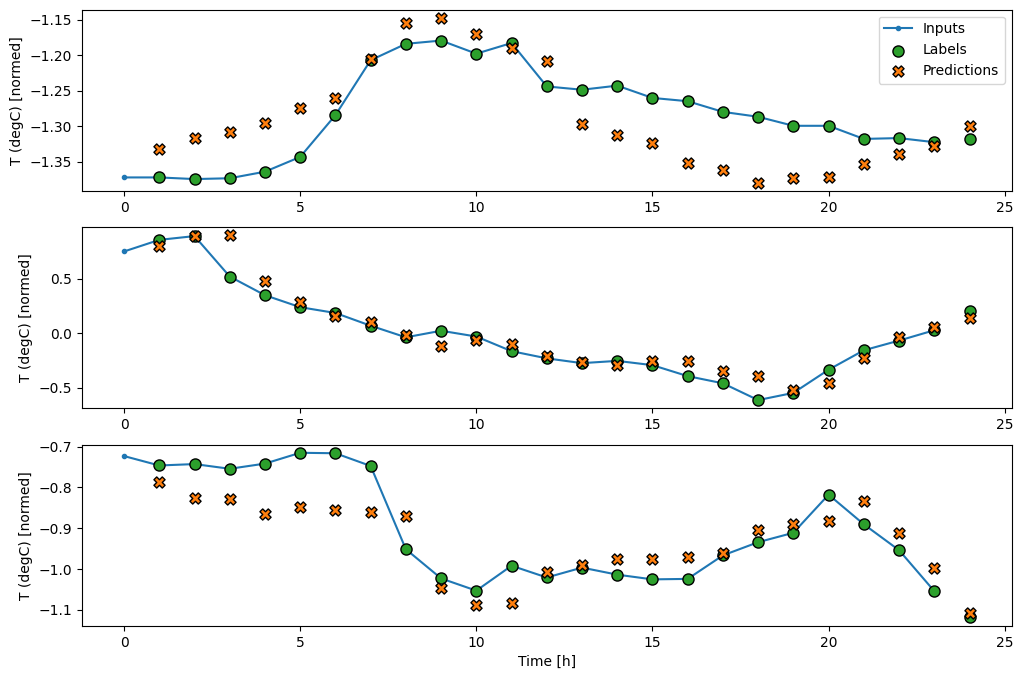

In [44]:
wide_window.plot(linear)

선형 모델의 한 가지 장점은 해석하기가 상대적으로 간단하다는 것입니다. 레이어의 가중치를 가져와 각 입력에 할당된 가중치를 시각화할 수 있습니다.

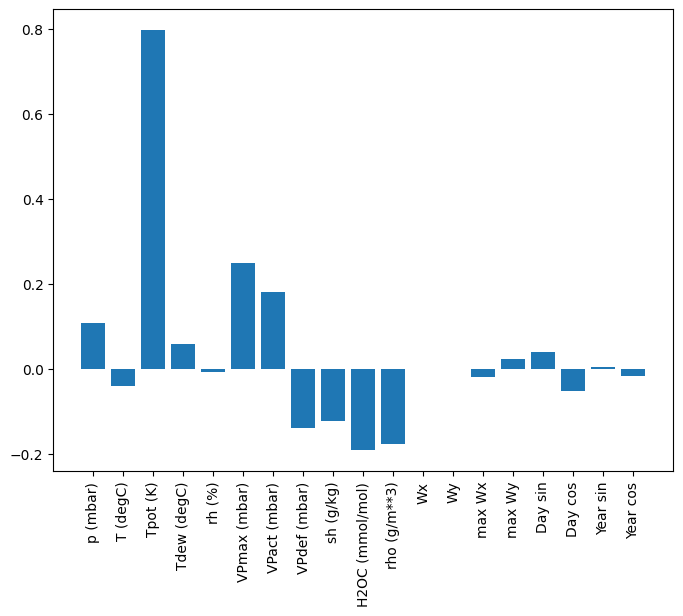

In [45]:
plt.bar(x = range(len(train_df.columns)),
        height=linear.layers[0].kernel[:,0].numpy())
axis = plt.gca()
axis.set_xticks(range(len(train_df.columns)))
_ = axis.set_xticklabels(train_df.columns, rotation=90)

때로 모델은 입력 `T (degC)`에 가장 많은 가중치를 두지 않습니다. 이것은 무작위 초기화의 위험 중 하나입니다. 

### 밀집

실제로 여러 타임스텝에서 동작하는 모델을 적용하기 전에 더 깊고 강력한 단일 입력 스텝 모델의 성능을 확인하는 것이 좋습니다.

다음 모델은 입력과 출력 사이에 몇 개의 `Dense` 레이어를 쌓는다는 점을 제외하면 `linear` 모델과 유사합니다. 

In [46]:
dense = tf.keras.Sequential([
    tf.keras.layers.Dense(units=64, activation='relu'),
    tf.keras.layers.Dense(units=64, activation='relu'),
    tf.keras.layers.Dense(units=1)
])

history = compile_and_fit(dense, single_step_window)

val_performance['Dense'] = dense.evaluate(single_step_window.val)
performance['Dense'] = dense.evaluate(single_step_window.test, verbose=0)

Epoch 1/20


   1/1534 [..............................] - ETA: 35:16 - loss: 0.6807 - mean_absolute_error: 0.6755

  15/1534 [..............................] - ETA: 5s - loss: 0.2967 - mean_absolute_error: 0.3759   

  30/1534 [..............................] - ETA: 5s - loss: 0.1886 - mean_absolute_error: 0.2997

  45/1534 [..............................] - ETA: 5s - loss: 0.1394 - mean_absolute_error: 0.2513

  61/1534 [>.............................] - ETA: 5s - loss: 0.1089 - mean_absolute_error: 0.2167

  77/1534 [>.............................] - ETA: 4s - loss: 0.0905 - mean_absolute_error: 0.1945

  92/1534 [>.............................] - ETA: 4s - loss: 0.0786 - mean_absolute_error: 0.1789

 108/1534 [=>............................] - ETA: 4s - loss: 0.0693 - mean_absolute_error: 0.1667

 123/1534 [=>............................] - ETA: 4s - loss: 0.0623 - mean_absolute_error: 0.1571

 138/1534 [=>............................] - ETA: 4s - loss: 0.0573 - mean_absolute_error: 0.1500

 153/1534 [=>............................] - ETA: 4s - loss: 0.0529 - mean_absolute_error: 0.1439

 169/1534 [==>...........................] - ETA: 4s - loss: 0.0491 - mean_absolute_error: 0.1382

 184/1534 [==>...........................] - ETA: 4s - loss: 0.0462 - mean_absolute_error: 0.1342

 200/1534 [==>...........................] - ETA: 4s - loss: 0.0434 - mean_absolute_error: 0.1300

 215/1534 [===>..........................] - ETA: 4s - loss: 0.0411 - mean_absolute_error: 0.1264

 230/1534 [===>..........................] - ETA: 4s - loss: 0.0393 - mean_absolute_error: 0.1235

 246/1534 [===>..........................] - ETA: 4s - loss: 0.0376 - mean_absolute_error: 0.1211

 261/1534 [====>.........................] - ETA: 4s - loss: 0.0362 - mean_absolute_error: 0.1193

 277/1534 [====>.........................] - ETA: 4s - loss: 0.0347 - mean_absolute_error: 0.1171

 293/1534 [====>.........................] - ETA: 4s - loss: 0.0334 - mean_absolute_error: 0.1151

 308/1534 [=====>........................] - ETA: 4s - loss: 0.0324 - mean_absolute_error: 0.1135

 323/1534 [=====>........................] - ETA: 4s - loss: 0.0315 - mean_absolute_error: 0.1120

 338/1534 [=====>........................] - ETA: 4s - loss: 0.0306 - mean_absolute_error: 0.1106

 354/1534 [=====>........................] - ETA: 3s - loss: 0.0297 - mean_absolute_error: 0.1092

 369/1534 [======>.......................] - ETA: 3s - loss: 0.0289 - mean_absolute_error: 0.1079

 385/1534 [======>.......................] - ETA: 3s - loss: 0.0282 - mean_absolute_error: 0.1067

 400/1534 [======>.......................] - ETA: 3s - loss: 0.0276 - mean_absolute_error: 0.1057

 416/1534 [=======>......................] - ETA: 3s - loss: 0.0268 - mean_absolute_error: 0.1043

 432/1534 [=======>......................] - ETA: 3s - loss: 0.0262 - mean_absolute_error: 0.1031

 447/1534 [=======>......................] - ETA: 3s - loss: 0.0256 - mean_absolute_error: 0.1021

 462/1534 [========>.....................] - ETA: 3s - loss: 0.0251 - mean_absolute_error: 0.1012

 477/1534 [========>.....................] - ETA: 3s - loss: 0.0246 - mean_absolute_error: 0.1003

 492/1534 [========>.....................] - ETA: 3s - loss: 0.0242 - mean_absolute_error: 0.0995

 508/1534 [========>.....................] - ETA: 3s - loss: 0.0237 - mean_absolute_error: 0.0987

 523/1534 [=========>....................] - ETA: 3s - loss: 0.0233 - mean_absolute_error: 0.0979

 539/1534 [=========>....................] - ETA: 3s - loss: 0.0228 - mean_absolute_error: 0.0970

 555/1534 [=========>....................] - ETA: 3s - loss: 0.0225 - mean_absolute_error: 0.0963

 571/1534 [==========>...................] - ETA: 3s - loss: 0.0221 - mean_absolute_error: 0.0956

 587/1534 [==========>...................] - ETA: 3s - loss: 0.0218 - mean_absolute_error: 0.0950

 603/1534 [==========>...................] - ETA: 3s - loss: 0.0214 - mean_absolute_error: 0.0944

 618/1534 [===========>..................] - ETA: 3s - loss: 0.0211 - mean_absolute_error: 0.0938

 633/1534 [===========>..................] - ETA: 3s - loss: 0.0208 - mean_absolute_error: 0.0932

 648/1534 [===========>..................] - ETA: 2s - loss: 0.0205 - mean_absolute_error: 0.0927

 663/1534 [===========>..................] - ETA: 2s - loss: 0.0203 - mean_absolute_error: 0.0923

 679/1534 [============>.................] - ETA: 2s - loss: 0.0200 - mean_absolute_error: 0.0918

 695/1534 [============>.................] - ETA: 2s - loss: 0.0198 - mean_absolute_error: 0.0912

 711/1534 [============>.................] - ETA: 2s - loss: 0.0196 - mean_absolute_error: 0.0909

 727/1534 [=============>................] - ETA: 2s - loss: 0.0194 - mean_absolute_error: 0.0907

 742/1534 [=============>................] - ETA: 2s - loss: 0.0193 - mean_absolute_error: 0.0905

 758/1534 [=============>................] - ETA: 2s - loss: 0.0191 - mean_absolute_error: 0.0901

 774/1534 [==============>...............] - ETA: 2s - loss: 0.0189 - mean_absolute_error: 0.0897

 790/1534 [==============>...............] - ETA: 2s - loss: 0.0187 - mean_absolute_error: 0.0894

 806/1534 [==============>...............] - ETA: 2s - loss: 0.0185 - mean_absolute_error: 0.0890

 821/1534 [===============>..............] - ETA: 2s - loss: 0.0183 - mean_absolute_error: 0.0886

 837/1534 [===============>..............] - ETA: 2s - loss: 0.0181 - mean_absolute_error: 0.0882

 853/1534 [===============>..............] - ETA: 2s - loss: 0.0180 - mean_absolute_error: 0.0879

 869/1534 [===============>..............] - ETA: 2s - loss: 0.0178 - mean_absolute_error: 0.0875

 885/1534 [================>.............] - ETA: 2s - loss: 0.0176 - mean_absolute_error: 0.0872

 900/1534 [================>.............] - ETA: 2s - loss: 0.0175 - mean_absolute_error: 0.0869

 915/1534 [================>.............] - ETA: 2s - loss: 0.0174 - mean_absolute_error: 0.0866

 931/1534 [=================>............] - ETA: 2s - loss: 0.0172 - mean_absolute_error: 0.0863

 947/1534 [=================>............] - ETA: 1s - loss: 0.0171 - mean_absolute_error: 0.0861

 962/1534 [=================>............] - ETA: 1s - loss: 0.0170 - mean_absolute_error: 0.0859

 978/1534 [==================>...........] - ETA: 1s - loss: 0.0169 - mean_absolute_error: 0.0858

 994/1534 [==================>...........] - ETA: 1s - loss: 0.0168 - mean_absolute_error: 0.0856

1010/1534 [==================>...........] - ETA: 1s - loss: 0.0166 - mean_absolute_error: 0.0854

1026/1534 [===================>..........] - ETA: 1s - loss: 0.0165 - mean_absolute_error: 0.0851

1042/1534 [===================>..........] - ETA: 1s - loss: 0.0164 - mean_absolute_error: 0.0848

1058/1534 [===================>..........] - ETA: 1s - loss: 0.0163 - mean_absolute_error: 0.0846

1074/1534 [====================>.........] - ETA: 1s - loss: 0.0162 - mean_absolute_error: 0.0843

1089/1534 [====================>.........] - ETA: 1s - loss: 0.0160 - mean_absolute_error: 0.0840

1105/1534 [====================>.........] - ETA: 1s - loss: 0.0159 - mean_absolute_error: 0.0839

1121/1534 [====================>.........] - ETA: 1s - loss: 0.0158 - mean_absolute_error: 0.0836

1136/1534 [=====================>........] - ETA: 1s - loss: 0.0157 - mean_absolute_error: 0.0834

1151/1534 [=====================>........] - ETA: 1s - loss: 0.0156 - mean_absolute_error: 0.0832

1166/1534 [=====================>........] - ETA: 1s - loss: 0.0156 - mean_absolute_error: 0.0831

1182/1534 [======================>.......] - ETA: 1s - loss: 0.0155 - mean_absolute_error: 0.0830

1197/1534 [======================>.......] - ETA: 1s - loss: 0.0154 - mean_absolute_error: 0.0827

1212/1534 [======================>.......] - ETA: 1s - loss: 0.0153 - mean_absolute_error: 0.0825

1227/1534 [======================>.......] - ETA: 1s - loss: 0.0152 - mean_absolute_error: 0.0823

1243/1534 [=======================>......] - ETA: 0s - loss: 0.0151 - mean_absolute_error: 0.0821

1259/1534 [=======================>......] - ETA: 0s - loss: 0.0150 - mean_absolute_error: 0.0819

1275/1534 [=======================>......] - ETA: 0s - loss: 0.0149 - mean_absolute_error: 0.0816

1291/1534 [========================>.....] - ETA: 0s - loss: 0.0148 - mean_absolute_error: 0.0814

1307/1534 [========================>.....] - ETA: 0s - loss: 0.0147 - mean_absolute_error: 0.0812

1323/1534 [========================>.....] - ETA: 0s - loss: 0.0146 - mean_absolute_error: 0.0810

1339/1534 [=========================>....] - ETA: 0s - loss: 0.0146 - mean_absolute_error: 0.0809

1354/1534 [=========================>....] - ETA: 0s - loss: 0.0145 - mean_absolute_error: 0.0807

1369/1534 [=========================>....] - ETA: 0s - loss: 0.0144 - mean_absolute_error: 0.0806

1385/1534 [==========================>...] - ETA: 0s - loss: 0.0144 - mean_absolute_error: 0.0805

1400/1534 [==========================>...] - ETA: 0s - loss: 0.0143 - mean_absolute_error: 0.0804

1416/1534 [==========================>...] - ETA: 0s - loss: 0.0143 - mean_absolute_error: 0.0803

1431/1534 [==========================>...] - ETA: 0s - loss: 0.0142 - mean_absolute_error: 0.0801

1446/1534 [===========================>..] - ETA: 0s - loss: 0.0141 - mean_absolute_error: 0.0800

1461/1534 [===========================>..] - ETA: 0s - loss: 0.0141 - mean_absolute_error: 0.0799

1476/1534 [===========================>..] - ETA: 0s - loss: 0.0140 - mean_absolute_error: 0.0798

1491/1534 [============================>.] - ETA: 0s - loss: 0.0140 - mean_absolute_error: 0.0797

1506/1534 [============================>.] - ETA: 0s - loss: 0.0139 - mean_absolute_error: 0.0795

1522/1534 [============================>.] - ETA: 0s - loss: 0.0138 - mean_absolute_error: 0.0794

1534/1534 [==============================] - 8s 4ms/step - loss: 0.0138 - mean_absolute_error: 0.0793 - val_loss: 0.0085 - val_mean_absolute_error: 0.0693


Epoch 2/20


   1/1534 [..............................] - ETA: 40s - loss: 0.0088 - mean_absolute_error: 0.0709

  16/1534 [..............................] - ETA: 5s - loss: 0.0083 - mean_absolute_error: 0.0652 

  31/1534 [..............................] - ETA: 5s - loss: 0.0075 - mean_absolute_error: 0.0634

  47/1534 [..............................] - ETA: 5s - loss: 0.0076 - mean_absolute_error: 0.0637

  62/1534 [>.............................] - ETA: 4s - loss: 0.0079 - mean_absolute_error: 0.0640

  78/1534 [>.............................] - ETA: 4s - loss: 0.0080 - mean_absolute_error: 0.0635

  94/1534 [>.............................] - ETA: 4s - loss: 0.0080 - mean_absolute_error: 0.0637

 111/1534 [=>............................] - ETA: 4s - loss: 0.0080 - mean_absolute_error: 0.0639

 126/1534 [=>............................] - ETA: 4s - loss: 0.0079 - mean_absolute_error: 0.0632

 141/1534 [=>............................] - ETA: 4s - loss: 0.0082 - mean_absolute_error: 0.0642

 157/1534 [==>...........................] - ETA: 4s - loss: 0.0081 - mean_absolute_error: 0.0644

 173/1534 [==>...........................] - ETA: 4s - loss: 0.0081 - mean_absolute_error: 0.0645

 189/1534 [==>...........................] - ETA: 4s - loss: 0.0081 - mean_absolute_error: 0.0644

 205/1534 [===>..........................] - ETA: 4s - loss: 0.0080 - mean_absolute_error: 0.0646

 221/1534 [===>..........................] - ETA: 4s - loss: 0.0080 - mean_absolute_error: 0.0644

 237/1534 [===>..........................] - ETA: 4s - loss: 0.0081 - mean_absolute_error: 0.0646

 252/1534 [===>..........................] - ETA: 4s - loss: 0.0081 - mean_absolute_error: 0.0647

 268/1534 [====>.........................] - ETA: 4s - loss: 0.0081 - mean_absolute_error: 0.0649

 284/1534 [====>.........................] - ETA: 4s - loss: 0.0081 - mean_absolute_error: 0.0652

 299/1534 [====>.........................] - ETA: 4s - loss: 0.0080 - mean_absolute_error: 0.0650

 315/1534 [=====>........................] - ETA: 4s - loss: 0.0080 - mean_absolute_error: 0.0649

 331/1534 [=====>........................] - ETA: 3s - loss: 0.0081 - mean_absolute_error: 0.0653

 347/1534 [=====>........................] - ETA: 3s - loss: 0.0081 - mean_absolute_error: 0.0653

 363/1534 [======>.......................] - ETA: 3s - loss: 0.0082 - mean_absolute_error: 0.0657

 378/1534 [======>.......................] - ETA: 3s - loss: 0.0082 - mean_absolute_error: 0.0657

 394/1534 [======>.......................] - ETA: 3s - loss: 0.0082 - mean_absolute_error: 0.0657

 410/1534 [=======>......................] - ETA: 3s - loss: 0.0082 - mean_absolute_error: 0.0656

 426/1534 [=======>......................] - ETA: 3s - loss: 0.0081 - mean_absolute_error: 0.0654

 441/1534 [=======>......................] - ETA: 3s - loss: 0.0081 - mean_absolute_error: 0.0654

 456/1534 [=======>......................] - ETA: 3s - loss: 0.0081 - mean_absolute_error: 0.0655

 472/1534 [========>.....................] - ETA: 3s - loss: 0.0081 - mean_absolute_error: 0.0654

 487/1534 [========>.....................] - ETA: 3s - loss: 0.0081 - mean_absolute_error: 0.0654

 503/1534 [========>.....................] - ETA: 3s - loss: 0.0081 - mean_absolute_error: 0.0652

 518/1534 [=========>....................] - ETA: 3s - loss: 0.0080 - mean_absolute_error: 0.0652

 533/1534 [=========>....................] - ETA: 3s - loss: 0.0080 - mean_absolute_error: 0.0650

 549/1534 [=========>....................] - ETA: 3s - loss: 0.0080 - mean_absolute_error: 0.0650

 565/1534 [==========>...................] - ETA: 3s - loss: 0.0081 - mean_absolute_error: 0.0650

 581/1534 [==========>...................] - ETA: 3s - loss: 0.0081 - mean_absolute_error: 0.0651

 597/1534 [==========>...................] - ETA: 3s - loss: 0.0080 - mean_absolute_error: 0.0650

 612/1534 [==========>...................] - ETA: 3s - loss: 0.0080 - mean_absolute_error: 0.0648

 627/1534 [===========>..................] - ETA: 3s - loss: 0.0079 - mean_absolute_error: 0.0647

 642/1534 [===========>..................] - ETA: 2s - loss: 0.0080 - mean_absolute_error: 0.0649

 657/1534 [===========>..................] - ETA: 2s - loss: 0.0080 - mean_absolute_error: 0.0649

 672/1534 [============>.................] - ETA: 2s - loss: 0.0080 - mean_absolute_error: 0.0649

 687/1534 [============>.................] - ETA: 2s - loss: 0.0080 - mean_absolute_error: 0.0649

 702/1534 [============>.................] - ETA: 2s - loss: 0.0079 - mean_absolute_error: 0.0648

 717/1534 [=============>................] - ETA: 2s - loss: 0.0080 - mean_absolute_error: 0.0647

 732/1534 [=============>................] - ETA: 2s - loss: 0.0080 - mean_absolute_error: 0.0648

 747/1534 [=============>................] - ETA: 2s - loss: 0.0080 - mean_absolute_error: 0.0649

 763/1534 [=============>................] - ETA: 2s - loss: 0.0081 - mean_absolute_error: 0.0651

 778/1534 [==============>...............] - ETA: 2s - loss: 0.0081 - mean_absolute_error: 0.0651

 793/1534 [==============>...............] - ETA: 2s - loss: 0.0081 - mean_absolute_error: 0.0652

 808/1534 [==============>...............] - ETA: 2s - loss: 0.0081 - mean_absolute_error: 0.0651

 823/1534 [===============>..............] - ETA: 2s - loss: 0.0081 - mean_absolute_error: 0.0651

 838/1534 [===============>..............] - ETA: 2s - loss: 0.0081 - mean_absolute_error: 0.0651

 854/1534 [===============>..............] - ETA: 2s - loss: 0.0081 - mean_absolute_error: 0.0650

 870/1534 [================>.............] - ETA: 2s - loss: 0.0081 - mean_absolute_error: 0.0651

 885/1534 [================>.............] - ETA: 2s - loss: 0.0081 - mean_absolute_error: 0.0651

 900/1534 [================>.............] - ETA: 2s - loss: 0.0081 - mean_absolute_error: 0.0651

 916/1534 [================>.............] - ETA: 2s - loss: 0.0081 - mean_absolute_error: 0.0652

 931/1534 [=================>............] - ETA: 2s - loss: 0.0081 - mean_absolute_error: 0.0651

 946/1534 [=================>............] - ETA: 1s - loss: 0.0081 - mean_absolute_error: 0.0651

 961/1534 [=================>............] - ETA: 1s - loss: 0.0081 - mean_absolute_error: 0.0651

 976/1534 [==================>...........] - ETA: 1s - loss: 0.0081 - mean_absolute_error: 0.0651

 991/1534 [==================>...........] - ETA: 1s - loss: 0.0081 - mean_absolute_error: 0.0652

1006/1534 [==================>...........] - ETA: 1s - loss: 0.0081 - mean_absolute_error: 0.0652

1021/1534 [==================>...........] - ETA: 1s - loss: 0.0081 - mean_absolute_error: 0.0651

1037/1534 [===================>..........] - ETA: 1s - loss: 0.0081 - mean_absolute_error: 0.0651

1053/1534 [===================>..........] - ETA: 1s - loss: 0.0081 - mean_absolute_error: 0.0650

1069/1534 [===================>..........] - ETA: 1s - loss: 0.0081 - mean_absolute_error: 0.0651

1085/1534 [====================>.........] - ETA: 1s - loss: 0.0081 - mean_absolute_error: 0.0649

1101/1534 [====================>.........] - ETA: 1s - loss: 0.0080 - mean_absolute_error: 0.0649

1117/1534 [====================>.........] - ETA: 1s - loss: 0.0080 - mean_absolute_error: 0.0649

1133/1534 [=====================>........] - ETA: 1s - loss: 0.0080 - mean_absolute_error: 0.0648

1148/1534 [=====================>........] - ETA: 1s - loss: 0.0080 - mean_absolute_error: 0.0649

1163/1534 [=====================>........] - ETA: 1s - loss: 0.0081 - mean_absolute_error: 0.0650

1178/1534 [======================>.......] - ETA: 1s - loss: 0.0081 - mean_absolute_error: 0.0650

1193/1534 [======================>.......] - ETA: 1s - loss: 0.0081 - mean_absolute_error: 0.0650

1208/1534 [======================>.......] - ETA: 1s - loss: 0.0080 - mean_absolute_error: 0.0650

1223/1534 [======================>.......] - ETA: 1s - loss: 0.0080 - mean_absolute_error: 0.0649

1238/1534 [=======================>......] - ETA: 0s - loss: 0.0080 - mean_absolute_error: 0.0649

1253/1534 [=======================>......] - ETA: 0s - loss: 0.0080 - mean_absolute_error: 0.0649

1269/1534 [=======================>......] - ETA: 0s - loss: 0.0080 - mean_absolute_error: 0.0648

1284/1534 [========================>.....] - ETA: 0s - loss: 0.0080 - mean_absolute_error: 0.0647

1300/1534 [========================>.....] - ETA: 0s - loss: 0.0080 - mean_absolute_error: 0.0648

1316/1534 [========================>.....] - ETA: 0s - loss: 0.0080 - mean_absolute_error: 0.0647

1332/1534 [=========================>....] - ETA: 0s - loss: 0.0079 - mean_absolute_error: 0.0646

1348/1534 [=========================>....] - ETA: 0s - loss: 0.0080 - mean_absolute_error: 0.0647

1363/1534 [=========================>....] - ETA: 0s - loss: 0.0079 - mean_absolute_error: 0.0646

1378/1534 [=========================>....] - ETA: 0s - loss: 0.0079 - mean_absolute_error: 0.0646

1393/1534 [==========================>...] - ETA: 0s - loss: 0.0079 - mean_absolute_error: 0.0646

1409/1534 [==========================>...] - ETA: 0s - loss: 0.0079 - mean_absolute_error: 0.0646

1424/1534 [==========================>...] - ETA: 0s - loss: 0.0079 - mean_absolute_error: 0.0646

1439/1534 [===========================>..] - ETA: 0s - loss: 0.0079 - mean_absolute_error: 0.0647

1454/1534 [===========================>..] - ETA: 0s - loss: 0.0079 - mean_absolute_error: 0.0647

1470/1534 [===========================>..] - ETA: 0s - loss: 0.0079 - mean_absolute_error: 0.0646

1485/1534 [============================>.] - ETA: 0s - loss: 0.0079 - mean_absolute_error: 0.0646

1501/1534 [============================>.] - ETA: 0s - loss: 0.0079 - mean_absolute_error: 0.0646

1517/1534 [============================>.] - ETA: 0s - loss: 0.0079 - mean_absolute_error: 0.0646

1533/1534 [============================>.] - ETA: 0s - loss: 0.0079 - mean_absolute_error: 0.0645

1534/1534 [==============================] - 6s 4ms/step - loss: 0.0079 - mean_absolute_error: 0.0645 - val_loss: 0.0075 - val_mean_absolute_error: 0.0638


Epoch 3/20


   1/1534 [..............................] - ETA: 40s - loss: 0.0061 - mean_absolute_error: 0.0632

  16/1534 [..............................] - ETA: 5s - loss: 0.0077 - mean_absolute_error: 0.0668 

  31/1534 [..............................] - ETA: 5s - loss: 0.0069 - mean_absolute_error: 0.0624

  47/1534 [..............................] - ETA: 5s - loss: 0.0077 - mean_absolute_error: 0.0635

  63/1534 [>.............................] - ETA: 4s - loss: 0.0078 - mean_absolute_error: 0.0641

  78/1534 [>.............................] - ETA: 4s - loss: 0.0077 - mean_absolute_error: 0.0638

  94/1534 [>.............................] - ETA: 4s - loss: 0.0078 - mean_absolute_error: 0.0632

 111/1534 [=>............................] - ETA: 4s - loss: 0.0076 - mean_absolute_error: 0.0625

 127/1534 [=>............................] - ETA: 4s - loss: 0.0076 - mean_absolute_error: 0.0625

 143/1534 [=>............................] - ETA: 4s - loss: 0.0078 - mean_absolute_error: 0.0630

 159/1534 [==>...........................] - ETA: 4s - loss: 0.0078 - mean_absolute_error: 0.0631

 175/1534 [==>...........................] - ETA: 4s - loss: 0.0077 - mean_absolute_error: 0.0630

 191/1534 [==>...........................] - ETA: 4s - loss: 0.0078 - mean_absolute_error: 0.0633

 207/1534 [===>..........................] - ETA: 4s - loss: 0.0077 - mean_absolute_error: 0.0630

 223/1534 [===>..........................] - ETA: 4s - loss: 0.0077 - mean_absolute_error: 0.0626

 239/1534 [===>..........................] - ETA: 4s - loss: 0.0076 - mean_absolute_error: 0.0623

 255/1534 [===>..........................] - ETA: 4s - loss: 0.0076 - mean_absolute_error: 0.0625

 270/1534 [====>.........................] - ETA: 4s - loss: 0.0075 - mean_absolute_error: 0.0624

 286/1534 [====>.........................] - ETA: 4s - loss: 0.0075 - mean_absolute_error: 0.0624

 302/1534 [====>.........................] - ETA: 4s - loss: 0.0076 - mean_absolute_error: 0.0625

 318/1534 [=====>........................] - ETA: 3s - loss: 0.0076 - mean_absolute_error: 0.0628

 334/1534 [=====>........................] - ETA: 3s - loss: 0.0077 - mean_absolute_error: 0.0630

 349/1534 [=====>........................] - ETA: 3s - loss: 0.0077 - mean_absolute_error: 0.0630

 364/1534 [======>.......................] - ETA: 3s - loss: 0.0076 - mean_absolute_error: 0.0631

 380/1534 [======>.......................] - ETA: 3s - loss: 0.0077 - mean_absolute_error: 0.0631

 396/1534 [======>.......................] - ETA: 3s - loss: 0.0077 - mean_absolute_error: 0.0631

 412/1534 [=======>......................] - ETA: 3s - loss: 0.0076 - mean_absolute_error: 0.0630

 428/1534 [=======>......................] - ETA: 3s - loss: 0.0076 - mean_absolute_error: 0.0629

 444/1534 [=======>......................] - ETA: 3s - loss: 0.0076 - mean_absolute_error: 0.0629

 459/1534 [=======>......................] - ETA: 3s - loss: 0.0076 - mean_absolute_error: 0.0629

 475/1534 [========>.....................] - ETA: 3s - loss: 0.0076 - mean_absolute_error: 0.0629

 491/1534 [========>.....................] - ETA: 3s - loss: 0.0076 - mean_absolute_error: 0.0630

 507/1534 [========>.....................] - ETA: 3s - loss: 0.0076 - mean_absolute_error: 0.0630

 523/1534 [=========>....................] - ETA: 3s - loss: 0.0075 - mean_absolute_error: 0.0628

 538/1534 [=========>....................] - ETA: 3s - loss: 0.0076 - mean_absolute_error: 0.0627

 553/1534 [=========>....................] - ETA: 3s - loss: 0.0076 - mean_absolute_error: 0.0628

 569/1534 [==========>...................] - ETA: 3s - loss: 0.0075 - mean_absolute_error: 0.0627

 584/1534 [==========>...................] - ETA: 3s - loss: 0.0075 - mean_absolute_error: 0.0626

 599/1534 [==========>...................] - ETA: 3s - loss: 0.0075 - mean_absolute_error: 0.0625

 615/1534 [===========>..................] - ETA: 3s - loss: 0.0074 - mean_absolute_error: 0.0624

 630/1534 [===========>..................] - ETA: 2s - loss: 0.0074 - mean_absolute_error: 0.0623

 645/1534 [===========>..................] - ETA: 2s - loss: 0.0074 - mean_absolute_error: 0.0623

 660/1534 [===========>..................] - ETA: 2s - loss: 0.0074 - mean_absolute_error: 0.0624

 675/1534 [============>.................] - ETA: 2s - loss: 0.0074 - mean_absolute_error: 0.0624

 690/1534 [============>.................] - ETA: 2s - loss: 0.0074 - mean_absolute_error: 0.0624

 705/1534 [============>.................] - ETA: 2s - loss: 0.0075 - mean_absolute_error: 0.0624

 721/1534 [=============>................] - ETA: 2s - loss: 0.0074 - mean_absolute_error: 0.0623

 736/1534 [=============>................] - ETA: 2s - loss: 0.0075 - mean_absolute_error: 0.0624

 751/1534 [=============>................] - ETA: 2s - loss: 0.0076 - mean_absolute_error: 0.0626

 766/1534 [=============>................] - ETA: 2s - loss: 0.0076 - mean_absolute_error: 0.0626

 781/1534 [==============>...............] - ETA: 2s - loss: 0.0076 - mean_absolute_error: 0.0627

 796/1534 [==============>...............] - ETA: 2s - loss: 0.0076 - mean_absolute_error: 0.0628

 811/1534 [==============>...............] - ETA: 2s - loss: 0.0076 - mean_absolute_error: 0.0628

 826/1534 [===============>..............] - ETA: 2s - loss: 0.0076 - mean_absolute_error: 0.0628

 841/1534 [===============>..............] - ETA: 2s - loss: 0.0076 - mean_absolute_error: 0.0627

 856/1534 [===============>..............] - ETA: 2s - loss: 0.0076 - mean_absolute_error: 0.0627

 871/1534 [================>.............] - ETA: 2s - loss: 0.0076 - mean_absolute_error: 0.0627

 886/1534 [================>.............] - ETA: 2s - loss: 0.0076 - mean_absolute_error: 0.0627

 901/1534 [================>.............] - ETA: 2s - loss: 0.0076 - mean_absolute_error: 0.0627

 916/1534 [================>.............] - ETA: 2s - loss: 0.0076 - mean_absolute_error: 0.0627

 931/1534 [=================>............] - ETA: 2s - loss: 0.0076 - mean_absolute_error: 0.0627

 946/1534 [=================>............] - ETA: 1s - loss: 0.0076 - mean_absolute_error: 0.0628

 961/1534 [=================>............] - ETA: 1s - loss: 0.0076 - mean_absolute_error: 0.0628

 977/1534 [==================>...........] - ETA: 1s - loss: 0.0076 - mean_absolute_error: 0.0629

 992/1534 [==================>...........] - ETA: 1s - loss: 0.0077 - mean_absolute_error: 0.0630

1007/1534 [==================>...........] - ETA: 1s - loss: 0.0077 - mean_absolute_error: 0.0629

1023/1534 [===================>..........] - ETA: 1s - loss: 0.0077 - mean_absolute_error: 0.0630

1038/1534 [===================>..........] - ETA: 1s - loss: 0.0076 - mean_absolute_error: 0.0629

1053/1534 [===================>..........] - ETA: 1s - loss: 0.0076 - mean_absolute_error: 0.0628

1068/1534 [===================>..........] - ETA: 1s - loss: 0.0076 - mean_absolute_error: 0.0629

1083/1534 [====================>.........] - ETA: 1s - loss: 0.0076 - mean_absolute_error: 0.0628

1098/1534 [====================>.........] - ETA: 1s - loss: 0.0076 - mean_absolute_error: 0.0627

1114/1534 [====================>.........] - ETA: 1s - loss: 0.0076 - mean_absolute_error: 0.0627

1129/1534 [=====================>........] - ETA: 1s - loss: 0.0076 - mean_absolute_error: 0.0628

1144/1534 [=====================>........] - ETA: 1s - loss: 0.0076 - mean_absolute_error: 0.0628

1159/1534 [=====================>........] - ETA: 1s - loss: 0.0076 - mean_absolute_error: 0.0628

1175/1534 [=====================>........] - ETA: 1s - loss: 0.0076 - mean_absolute_error: 0.0628

1190/1534 [======================>.......] - ETA: 1s - loss: 0.0076 - mean_absolute_error: 0.0627

1205/1534 [======================>.......] - ETA: 1s - loss: 0.0076 - mean_absolute_error: 0.0627

1220/1534 [======================>.......] - ETA: 1s - loss: 0.0076 - mean_absolute_error: 0.0626

1236/1534 [=======================>......] - ETA: 0s - loss: 0.0076 - mean_absolute_error: 0.0626

1251/1534 [=======================>......] - ETA: 0s - loss: 0.0076 - mean_absolute_error: 0.0626

1267/1534 [=======================>......] - ETA: 0s - loss: 0.0075 - mean_absolute_error: 0.0625

1283/1534 [========================>.....] - ETA: 0s - loss: 0.0075 - mean_absolute_error: 0.0625

1299/1534 [========================>.....] - ETA: 0s - loss: 0.0075 - mean_absolute_error: 0.0625

1315/1534 [========================>.....] - ETA: 0s - loss: 0.0075 - mean_absolute_error: 0.0624

1331/1534 [=========================>....] - ETA: 0s - loss: 0.0075 - mean_absolute_error: 0.0624

1347/1534 [=========================>....] - ETA: 0s - loss: 0.0075 - mean_absolute_error: 0.0624

1363/1534 [=========================>....] - ETA: 0s - loss: 0.0075 - mean_absolute_error: 0.0624

1379/1534 [=========================>....] - ETA: 0s - loss: 0.0075 - mean_absolute_error: 0.0624

1395/1534 [==========================>...] - ETA: 0s - loss: 0.0075 - mean_absolute_error: 0.0624

1411/1534 [==========================>...] - ETA: 0s - loss: 0.0075 - mean_absolute_error: 0.0624

1427/1534 [==========================>...] - ETA: 0s - loss: 0.0075 - mean_absolute_error: 0.0624

1443/1534 [===========================>..] - ETA: 0s - loss: 0.0075 - mean_absolute_error: 0.0624

1459/1534 [===========================>..] - ETA: 0s - loss: 0.0075 - mean_absolute_error: 0.0624

1475/1534 [===========================>..] - ETA: 0s - loss: 0.0075 - mean_absolute_error: 0.0624

1491/1534 [============================>.] - ETA: 0s - loss: 0.0075 - mean_absolute_error: 0.0624

1507/1534 [============================>.] - ETA: 0s - loss: 0.0075 - mean_absolute_error: 0.0623

1523/1534 [============================>.] - ETA: 0s - loss: 0.0075 - mean_absolute_error: 0.0623

1534/1534 [==============================] - 6s 4ms/step - loss: 0.0075 - mean_absolute_error: 0.0623 - val_loss: 0.0077 - val_mean_absolute_error: 0.0618


Epoch 4/20


   1/1534 [..............................] - ETA: 43s - loss: 0.0045 - mean_absolute_error: 0.0550

  15/1534 [..............................] - ETA: 5s - loss: 0.0070 - mean_absolute_error: 0.0630 

  30/1534 [..............................] - ETA: 5s - loss: 0.0065 - mean_absolute_error: 0.0603

  45/1534 [..............................] - ETA: 5s - loss: 0.0073 - mean_absolute_error: 0.0626

  61/1534 [>.............................] - ETA: 5s - loss: 0.0075 - mean_absolute_error: 0.0628

  76/1534 [>.............................] - ETA: 4s - loss: 0.0074 - mean_absolute_error: 0.0619

  92/1534 [>.............................] - ETA: 4s - loss: 0.0074 - mean_absolute_error: 0.0617

 109/1534 [=>............................] - ETA: 4s - loss: 0.0074 - mean_absolute_error: 0.0617

 125/1534 [=>............................] - ETA: 4s - loss: 0.0074 - mean_absolute_error: 0.0618

 141/1534 [=>............................] - ETA: 4s - loss: 0.0075 - mean_absolute_error: 0.0621

 156/1534 [==>...........................] - ETA: 4s - loss: 0.0076 - mean_absolute_error: 0.0624

 172/1534 [==>...........................] - ETA: 4s - loss: 0.0076 - mean_absolute_error: 0.0625

 188/1534 [==>...........................] - ETA: 4s - loss: 0.0075 - mean_absolute_error: 0.0622

 204/1534 [==>...........................] - ETA: 4s - loss: 0.0074 - mean_absolute_error: 0.0617

 220/1534 [===>..........................] - ETA: 4s - loss: 0.0073 - mean_absolute_error: 0.0613

 235/1534 [===>..........................] - ETA: 4s - loss: 0.0073 - mean_absolute_error: 0.0612

 250/1534 [===>..........................] - ETA: 4s - loss: 0.0073 - mean_absolute_error: 0.0612

 266/1534 [====>.........................] - ETA: 4s - loss: 0.0073 - mean_absolute_error: 0.0613

 282/1534 [====>.........................] - ETA: 4s - loss: 0.0073 - mean_absolute_error: 0.0611

 298/1534 [====>.........................] - ETA: 4s - loss: 0.0073 - mean_absolute_error: 0.0613

 314/1534 [=====>........................] - ETA: 4s - loss: 0.0074 - mean_absolute_error: 0.0614

 329/1534 [=====>........................] - ETA: 3s - loss: 0.0074 - mean_absolute_error: 0.0616

 344/1534 [=====>........................] - ETA: 3s - loss: 0.0073 - mean_absolute_error: 0.0615

 359/1534 [======>.......................] - ETA: 3s - loss: 0.0074 - mean_absolute_error: 0.0615

 375/1534 [======>.......................] - ETA: 3s - loss: 0.0074 - mean_absolute_error: 0.0617

 391/1534 [======>.......................] - ETA: 3s - loss: 0.0074 - mean_absolute_error: 0.0617

 407/1534 [======>.......................] - ETA: 3s - loss: 0.0074 - mean_absolute_error: 0.0616

 423/1534 [=======>......................] - ETA: 3s - loss: 0.0074 - mean_absolute_error: 0.0615

 439/1534 [=======>......................] - ETA: 3s - loss: 0.0074 - mean_absolute_error: 0.0617

 455/1534 [=======>......................] - ETA: 3s - loss: 0.0074 - mean_absolute_error: 0.0617

 471/1534 [========>.....................] - ETA: 3s - loss: 0.0074 - mean_absolute_error: 0.0617

 487/1534 [========>.....................] - ETA: 3s - loss: 0.0074 - mean_absolute_error: 0.0618

 503/1534 [========>.....................] - ETA: 3s - loss: 0.0074 - mean_absolute_error: 0.0617

 519/1534 [=========>....................] - ETA: 3s - loss: 0.0073 - mean_absolute_error: 0.0615

 535/1534 [=========>....................] - ETA: 3s - loss: 0.0073 - mean_absolute_error: 0.0614

 551/1534 [=========>....................] - ETA: 3s - loss: 0.0073 - mean_absolute_error: 0.0614

 566/1534 [==========>...................] - ETA: 3s - loss: 0.0073 - mean_absolute_error: 0.0614

 582/1534 [==========>...................] - ETA: 3s - loss: 0.0073 - mean_absolute_error: 0.0612

 598/1534 [==========>...................] - ETA: 3s - loss: 0.0072 - mean_absolute_error: 0.0612

 614/1534 [===========>..................] - ETA: 3s - loss: 0.0072 - mean_absolute_error: 0.0610

 630/1534 [===========>..................] - ETA: 2s - loss: 0.0072 - mean_absolute_error: 0.0609

 646/1534 [===========>..................] - ETA: 2s - loss: 0.0072 - mean_absolute_error: 0.0610

 662/1534 [===========>..................] - ETA: 2s - loss: 0.0072 - mean_absolute_error: 0.0611

 678/1534 [============>.................] - ETA: 2s - loss: 0.0072 - mean_absolute_error: 0.0610

 694/1534 [============>.................] - ETA: 2s - loss: 0.0072 - mean_absolute_error: 0.0610

 710/1534 [============>.................] - ETA: 2s - loss: 0.0072 - mean_absolute_error: 0.0611

 726/1534 [=============>................] - ETA: 2s - loss: 0.0072 - mean_absolute_error: 0.0610

 741/1534 [=============>................] - ETA: 2s - loss: 0.0073 - mean_absolute_error: 0.0611

 757/1534 [=============>................] - ETA: 2s - loss: 0.0073 - mean_absolute_error: 0.0611

 773/1534 [==============>...............] - ETA: 2s - loss: 0.0073 - mean_absolute_error: 0.0612

 789/1534 [==============>...............] - ETA: 2s - loss: 0.0073 - mean_absolute_error: 0.0613

 805/1534 [==============>...............] - ETA: 2s - loss: 0.0073 - mean_absolute_error: 0.0612

 821/1534 [===============>..............] - ETA: 2s - loss: 0.0073 - mean_absolute_error: 0.0611

 836/1534 [===============>..............] - ETA: 2s - loss: 0.0073 - mean_absolute_error: 0.0611

 851/1534 [===============>..............] - ETA: 2s - loss: 0.0073 - mean_absolute_error: 0.0612

 867/1534 [===============>..............] - ETA: 2s - loss: 0.0073 - mean_absolute_error: 0.0611

 882/1534 [================>.............] - ETA: 2s - loss: 0.0073 - mean_absolute_error: 0.0611

 897/1534 [================>.............] - ETA: 2s - loss: 0.0073 - mean_absolute_error: 0.0611

 912/1534 [================>.............] - ETA: 2s - loss: 0.0073 - mean_absolute_error: 0.0611

 927/1534 [=================>............] - ETA: 2s - loss: 0.0073 - mean_absolute_error: 0.0611

 943/1534 [=================>............] - ETA: 1s - loss: 0.0073 - mean_absolute_error: 0.0611

 958/1534 [=================>............] - ETA: 1s - loss: 0.0073 - mean_absolute_error: 0.0611

 974/1534 [==================>...........] - ETA: 1s - loss: 0.0073 - mean_absolute_error: 0.0611

 990/1534 [==================>...........] - ETA: 1s - loss: 0.0073 - mean_absolute_error: 0.0613

1005/1534 [==================>...........] - ETA: 1s - loss: 0.0074 - mean_absolute_error: 0.0613

1021/1534 [==================>...........] - ETA: 1s - loss: 0.0073 - mean_absolute_error: 0.0613

1037/1534 [===================>..........] - ETA: 1s - loss: 0.0074 - mean_absolute_error: 0.0614

1052/1534 [===================>..........] - ETA: 1s - loss: 0.0073 - mean_absolute_error: 0.0613

1067/1534 [===================>..........] - ETA: 1s - loss: 0.0074 - mean_absolute_error: 0.0613

1082/1534 [====================>.........] - ETA: 1s - loss: 0.0073 - mean_absolute_error: 0.0612

1098/1534 [====================>.........] - ETA: 1s - loss: 0.0073 - mean_absolute_error: 0.0612

1114/1534 [====================>.........] - ETA: 1s - loss: 0.0073 - mean_absolute_error: 0.0612

1130/1534 [=====================>........] - ETA: 1s - loss: 0.0073 - mean_absolute_error: 0.0612

1145/1534 [=====================>........] - ETA: 1s - loss: 0.0073 - mean_absolute_error: 0.0612

1161/1534 [=====================>........] - ETA: 1s - loss: 0.0073 - mean_absolute_error: 0.0613

1177/1534 [======================>.......] - ETA: 1s - loss: 0.0073 - mean_absolute_error: 0.0613

1192/1534 [======================>.......] - ETA: 1s - loss: 0.0073 - mean_absolute_error: 0.0612

1208/1534 [======================>.......] - ETA: 1s - loss: 0.0073 - mean_absolute_error: 0.0612

1224/1534 [======================>.......] - ETA: 1s - loss: 0.0073 - mean_absolute_error: 0.0611

1240/1534 [=======================>......] - ETA: 0s - loss: 0.0073 - mean_absolute_error: 0.0612

1255/1534 [=======================>......] - ETA: 0s - loss: 0.0073 - mean_absolute_error: 0.0612

1271/1534 [=======================>......] - ETA: 0s - loss: 0.0073 - mean_absolute_error: 0.0611

1286/1534 [========================>.....] - ETA: 0s - loss: 0.0073 - mean_absolute_error: 0.0610

1301/1534 [========================>.....] - ETA: 0s - loss: 0.0073 - mean_absolute_error: 0.0610

1317/1534 [========================>.....] - ETA: 0s - loss: 0.0072 - mean_absolute_error: 0.0610

1332/1534 [=========================>....] - ETA: 0s - loss: 0.0072 - mean_absolute_error: 0.0609

1347/1534 [=========================>....] - ETA: 0s - loss: 0.0072 - mean_absolute_error: 0.0609

1362/1534 [=========================>....] - ETA: 0s - loss: 0.0072 - mean_absolute_error: 0.0610

1377/1534 [=========================>....] - ETA: 0s - loss: 0.0072 - mean_absolute_error: 0.0610

1392/1534 [==========================>...] - ETA: 0s - loss: 0.0072 - mean_absolute_error: 0.0610

1407/1534 [==========================>...] - ETA: 0s - loss: 0.0072 - mean_absolute_error: 0.0610

1422/1534 [==========================>...] - ETA: 0s - loss: 0.0072 - mean_absolute_error: 0.0610

1437/1534 [===========================>..] - ETA: 0s - loss: 0.0072 - mean_absolute_error: 0.0610

1452/1534 [===========================>..] - ETA: 0s - loss: 0.0072 - mean_absolute_error: 0.0610

1467/1534 [===========================>..] - ETA: 0s - loss: 0.0072 - mean_absolute_error: 0.0610

1482/1534 [===========================>..] - ETA: 0s - loss: 0.0072 - mean_absolute_error: 0.0610

1498/1534 [============================>.] - ETA: 0s - loss: 0.0072 - mean_absolute_error: 0.0610

1513/1534 [============================>.] - ETA: 0s - loss: 0.0072 - mean_absolute_error: 0.0610

1528/1534 [============================>.] - ETA: 0s - loss: 0.0072 - mean_absolute_error: 0.0610

1534/1534 [==============================] - 6s 4ms/step - loss: 0.0072 - mean_absolute_error: 0.0610 - val_loss: 0.0072 - val_mean_absolute_error: 0.0620


Epoch 5/20


   1/1534 [..............................] - ETA: 41s - loss: 0.0043 - mean_absolute_error: 0.0524

  15/1534 [..............................] - ETA: 5s - loss: 0.0061 - mean_absolute_error: 0.0567 

  30/1534 [..............................] - ETA: 5s - loss: 0.0062 - mean_absolute_error: 0.0570

  45/1534 [..............................] - ETA: 5s - loss: 0.0067 - mean_absolute_error: 0.0588

  60/1534 [>.............................] - ETA: 5s - loss: 0.0068 - mean_absolute_error: 0.0587

  75/1534 [>.............................] - ETA: 5s - loss: 0.0070 - mean_absolute_error: 0.0587

  90/1534 [>.............................] - ETA: 4s - loss: 0.0070 - mean_absolute_error: 0.0588

 106/1534 [=>............................] - ETA: 4s - loss: 0.0069 - mean_absolute_error: 0.0586

 122/1534 [=>............................] - ETA: 4s - loss: 0.0069 - mean_absolute_error: 0.0584

 138/1534 [=>............................] - ETA: 4s - loss: 0.0069 - mean_absolute_error: 0.0587

 153/1534 [=>............................] - ETA: 4s - loss: 0.0071 - mean_absolute_error: 0.0593

 168/1534 [==>...........................] - ETA: 4s - loss: 0.0072 - mean_absolute_error: 0.0596

 183/1534 [==>...........................] - ETA: 4s - loss: 0.0072 - mean_absolute_error: 0.0596

 198/1534 [==>...........................] - ETA: 4s - loss: 0.0071 - mean_absolute_error: 0.0593

 213/1534 [===>..........................] - ETA: 4s - loss: 0.0070 - mean_absolute_error: 0.0588

 228/1534 [===>..........................] - ETA: 4s - loss: 0.0068 - mean_absolute_error: 0.0583

 243/1534 [===>..........................] - ETA: 4s - loss: 0.0069 - mean_absolute_error: 0.0584

 258/1534 [====>.........................] - ETA: 4s - loss: 0.0069 - mean_absolute_error: 0.0588

 273/1534 [====>.........................] - ETA: 4s - loss: 0.0069 - mean_absolute_error: 0.0588

 288/1534 [====>.........................] - ETA: 4s - loss: 0.0069 - mean_absolute_error: 0.0589

 303/1534 [====>.........................] - ETA: 4s - loss: 0.0069 - mean_absolute_error: 0.0590

 318/1534 [=====>........................] - ETA: 4s - loss: 0.0070 - mean_absolute_error: 0.0592

 333/1534 [=====>........................] - ETA: 4s - loss: 0.0070 - mean_absolute_error: 0.0593

 348/1534 [=====>........................] - ETA: 4s - loss: 0.0070 - mean_absolute_error: 0.0594

 363/1534 [======>.......................] - ETA: 3s - loss: 0.0070 - mean_absolute_error: 0.0594

 378/1534 [======>.......................] - ETA: 3s - loss: 0.0070 - mean_absolute_error: 0.0596

 393/1534 [======>.......................] - ETA: 3s - loss: 0.0070 - mean_absolute_error: 0.0596

 409/1534 [======>.......................] - ETA: 3s - loss: 0.0070 - mean_absolute_error: 0.0596

 425/1534 [=======>......................] - ETA: 3s - loss: 0.0070 - mean_absolute_error: 0.0595

 440/1534 [=======>......................] - ETA: 3s - loss: 0.0070 - mean_absolute_error: 0.0595

 455/1534 [=======>......................] - ETA: 3s - loss: 0.0070 - mean_absolute_error: 0.0596

 471/1534 [========>.....................] - ETA: 3s - loss: 0.0070 - mean_absolute_error: 0.0597

 487/1534 [========>.....................] - ETA: 3s - loss: 0.0070 - mean_absolute_error: 0.0597

 502/1534 [========>.....................] - ETA: 3s - loss: 0.0070 - mean_absolute_error: 0.0596

 518/1534 [=========>....................] - ETA: 3s - loss: 0.0070 - mean_absolute_error: 0.0596

 534/1534 [=========>....................] - ETA: 3s - loss: 0.0070 - mean_absolute_error: 0.0596

 550/1534 [=========>....................] - ETA: 3s - loss: 0.0070 - mean_absolute_error: 0.0595

 566/1534 [==========>...................] - ETA: 3s - loss: 0.0069 - mean_absolute_error: 0.0595

 581/1534 [==========>...................] - ETA: 3s - loss: 0.0070 - mean_absolute_error: 0.0595

 597/1534 [==========>...................] - ETA: 3s - loss: 0.0069 - mean_absolute_error: 0.0594

 613/1534 [==========>...................] - ETA: 3s - loss: 0.0069 - mean_absolute_error: 0.0593

 629/1534 [===========>..................] - ETA: 3s - loss: 0.0069 - mean_absolute_error: 0.0592

 645/1534 [===========>..................] - ETA: 2s - loss: 0.0069 - mean_absolute_error: 0.0593

 661/1534 [===========>..................] - ETA: 2s - loss: 0.0069 - mean_absolute_error: 0.0593

 676/1534 [============>.................] - ETA: 2s - loss: 0.0069 - mean_absolute_error: 0.0593

 692/1534 [============>.................] - ETA: 2s - loss: 0.0069 - mean_absolute_error: 0.0592

 707/1534 [============>.................] - ETA: 2s - loss: 0.0069 - mean_absolute_error: 0.0593

 723/1534 [=============>................] - ETA: 2s - loss: 0.0069 - mean_absolute_error: 0.0594

 739/1534 [=============>................] - ETA: 2s - loss: 0.0070 - mean_absolute_error: 0.0594

 755/1534 [=============>................] - ETA: 2s - loss: 0.0070 - mean_absolute_error: 0.0596

 771/1534 [==============>...............] - ETA: 2s - loss: 0.0070 - mean_absolute_error: 0.0597

 786/1534 [==============>...............] - ETA: 2s - loss: 0.0071 - mean_absolute_error: 0.0598

 801/1534 [==============>...............] - ETA: 2s - loss: 0.0070 - mean_absolute_error: 0.0597

 817/1534 [==============>...............] - ETA: 2s - loss: 0.0070 - mean_absolute_error: 0.0597

 833/1534 [===============>..............] - ETA: 2s - loss: 0.0070 - mean_absolute_error: 0.0598

 849/1534 [===============>..............] - ETA: 2s - loss: 0.0070 - mean_absolute_error: 0.0597

 864/1534 [===============>..............] - ETA: 2s - loss: 0.0070 - mean_absolute_error: 0.0598

 879/1534 [================>.............] - ETA: 2s - loss: 0.0071 - mean_absolute_error: 0.0598

 894/1534 [================>.............] - ETA: 2s - loss: 0.0071 - mean_absolute_error: 0.0598

 909/1534 [================>.............] - ETA: 2s - loss: 0.0071 - mean_absolute_error: 0.0599

 924/1534 [=================>............] - ETA: 2s - loss: 0.0071 - mean_absolute_error: 0.0599

 939/1534 [=================>............] - ETA: 1s - loss: 0.0071 - mean_absolute_error: 0.0599

 955/1534 [=================>............] - ETA: 1s - loss: 0.0071 - mean_absolute_error: 0.0599

 971/1534 [=================>............] - ETA: 1s - loss: 0.0071 - mean_absolute_error: 0.0599

 987/1534 [==================>...........] - ETA: 1s - loss: 0.0071 - mean_absolute_error: 0.0600

1003/1534 [==================>...........] - ETA: 1s - loss: 0.0071 - mean_absolute_error: 0.0601

1019/1534 [==================>...........] - ETA: 1s - loss: 0.0072 - mean_absolute_error: 0.0601

1035/1534 [===================>..........] - ETA: 1s - loss: 0.0071 - mean_absolute_error: 0.0600

1050/1534 [===================>..........] - ETA: 1s - loss: 0.0071 - mean_absolute_error: 0.0600

1065/1534 [===================>..........] - ETA: 1s - loss: 0.0071 - mean_absolute_error: 0.0601

1081/1534 [====================>.........] - ETA: 1s - loss: 0.0071 - mean_absolute_error: 0.0600

1096/1534 [====================>.........] - ETA: 1s - loss: 0.0071 - mean_absolute_error: 0.0600

1111/1534 [====================>.........] - ETA: 1s - loss: 0.0071 - mean_absolute_error: 0.0600

1126/1534 [=====================>........] - ETA: 1s - loss: 0.0071 - mean_absolute_error: 0.0601

1141/1534 [=====================>........] - ETA: 1s - loss: 0.0071 - mean_absolute_error: 0.0602

1156/1534 [=====================>........] - ETA: 1s - loss: 0.0071 - mean_absolute_error: 0.0602

1171/1534 [=====================>........] - ETA: 1s - loss: 0.0071 - mean_absolute_error: 0.0603

1186/1534 [======================>.......] - ETA: 1s - loss: 0.0072 - mean_absolute_error: 0.0603

1201/1534 [======================>.......] - ETA: 1s - loss: 0.0071 - mean_absolute_error: 0.0602

1216/1534 [======================>.......] - ETA: 1s - loss: 0.0071 - mean_absolute_error: 0.0602

1231/1534 [=======================>......] - ETA: 1s - loss: 0.0071 - mean_absolute_error: 0.0602

1246/1534 [=======================>......] - ETA: 0s - loss: 0.0071 - mean_absolute_error: 0.0602

1261/1534 [=======================>......] - ETA: 0s - loss: 0.0071 - mean_absolute_error: 0.0602

1276/1534 [=======================>......] - ETA: 0s - loss: 0.0071 - mean_absolute_error: 0.0601

1291/1534 [========================>.....] - ETA: 0s - loss: 0.0071 - mean_absolute_error: 0.0600

1307/1534 [========================>.....] - ETA: 0s - loss: 0.0071 - mean_absolute_error: 0.0600

1322/1534 [========================>.....] - ETA: 0s - loss: 0.0071 - mean_absolute_error: 0.0600

1337/1534 [=========================>....] - ETA: 0s - loss: 0.0070 - mean_absolute_error: 0.0599

1352/1534 [=========================>....] - ETA: 0s - loss: 0.0071 - mean_absolute_error: 0.0600

1367/1534 [=========================>....] - ETA: 0s - loss: 0.0071 - mean_absolute_error: 0.0600

1382/1534 [==========================>...] - ETA: 0s - loss: 0.0070 - mean_absolute_error: 0.0599

1397/1534 [==========================>...] - ETA: 0s - loss: 0.0070 - mean_absolute_error: 0.0599

1412/1534 [==========================>...] - ETA: 0s - loss: 0.0071 - mean_absolute_error: 0.0600

1427/1534 [==========================>...] - ETA: 0s - loss: 0.0071 - mean_absolute_error: 0.0600

1442/1534 [===========================>..] - ETA: 0s - loss: 0.0071 - mean_absolute_error: 0.0600

1457/1534 [===========================>..] - ETA: 0s - loss: 0.0071 - mean_absolute_error: 0.0600

1473/1534 [===========================>..] - ETA: 0s - loss: 0.0070 - mean_absolute_error: 0.0600

1488/1534 [============================>.] - ETA: 0s - loss: 0.0070 - mean_absolute_error: 0.0600

1503/1534 [============================>.] - ETA: 0s - loss: 0.0070 - mean_absolute_error: 0.0599

1519/1534 [============================>.] - ETA: 0s - loss: 0.0070 - mean_absolute_error: 0.0599

1534/1534 [==============================] - 6s 4ms/step - loss: 0.0070 - mean_absolute_error: 0.0599 - val_loss: 0.0070 - val_mean_absolute_error: 0.0600


Epoch 6/20


   1/1534 [..............................] - ETA: 44s - loss: 0.0054 - mean_absolute_error: 0.0581

  15/1534 [..............................] - ETA: 5s - loss: 0.0069 - mean_absolute_error: 0.0600 

  30/1534 [..............................] - ETA: 5s - loss: 0.0065 - mean_absolute_error: 0.0590

  45/1534 [..............................] - ETA: 5s - loss: 0.0069 - mean_absolute_error: 0.0588

  61/1534 [>.............................] - ETA: 5s - loss: 0.0069 - mean_absolute_error: 0.0588

  77/1534 [>.............................] - ETA: 4s - loss: 0.0072 - mean_absolute_error: 0.0589

  93/1534 [>.............................] - ETA: 4s - loss: 0.0071 - mean_absolute_error: 0.0593

 110/1534 [=>............................] - ETA: 4s - loss: 0.0070 - mean_absolute_error: 0.0590

 126/1534 [=>............................] - ETA: 4s - loss: 0.0070 - mean_absolute_error: 0.0588

 142/1534 [=>............................] - ETA: 4s - loss: 0.0072 - mean_absolute_error: 0.0595

 157/1534 [==>...........................] - ETA: 4s - loss: 0.0072 - mean_absolute_error: 0.0598

 173/1534 [==>...........................] - ETA: 4s - loss: 0.0071 - mean_absolute_error: 0.0598

 189/1534 [==>...........................] - ETA: 4s - loss: 0.0071 - mean_absolute_error: 0.0595

 205/1534 [===>..........................] - ETA: 4s - loss: 0.0070 - mean_absolute_error: 0.0592

 220/1534 [===>..........................] - ETA: 4s - loss: 0.0069 - mean_absolute_error: 0.0587

 236/1534 [===>..........................] - ETA: 4s - loss: 0.0069 - mean_absolute_error: 0.0588

 252/1534 [===>..........................] - ETA: 4s - loss: 0.0070 - mean_absolute_error: 0.0592

 267/1534 [====>.........................] - ETA: 4s - loss: 0.0071 - mean_absolute_error: 0.0597

 283/1534 [====>.........................] - ETA: 4s - loss: 0.0071 - mean_absolute_error: 0.0597

 299/1534 [====>.........................] - ETA: 4s - loss: 0.0070 - mean_absolute_error: 0.0595

 315/1534 [=====>........................] - ETA: 4s - loss: 0.0071 - mean_absolute_error: 0.0596

 330/1534 [=====>........................] - ETA: 3s - loss: 0.0071 - mean_absolute_error: 0.0598

 346/1534 [=====>........................] - ETA: 3s - loss: 0.0071 - mean_absolute_error: 0.0597

 362/1534 [======>.......................] - ETA: 3s - loss: 0.0070 - mean_absolute_error: 0.0596

 378/1534 [======>.......................] - ETA: 3s - loss: 0.0071 - mean_absolute_error: 0.0597

 394/1534 [======>.......................] - ETA: 3s - loss: 0.0071 - mean_absolute_error: 0.0597

 410/1534 [=======>......................] - ETA: 3s - loss: 0.0071 - mean_absolute_error: 0.0597

 426/1534 [=======>......................] - ETA: 3s - loss: 0.0070 - mean_absolute_error: 0.0597

 442/1534 [=======>......................] - ETA: 3s - loss: 0.0071 - mean_absolute_error: 0.0598

 458/1534 [=======>......................] - ETA: 3s - loss: 0.0071 - mean_absolute_error: 0.0598

 474/1534 [========>.....................] - ETA: 3s - loss: 0.0071 - mean_absolute_error: 0.0599

 489/1534 [========>.....................] - ETA: 3s - loss: 0.0071 - mean_absolute_error: 0.0601

 504/1534 [========>.....................] - ETA: 3s - loss: 0.0071 - mean_absolute_error: 0.0602

 519/1534 [=========>....................] - ETA: 3s - loss: 0.0071 - mean_absolute_error: 0.0601

 534/1534 [=========>....................] - ETA: 3s - loss: 0.0071 - mean_absolute_error: 0.0601

 549/1534 [=========>....................] - ETA: 3s - loss: 0.0071 - mean_absolute_error: 0.0601

 564/1534 [==========>...................] - ETA: 3s - loss: 0.0071 - mean_absolute_error: 0.0601

 579/1534 [==========>...................] - ETA: 3s - loss: 0.0071 - mean_absolute_error: 0.0600

 594/1534 [==========>...................] - ETA: 3s - loss: 0.0070 - mean_absolute_error: 0.0600

 609/1534 [==========>...................] - ETA: 3s - loss: 0.0070 - mean_absolute_error: 0.0600

 625/1534 [===========>..................] - ETA: 3s - loss: 0.0070 - mean_absolute_error: 0.0598

 641/1534 [===========>..................] - ETA: 2s - loss: 0.0070 - mean_absolute_error: 0.0600

 657/1534 [===========>..................] - ETA: 2s - loss: 0.0070 - mean_absolute_error: 0.0599

 673/1534 [============>.................] - ETA: 2s - loss: 0.0070 - mean_absolute_error: 0.0598

 689/1534 [============>.................] - ETA: 2s - loss: 0.0070 - mean_absolute_error: 0.0598

 704/1534 [============>.................] - ETA: 2s - loss: 0.0070 - mean_absolute_error: 0.0598

 719/1534 [=============>................] - ETA: 2s - loss: 0.0070 - mean_absolute_error: 0.0597

 734/1534 [=============>................] - ETA: 2s - loss: 0.0070 - mean_absolute_error: 0.0598

 750/1534 [=============>................] - ETA: 2s - loss: 0.0070 - mean_absolute_error: 0.0599

 765/1534 [=============>................] - ETA: 2s - loss: 0.0070 - mean_absolute_error: 0.0600

 780/1534 [==============>...............] - ETA: 2s - loss: 0.0071 - mean_absolute_error: 0.0600

 796/1534 [==============>...............] - ETA: 2s - loss: 0.0071 - mean_absolute_error: 0.0601

 811/1534 [==============>...............] - ETA: 2s - loss: 0.0071 - mean_absolute_error: 0.0600

 827/1534 [===============>..............] - ETA: 2s - loss: 0.0071 - mean_absolute_error: 0.0600

 843/1534 [===============>..............] - ETA: 2s - loss: 0.0071 - mean_absolute_error: 0.0600

 858/1534 [===============>..............] - ETA: 2s - loss: 0.0071 - mean_absolute_error: 0.0600

 874/1534 [================>.............] - ETA: 2s - loss: 0.0071 - mean_absolute_error: 0.0600

 890/1534 [================>.............] - ETA: 2s - loss: 0.0071 - mean_absolute_error: 0.0600

 906/1534 [================>.............] - ETA: 2s - loss: 0.0071 - mean_absolute_error: 0.0601

 922/1534 [=================>............] - ETA: 2s - loss: 0.0071 - mean_absolute_error: 0.0602

 938/1534 [=================>............] - ETA: 1s - loss: 0.0071 - mean_absolute_error: 0.0601

 954/1534 [=================>............] - ETA: 1s - loss: 0.0071 - mean_absolute_error: 0.0601

 970/1534 [=================>............] - ETA: 1s - loss: 0.0071 - mean_absolute_error: 0.0601

 985/1534 [==================>...........] - ETA: 1s - loss: 0.0072 - mean_absolute_error: 0.0603

1000/1534 [==================>...........] - ETA: 1s - loss: 0.0071 - mean_absolute_error: 0.0603

1016/1534 [==================>...........] - ETA: 1s - loss: 0.0072 - mean_absolute_error: 0.0603

1032/1534 [===================>..........] - ETA: 1s - loss: 0.0072 - mean_absolute_error: 0.0603

1048/1534 [===================>..........] - ETA: 1s - loss: 0.0071 - mean_absolute_error: 0.0603

1063/1534 [===================>..........] - ETA: 1s - loss: 0.0071 - mean_absolute_error: 0.0602

1079/1534 [====================>.........] - ETA: 1s - loss: 0.0071 - mean_absolute_error: 0.0602

1095/1534 [====================>.........] - ETA: 1s - loss: 0.0071 - mean_absolute_error: 0.0602

1110/1534 [====================>.........] - ETA: 1s - loss: 0.0071 - mean_absolute_error: 0.0601

1125/1534 [=====================>........] - ETA: 1s - loss: 0.0071 - mean_absolute_error: 0.0602

1140/1534 [=====================>........] - ETA: 1s - loss: 0.0071 - mean_absolute_error: 0.0602

1156/1534 [=====================>........] - ETA: 1s - loss: 0.0071 - mean_absolute_error: 0.0603

1171/1534 [=====================>........] - ETA: 1s - loss: 0.0071 - mean_absolute_error: 0.0602

1186/1534 [======================>.......] - ETA: 1s - loss: 0.0071 - mean_absolute_error: 0.0602

1202/1534 [======================>.......] - ETA: 1s - loss: 0.0071 - mean_absolute_error: 0.0602

1218/1534 [======================>.......] - ETA: 1s - loss: 0.0071 - mean_absolute_error: 0.0601

1234/1534 [=======================>......] - ETA: 0s - loss: 0.0071 - mean_absolute_error: 0.0602

1250/1534 [=======================>......] - ETA: 0s - loss: 0.0071 - mean_absolute_error: 0.0601

1266/1534 [=======================>......] - ETA: 0s - loss: 0.0071 - mean_absolute_error: 0.0601

1282/1534 [========================>.....] - ETA: 0s - loss: 0.0071 - mean_absolute_error: 0.0600

1298/1534 [========================>.....] - ETA: 0s - loss: 0.0071 - mean_absolute_error: 0.0600

1314/1534 [========================>.....] - ETA: 0s - loss: 0.0070 - mean_absolute_error: 0.0599

1329/1534 [========================>.....] - ETA: 0s - loss: 0.0070 - mean_absolute_error: 0.0599

1345/1534 [=========================>....] - ETA: 0s - loss: 0.0070 - mean_absolute_error: 0.0598

1361/1534 [=========================>....] - ETA: 0s - loss: 0.0070 - mean_absolute_error: 0.0599

1376/1534 [=========================>....] - ETA: 0s - loss: 0.0070 - mean_absolute_error: 0.0598

1392/1534 [==========================>...] - ETA: 0s - loss: 0.0070 - mean_absolute_error: 0.0599

1407/1534 [==========================>...] - ETA: 0s - loss: 0.0070 - mean_absolute_error: 0.0598

1423/1534 [==========================>...] - ETA: 0s - loss: 0.0070 - mean_absolute_error: 0.0599

1438/1534 [===========================>..] - ETA: 0s - loss: 0.0070 - mean_absolute_error: 0.0598

1454/1534 [===========================>..] - ETA: 0s - loss: 0.0070 - mean_absolute_error: 0.0598

1470/1534 [===========================>..] - ETA: 0s - loss: 0.0070 - mean_absolute_error: 0.0598

1486/1534 [============================>.] - ETA: 0s - loss: 0.0070 - mean_absolute_error: 0.0597

1502/1534 [============================>.] - ETA: 0s - loss: 0.0070 - mean_absolute_error: 0.0597

1518/1534 [============================>.] - ETA: 0s - loss: 0.0070 - mean_absolute_error: 0.0597

1534/1534 [==============================] - ETA: 0s - loss: 0.0070 - mean_absolute_error: 0.0597

1534/1534 [==============================] - 6s 4ms/step - loss: 0.0070 - mean_absolute_error: 0.0597 - val_loss: 0.0067 - val_mean_absolute_error: 0.0583


Epoch 7/20


   1/1534 [..............................] - ETA: 43s - loss: 0.0067 - mean_absolute_error: 0.0579

  15/1534 [..............................] - ETA: 5s - loss: 0.0071 - mean_absolute_error: 0.0616 

  30/1534 [..............................] - ETA: 5s - loss: 0.0063 - mean_absolute_error: 0.0581

  45/1534 [..............................] - ETA: 5s - loss: 0.0071 - mean_absolute_error: 0.0595

  61/1534 [>.............................] - ETA: 5s - loss: 0.0072 - mean_absolute_error: 0.0600

  77/1534 [>.............................] - ETA: 4s - loss: 0.0075 - mean_absolute_error: 0.0601

  93/1534 [>.............................] - ETA: 4s - loss: 0.0073 - mean_absolute_error: 0.0595

 110/1534 [=>............................] - ETA: 4s - loss: 0.0071 - mean_absolute_error: 0.0591

 126/1534 [=>............................] - ETA: 4s - loss: 0.0072 - mean_absolute_error: 0.0589

 141/1534 [=>............................] - ETA: 4s - loss: 0.0073 - mean_absolute_error: 0.0593

 157/1534 [==>...........................] - ETA: 4s - loss: 0.0072 - mean_absolute_error: 0.0593

 172/1534 [==>...........................] - ETA: 4s - loss: 0.0072 - mean_absolute_error: 0.0591

 187/1534 [==>...........................] - ETA: 4s - loss: 0.0072 - mean_absolute_error: 0.0590

 202/1534 [==>...........................] - ETA: 4s - loss: 0.0071 - mean_absolute_error: 0.0588

 218/1534 [===>..........................] - ETA: 4s - loss: 0.0069 - mean_absolute_error: 0.0582

 234/1534 [===>..........................] - ETA: 4s - loss: 0.0069 - mean_absolute_error: 0.0583

 250/1534 [===>..........................] - ETA: 4s - loss: 0.0070 - mean_absolute_error: 0.0586

 266/1534 [====>.........................] - ETA: 4s - loss: 0.0070 - mean_absolute_error: 0.0588

 282/1534 [====>.........................] - ETA: 4s - loss: 0.0069 - mean_absolute_error: 0.0587

 298/1534 [====>.........................] - ETA: 4s - loss: 0.0070 - mean_absolute_error: 0.0588

 313/1534 [=====>........................] - ETA: 4s - loss: 0.0070 - mean_absolute_error: 0.0589

 328/1534 [=====>........................] - ETA: 4s - loss: 0.0071 - mean_absolute_error: 0.0594

 344/1534 [=====>........................] - ETA: 3s - loss: 0.0071 - mean_absolute_error: 0.0595

 359/1534 [======>.......................] - ETA: 3s - loss: 0.0070 - mean_absolute_error: 0.0594

 374/1534 [======>.......................] - ETA: 3s - loss: 0.0071 - mean_absolute_error: 0.0597

 389/1534 [======>.......................] - ETA: 3s - loss: 0.0071 - mean_absolute_error: 0.0598

 404/1534 [======>.......................] - ETA: 3s - loss: 0.0072 - mean_absolute_error: 0.0599

 419/1534 [=======>......................] - ETA: 3s - loss: 0.0071 - mean_absolute_error: 0.0598

 434/1534 [=======>......................] - ETA: 3s - loss: 0.0071 - mean_absolute_error: 0.0598

 450/1534 [=======>......................] - ETA: 3s - loss: 0.0071 - mean_absolute_error: 0.0598

 465/1534 [========>.....................] - ETA: 3s - loss: 0.0071 - mean_absolute_error: 0.0598

 481/1534 [========>.....................] - ETA: 3s - loss: 0.0071 - mean_absolute_error: 0.0600

 496/1534 [========>.....................] - ETA: 3s - loss: 0.0071 - mean_absolute_error: 0.0600

 511/1534 [========>.....................] - ETA: 3s - loss: 0.0071 - mean_absolute_error: 0.0601

 526/1534 [=========>....................] - ETA: 3s - loss: 0.0070 - mean_absolute_error: 0.0598

 541/1534 [=========>....................] - ETA: 3s - loss: 0.0070 - mean_absolute_error: 0.0598

 556/1534 [=========>....................] - ETA: 3s - loss: 0.0070 - mean_absolute_error: 0.0598

 571/1534 [==========>...................] - ETA: 3s - loss: 0.0070 - mean_absolute_error: 0.0597

 586/1534 [==========>...................] - ETA: 3s - loss: 0.0070 - mean_absolute_error: 0.0596

 601/1534 [==========>...................] - ETA: 3s - loss: 0.0070 - mean_absolute_error: 0.0596

 616/1534 [===========>..................] - ETA: 3s - loss: 0.0069 - mean_absolute_error: 0.0595

 632/1534 [===========>..................] - ETA: 3s - loss: 0.0069 - mean_absolute_error: 0.0594

 647/1534 [===========>..................] - ETA: 2s - loss: 0.0069 - mean_absolute_error: 0.0595

 662/1534 [===========>..................] - ETA: 2s - loss: 0.0069 - mean_absolute_error: 0.0595

 677/1534 [============>.................] - ETA: 2s - loss: 0.0069 - mean_absolute_error: 0.0595

 692/1534 [============>.................] - ETA: 2s - loss: 0.0069 - mean_absolute_error: 0.0595

 707/1534 [============>.................] - ETA: 2s - loss: 0.0069 - mean_absolute_error: 0.0594

 722/1534 [=============>................] - ETA: 2s - loss: 0.0069 - mean_absolute_error: 0.0594

 737/1534 [=============>................] - ETA: 2s - loss: 0.0069 - mean_absolute_error: 0.0595

 752/1534 [=============>................] - ETA: 2s - loss: 0.0070 - mean_absolute_error: 0.0597

 767/1534 [==============>...............] - ETA: 2s - loss: 0.0070 - mean_absolute_error: 0.0597

 782/1534 [==============>...............] - ETA: 2s - loss: 0.0070 - mean_absolute_error: 0.0598

 797/1534 [==============>...............] - ETA: 2s - loss: 0.0070 - mean_absolute_error: 0.0597

 812/1534 [==============>...............] - ETA: 2s - loss: 0.0070 - mean_absolute_error: 0.0597

 828/1534 [===============>..............] - ETA: 2s - loss: 0.0070 - mean_absolute_error: 0.0597

 844/1534 [===============>..............] - ETA: 2s - loss: 0.0070 - mean_absolute_error: 0.0597

 859/1534 [===============>..............] - ETA: 2s - loss: 0.0070 - mean_absolute_error: 0.0597

 875/1534 [================>.............] - ETA: 2s - loss: 0.0070 - mean_absolute_error: 0.0596

 890/1534 [================>.............] - ETA: 2s - loss: 0.0070 - mean_absolute_error: 0.0597

 906/1534 [================>.............] - ETA: 2s - loss: 0.0070 - mean_absolute_error: 0.0597

 922/1534 [=================>............] - ETA: 2s - loss: 0.0070 - mean_absolute_error: 0.0597

 937/1534 [=================>............] - ETA: 2s - loss: 0.0070 - mean_absolute_error: 0.0598

 953/1534 [=================>............] - ETA: 1s - loss: 0.0070 - mean_absolute_error: 0.0598

 968/1534 [=================>............] - ETA: 1s - loss: 0.0070 - mean_absolute_error: 0.0597

 983/1534 [==================>...........] - ETA: 1s - loss: 0.0071 - mean_absolute_error: 0.0599

 998/1534 [==================>...........] - ETA: 1s - loss: 0.0071 - mean_absolute_error: 0.0600

1014/1534 [==================>...........] - ETA: 1s - loss: 0.0071 - mean_absolute_error: 0.0601

1029/1534 [===================>..........] - ETA: 1s - loss: 0.0071 - mean_absolute_error: 0.0601

1045/1534 [===================>..........] - ETA: 1s - loss: 0.0071 - mean_absolute_error: 0.0600

1060/1534 [===================>..........] - ETA: 1s - loss: 0.0071 - mean_absolute_error: 0.0600

1075/1534 [====================>.........] - ETA: 1s - loss: 0.0071 - mean_absolute_error: 0.0599

1090/1534 [====================>.........] - ETA: 1s - loss: 0.0071 - mean_absolute_error: 0.0599

1105/1534 [====================>.........] - ETA: 1s - loss: 0.0071 - mean_absolute_error: 0.0599

1120/1534 [====================>.........] - ETA: 1s - loss: 0.0071 - mean_absolute_error: 0.0599

1136/1534 [=====================>........] - ETA: 1s - loss: 0.0070 - mean_absolute_error: 0.0599

1152/1534 [=====================>........] - ETA: 1s - loss: 0.0071 - mean_absolute_error: 0.0599

1167/1534 [=====================>........] - ETA: 1s - loss: 0.0071 - mean_absolute_error: 0.0599

1183/1534 [======================>.......] - ETA: 1s - loss: 0.0071 - mean_absolute_error: 0.0598

1198/1534 [======================>.......] - ETA: 1s - loss: 0.0070 - mean_absolute_error: 0.0598

1213/1534 [======================>.......] - ETA: 1s - loss: 0.0070 - mean_absolute_error: 0.0597

1228/1534 [=======================>......] - ETA: 1s - loss: 0.0070 - mean_absolute_error: 0.0597

1243/1534 [=======================>......] - ETA: 0s - loss: 0.0070 - mean_absolute_error: 0.0597

1258/1534 [=======================>......] - ETA: 0s - loss: 0.0070 - mean_absolute_error: 0.0597

1273/1534 [=======================>......] - ETA: 0s - loss: 0.0070 - mean_absolute_error: 0.0596

1288/1534 [========================>.....] - ETA: 0s - loss: 0.0070 - mean_absolute_error: 0.0596

1303/1534 [========================>.....] - ETA: 0s - loss: 0.0070 - mean_absolute_error: 0.0596

1318/1534 [========================>.....] - ETA: 0s - loss: 0.0070 - mean_absolute_error: 0.0595

1333/1534 [=========================>....] - ETA: 0s - loss: 0.0070 - mean_absolute_error: 0.0595

1348/1534 [=========================>....] - ETA: 0s - loss: 0.0069 - mean_absolute_error: 0.0595

1363/1534 [=========================>....] - ETA: 0s - loss: 0.0069 - mean_absolute_error: 0.0595

1379/1534 [=========================>....] - ETA: 0s - loss: 0.0069 - mean_absolute_error: 0.0595

1394/1534 [==========================>...] - ETA: 0s - loss: 0.0069 - mean_absolute_error: 0.0594

1409/1534 [==========================>...] - ETA: 0s - loss: 0.0069 - mean_absolute_error: 0.0594

1425/1534 [==========================>...] - ETA: 0s - loss: 0.0070 - mean_absolute_error: 0.0594

1441/1534 [===========================>..] - ETA: 0s - loss: 0.0069 - mean_absolute_error: 0.0594

1457/1534 [===========================>..] - ETA: 0s - loss: 0.0069 - mean_absolute_error: 0.0594

1473/1534 [===========================>..] - ETA: 0s - loss: 0.0069 - mean_absolute_error: 0.0594

1488/1534 [============================>.] - ETA: 0s - loss: 0.0069 - mean_absolute_error: 0.0594

1503/1534 [============================>.] - ETA: 0s - loss: 0.0069 - mean_absolute_error: 0.0593

1518/1534 [============================>.] - ETA: 0s - loss: 0.0069 - mean_absolute_error: 0.0593

1534/1534 [==============================] - ETA: 0s - loss: 0.0069 - mean_absolute_error: 0.0593

1534/1534 [==============================] - 6s 4ms/step - loss: 0.0069 - mean_absolute_error: 0.0593 - val_loss: 0.0067 - val_mean_absolute_error: 0.0580


Epoch 8/20


   1/1534 [..............................] - ETA: 45s - loss: 0.0041 - mean_absolute_error: 0.0529

  15/1534 [..............................] - ETA: 5s - loss: 0.0064 - mean_absolute_error: 0.0602 

  29/1534 [..............................] - ETA: 5s - loss: 0.0063 - mean_absolute_error: 0.0585

  44/1534 [..............................] - ETA: 5s - loss: 0.0069 - mean_absolute_error: 0.0588

  59/1534 [>.............................] - ETA: 5s - loss: 0.0068 - mean_absolute_error: 0.0588

  75/1534 [>.............................] - ETA: 5s - loss: 0.0067 - mean_absolute_error: 0.0580

  90/1534 [>.............................] - ETA: 4s - loss: 0.0069 - mean_absolute_error: 0.0582

 106/1534 [=>............................] - ETA: 4s - loss: 0.0068 - mean_absolute_error: 0.0581

 121/1534 [=>............................] - ETA: 4s - loss: 0.0068 - mean_absolute_error: 0.0579

 136/1534 [=>............................] - ETA: 4s - loss: 0.0070 - mean_absolute_error: 0.0585

 151/1534 [=>............................] - ETA: 4s - loss: 0.0071 - mean_absolute_error: 0.0590

 166/1534 [==>...........................] - ETA: 4s - loss: 0.0071 - mean_absolute_error: 0.0590

 181/1534 [==>...........................] - ETA: 4s - loss: 0.0071 - mean_absolute_error: 0.0591

 196/1534 [==>...........................] - ETA: 4s - loss: 0.0070 - mean_absolute_error: 0.0587

 211/1534 [===>..........................] - ETA: 4s - loss: 0.0069 - mean_absolute_error: 0.0585

 226/1534 [===>..........................] - ETA: 4s - loss: 0.0068 - mean_absolute_error: 0.0581

 241/1534 [===>..........................] - ETA: 4s - loss: 0.0068 - mean_absolute_error: 0.0582

 256/1534 [====>.........................] - ETA: 4s - loss: 0.0068 - mean_absolute_error: 0.0584

 271/1534 [====>.........................] - ETA: 4s - loss: 0.0068 - mean_absolute_error: 0.0584

 286/1534 [====>.........................] - ETA: 4s - loss: 0.0068 - mean_absolute_error: 0.0584

 301/1534 [====>.........................] - ETA: 4s - loss: 0.0067 - mean_absolute_error: 0.0582

 316/1534 [=====>........................] - ETA: 4s - loss: 0.0068 - mean_absolute_error: 0.0585

 332/1534 [=====>........................] - ETA: 4s - loss: 0.0069 - mean_absolute_error: 0.0588

 348/1534 [=====>........................] - ETA: 4s - loss: 0.0068 - mean_absolute_error: 0.0587

 363/1534 [======>.......................] - ETA: 3s - loss: 0.0069 - mean_absolute_error: 0.0589

 379/1534 [======>.......................] - ETA: 3s - loss: 0.0069 - mean_absolute_error: 0.0589

 395/1534 [======>.......................] - ETA: 3s - loss: 0.0069 - mean_absolute_error: 0.0589

 411/1534 [=======>......................] - ETA: 3s - loss: 0.0069 - mean_absolute_error: 0.0591

 426/1534 [=======>......................] - ETA: 3s - loss: 0.0069 - mean_absolute_error: 0.0591

 442/1534 [=======>......................] - ETA: 3s - loss: 0.0069 - mean_absolute_error: 0.0591

 457/1534 [=======>......................] - ETA: 3s - loss: 0.0069 - mean_absolute_error: 0.0591

 472/1534 [========>.....................] - ETA: 3s - loss: 0.0069 - mean_absolute_error: 0.0591

 488/1534 [========>.....................] - ETA: 3s - loss: 0.0069 - mean_absolute_error: 0.0591

 503/1534 [========>.....................] - ETA: 3s - loss: 0.0069 - mean_absolute_error: 0.0592

 518/1534 [=========>....................] - ETA: 3s - loss: 0.0068 - mean_absolute_error: 0.0590

 533/1534 [=========>....................] - ETA: 3s - loss: 0.0068 - mean_absolute_error: 0.0590

 549/1534 [=========>....................] - ETA: 3s - loss: 0.0069 - mean_absolute_error: 0.0590

 565/1534 [==========>...................] - ETA: 3s - loss: 0.0069 - mean_absolute_error: 0.0590

 580/1534 [==========>...................] - ETA: 3s - loss: 0.0068 - mean_absolute_error: 0.0589

 595/1534 [==========>...................] - ETA: 3s - loss: 0.0068 - mean_absolute_error: 0.0588

 610/1534 [==========>...................] - ETA: 3s - loss: 0.0068 - mean_absolute_error: 0.0588

 626/1534 [===========>..................] - ETA: 3s - loss: 0.0068 - mean_absolute_error: 0.0587

 642/1534 [===========>..................] - ETA: 3s - loss: 0.0068 - mean_absolute_error: 0.0587

 658/1534 [===========>..................] - ETA: 2s - loss: 0.0068 - mean_absolute_error: 0.0587

 673/1534 [============>.................] - ETA: 2s - loss: 0.0068 - mean_absolute_error: 0.0587

 688/1534 [============>.................] - ETA: 2s - loss: 0.0068 - mean_absolute_error: 0.0586

 704/1534 [============>.................] - ETA: 2s - loss: 0.0068 - mean_absolute_error: 0.0586

 719/1534 [=============>................] - ETA: 2s - loss: 0.0068 - mean_absolute_error: 0.0586

 734/1534 [=============>................] - ETA: 2s - loss: 0.0068 - mean_absolute_error: 0.0586

 750/1534 [=============>................] - ETA: 2s - loss: 0.0068 - mean_absolute_error: 0.0587

 765/1534 [=============>................] - ETA: 2s - loss: 0.0069 - mean_absolute_error: 0.0588

 780/1534 [==============>...............] - ETA: 2s - loss: 0.0069 - mean_absolute_error: 0.0589

 796/1534 [==============>...............] - ETA: 2s - loss: 0.0069 - mean_absolute_error: 0.0589

 812/1534 [==============>...............] - ETA: 2s - loss: 0.0069 - mean_absolute_error: 0.0588

 828/1534 [===============>..............] - ETA: 2s - loss: 0.0068 - mean_absolute_error: 0.0587

 844/1534 [===============>..............] - ETA: 2s - loss: 0.0068 - mean_absolute_error: 0.0587

 860/1534 [===============>..............] - ETA: 2s - loss: 0.0068 - mean_absolute_error: 0.0587

 876/1534 [================>.............] - ETA: 2s - loss: 0.0069 - mean_absolute_error: 0.0588

 891/1534 [================>.............] - ETA: 2s - loss: 0.0068 - mean_absolute_error: 0.0587

 906/1534 [================>.............] - ETA: 2s - loss: 0.0069 - mean_absolute_error: 0.0587

 921/1534 [=================>............] - ETA: 2s - loss: 0.0069 - mean_absolute_error: 0.0587

 936/1534 [=================>............] - ETA: 2s - loss: 0.0068 - mean_absolute_error: 0.0587

 951/1534 [=================>............] - ETA: 1s - loss: 0.0069 - mean_absolute_error: 0.0588

 967/1534 [=================>............] - ETA: 1s - loss: 0.0069 - mean_absolute_error: 0.0588

 982/1534 [==================>...........] - ETA: 1s - loss: 0.0069 - mean_absolute_error: 0.0590

 997/1534 [==================>...........] - ETA: 1s - loss: 0.0069 - mean_absolute_error: 0.0590

1012/1534 [==================>...........] - ETA: 1s - loss: 0.0069 - mean_absolute_error: 0.0590

1028/1534 [===================>..........] - ETA: 1s - loss: 0.0069 - mean_absolute_error: 0.0590

1043/1534 [===================>..........] - ETA: 1s - loss: 0.0069 - mean_absolute_error: 0.0590

1059/1534 [===================>..........] - ETA: 1s - loss: 0.0069 - mean_absolute_error: 0.0591

1074/1534 [====================>.........] - ETA: 1s - loss: 0.0069 - mean_absolute_error: 0.0591

1090/1534 [====================>.........] - ETA: 1s - loss: 0.0069 - mean_absolute_error: 0.0590

1105/1534 [====================>.........] - ETA: 1s - loss: 0.0069 - mean_absolute_error: 0.0590

1120/1534 [====================>.........] - ETA: 1s - loss: 0.0069 - mean_absolute_error: 0.0591

1136/1534 [=====================>........] - ETA: 1s - loss: 0.0069 - mean_absolute_error: 0.0591

1152/1534 [=====================>........] - ETA: 1s - loss: 0.0069 - mean_absolute_error: 0.0591

1168/1534 [=====================>........] - ETA: 1s - loss: 0.0069 - mean_absolute_error: 0.0591

1183/1534 [======================>.......] - ETA: 1s - loss: 0.0069 - mean_absolute_error: 0.0591

1198/1534 [======================>.......] - ETA: 1s - loss: 0.0069 - mean_absolute_error: 0.0591

1214/1534 [======================>.......] - ETA: 1s - loss: 0.0069 - mean_absolute_error: 0.0590

1230/1534 [=======================>......] - ETA: 1s - loss: 0.0069 - mean_absolute_error: 0.0590

1246/1534 [=======================>......] - ETA: 0s - loss: 0.0069 - mean_absolute_error: 0.0590

1262/1534 [=======================>......] - ETA: 0s - loss: 0.0069 - mean_absolute_error: 0.0590

1277/1534 [=======================>......] - ETA: 0s - loss: 0.0069 - mean_absolute_error: 0.0589

1292/1534 [========================>.....] - ETA: 0s - loss: 0.0069 - mean_absolute_error: 0.0589

1307/1534 [========================>.....] - ETA: 0s - loss: 0.0068 - mean_absolute_error: 0.0589

1323/1534 [========================>.....] - ETA: 0s - loss: 0.0068 - mean_absolute_error: 0.0589

1339/1534 [=========================>....] - ETA: 0s - loss: 0.0068 - mean_absolute_error: 0.0589

1354/1534 [=========================>....] - ETA: 0s - loss: 0.0068 - mean_absolute_error: 0.0589

1370/1534 [=========================>....] - ETA: 0s - loss: 0.0068 - mean_absolute_error: 0.0588

1385/1534 [==========================>...] - ETA: 0s - loss: 0.0068 - mean_absolute_error: 0.0588

1400/1534 [==========================>...] - ETA: 0s - loss: 0.0068 - mean_absolute_error: 0.0589

1415/1534 [==========================>...] - ETA: 0s - loss: 0.0068 - mean_absolute_error: 0.0589

1431/1534 [==========================>...] - ETA: 0s - loss: 0.0068 - mean_absolute_error: 0.0589

1447/1534 [===========================>..] - ETA: 0s - loss: 0.0068 - mean_absolute_error: 0.0589

1462/1534 [===========================>..] - ETA: 0s - loss: 0.0068 - mean_absolute_error: 0.0589

1478/1534 [===========================>..] - ETA: 0s - loss: 0.0068 - mean_absolute_error: 0.0589

1494/1534 [============================>.] - ETA: 0s - loss: 0.0068 - mean_absolute_error: 0.0588

1510/1534 [============================>.] - ETA: 0s - loss: 0.0068 - mean_absolute_error: 0.0588

1526/1534 [============================>.] - ETA: 0s - loss: 0.0068 - mean_absolute_error: 0.0587

1534/1534 [==============================] - 6s 4ms/step - loss: 0.0068 - mean_absolute_error: 0.0587 - val_loss: 0.0068 - val_mean_absolute_error: 0.0578


Epoch 9/20


   1/1534 [..............................] - ETA: 42s - loss: 0.0086 - mean_absolute_error: 0.0612

  15/1534 [..............................] - ETA: 5s - loss: 0.0069 - mean_absolute_error: 0.0575 

  30/1534 [..............................] - ETA: 5s - loss: 0.0060 - mean_absolute_error: 0.0566

  45/1534 [..............................] - ETA: 5s - loss: 0.0068 - mean_absolute_error: 0.0582

  61/1534 [>.............................] - ETA: 5s - loss: 0.0070 - mean_absolute_error: 0.0588

  76/1534 [>.............................] - ETA: 4s - loss: 0.0070 - mean_absolute_error: 0.0583

  92/1534 [>.............................] - ETA: 4s - loss: 0.0069 - mean_absolute_error: 0.0582

 109/1534 [=>............................] - ETA: 4s - loss: 0.0069 - mean_absolute_error: 0.0582

 125/1534 [=>............................] - ETA: 4s - loss: 0.0071 - mean_absolute_error: 0.0587

 140/1534 [=>............................] - ETA: 4s - loss: 0.0072 - mean_absolute_error: 0.0589

 156/1534 [==>...........................] - ETA: 4s - loss: 0.0072 - mean_absolute_error: 0.0590

 172/1534 [==>...........................] - ETA: 4s - loss: 0.0071 - mean_absolute_error: 0.0588

 188/1534 [==>...........................] - ETA: 4s - loss: 0.0070 - mean_absolute_error: 0.0586

 204/1534 [==>...........................] - ETA: 4s - loss: 0.0069 - mean_absolute_error: 0.0583

 220/1534 [===>..........................] - ETA: 4s - loss: 0.0069 - mean_absolute_error: 0.0580

 235/1534 [===>..........................] - ETA: 4s - loss: 0.0069 - mean_absolute_error: 0.0580

 250/1534 [===>..........................] - ETA: 4s - loss: 0.0068 - mean_absolute_error: 0.0580

 265/1534 [====>.........................] - ETA: 4s - loss: 0.0069 - mean_absolute_error: 0.0581

 281/1534 [====>.........................] - ETA: 4s - loss: 0.0068 - mean_absolute_error: 0.0580

 296/1534 [====>.........................] - ETA: 4s - loss: 0.0067 - mean_absolute_error: 0.0577

 312/1534 [=====>........................] - ETA: 4s - loss: 0.0068 - mean_absolute_error: 0.0579

 327/1534 [=====>........................] - ETA: 4s - loss: 0.0068 - mean_absolute_error: 0.0581

 343/1534 [=====>........................] - ETA: 3s - loss: 0.0068 - mean_absolute_error: 0.0581

 358/1534 [======>.......................] - ETA: 3s - loss: 0.0068 - mean_absolute_error: 0.0582

 374/1534 [======>.......................] - ETA: 3s - loss: 0.0069 - mean_absolute_error: 0.0582

 389/1534 [======>.......................] - ETA: 3s - loss: 0.0069 - mean_absolute_error: 0.0583

 405/1534 [======>.......................] - ETA: 3s - loss: 0.0069 - mean_absolute_error: 0.0586

 421/1534 [=======>......................] - ETA: 3s - loss: 0.0069 - mean_absolute_error: 0.0588

 437/1534 [=======>......................] - ETA: 3s - loss: 0.0069 - mean_absolute_error: 0.0587

 453/1534 [=======>......................] - ETA: 3s - loss: 0.0069 - mean_absolute_error: 0.0586

 468/1534 [========>.....................] - ETA: 3s - loss: 0.0069 - mean_absolute_error: 0.0586

 484/1534 [========>.....................] - ETA: 3s - loss: 0.0069 - mean_absolute_error: 0.0588

 500/1534 [========>.....................] - ETA: 3s - loss: 0.0069 - mean_absolute_error: 0.0588

 516/1534 [=========>....................] - ETA: 3s - loss: 0.0069 - mean_absolute_error: 0.0586

 532/1534 [=========>....................] - ETA: 3s - loss: 0.0068 - mean_absolute_error: 0.0585

 547/1534 [=========>....................] - ETA: 3s - loss: 0.0068 - mean_absolute_error: 0.0585

 562/1534 [=========>....................] - ETA: 3s - loss: 0.0069 - mean_absolute_error: 0.0585

 578/1534 [==========>...................] - ETA: 3s - loss: 0.0068 - mean_absolute_error: 0.0584

 594/1534 [==========>...................] - ETA: 3s - loss: 0.0068 - mean_absolute_error: 0.0583

 610/1534 [==========>...................] - ETA: 3s - loss: 0.0068 - mean_absolute_error: 0.0582

 626/1534 [===========>..................] - ETA: 3s - loss: 0.0067 - mean_absolute_error: 0.0581

 642/1534 [===========>..................] - ETA: 2s - loss: 0.0067 - mean_absolute_error: 0.0581

 658/1534 [===========>..................] - ETA: 2s - loss: 0.0067 - mean_absolute_error: 0.0582

 674/1534 [============>.................] - ETA: 2s - loss: 0.0067 - mean_absolute_error: 0.0581

 690/1534 [============>.................] - ETA: 2s - loss: 0.0067 - mean_absolute_error: 0.0581

 706/1534 [============>.................] - ETA: 2s - loss: 0.0068 - mean_absolute_error: 0.0582

 722/1534 [=============>................] - ETA: 2s - loss: 0.0068 - mean_absolute_error: 0.0582

 738/1534 [=============>................] - ETA: 2s - loss: 0.0068 - mean_absolute_error: 0.0582

 753/1534 [=============>................] - ETA: 2s - loss: 0.0068 - mean_absolute_error: 0.0583

 769/1534 [==============>...............] - ETA: 2s - loss: 0.0068 - mean_absolute_error: 0.0583

 785/1534 [==============>...............] - ETA: 2s - loss: 0.0068 - mean_absolute_error: 0.0583

 800/1534 [==============>...............] - ETA: 2s - loss: 0.0068 - mean_absolute_error: 0.0584

 816/1534 [==============>...............] - ETA: 2s - loss: 0.0068 - mean_absolute_error: 0.0583

 832/1534 [===============>..............] - ETA: 2s - loss: 0.0068 - mean_absolute_error: 0.0583

 848/1534 [===============>..............] - ETA: 2s - loss: 0.0068 - mean_absolute_error: 0.0583

 864/1534 [===============>..............] - ETA: 2s - loss: 0.0068 - mean_absolute_error: 0.0583

 880/1534 [================>.............] - ETA: 2s - loss: 0.0068 - mean_absolute_error: 0.0582

 896/1534 [================>.............] - ETA: 2s - loss: 0.0068 - mean_absolute_error: 0.0583

 912/1534 [================>.............] - ETA: 2s - loss: 0.0068 - mean_absolute_error: 0.0583

 928/1534 [=================>............] - ETA: 1s - loss: 0.0068 - mean_absolute_error: 0.0583

 944/1534 [=================>............] - ETA: 1s - loss: 0.0068 - mean_absolute_error: 0.0583

 960/1534 [=================>............] - ETA: 1s - loss: 0.0068 - mean_absolute_error: 0.0583

 975/1534 [==================>...........] - ETA: 1s - loss: 0.0068 - mean_absolute_error: 0.0583

 991/1534 [==================>...........] - ETA: 1s - loss: 0.0069 - mean_absolute_error: 0.0585

1006/1534 [==================>...........] - ETA: 1s - loss: 0.0069 - mean_absolute_error: 0.0586

1021/1534 [==================>...........] - ETA: 1s - loss: 0.0069 - mean_absolute_error: 0.0586

1036/1534 [===================>..........] - ETA: 1s - loss: 0.0069 - mean_absolute_error: 0.0585

1052/1534 [===================>..........] - ETA: 1s - loss: 0.0069 - mean_absolute_error: 0.0585

1068/1534 [===================>..........] - ETA: 1s - loss: 0.0069 - mean_absolute_error: 0.0586

1084/1534 [====================>.........] - ETA: 1s - loss: 0.0068 - mean_absolute_error: 0.0585

1100/1534 [====================>.........] - ETA: 1s - loss: 0.0068 - mean_absolute_error: 0.0584

1116/1534 [====================>.........] - ETA: 1s - loss: 0.0068 - mean_absolute_error: 0.0585

1132/1534 [=====================>........] - ETA: 1s - loss: 0.0068 - mean_absolute_error: 0.0585

1148/1534 [=====================>........] - ETA: 1s - loss: 0.0068 - mean_absolute_error: 0.0585

1164/1534 [=====================>........] - ETA: 1s - loss: 0.0068 - mean_absolute_error: 0.0585

1180/1534 [======================>.......] - ETA: 1s - loss: 0.0069 - mean_absolute_error: 0.0585

1196/1534 [======================>.......] - ETA: 1s - loss: 0.0068 - mean_absolute_error: 0.0585

1212/1534 [======================>.......] - ETA: 1s - loss: 0.0068 - mean_absolute_error: 0.0584

1228/1534 [=======================>......] - ETA: 1s - loss: 0.0068 - mean_absolute_error: 0.0584

1244/1534 [=======================>......] - ETA: 0s - loss: 0.0068 - mean_absolute_error: 0.0584

1259/1534 [=======================>......] - ETA: 0s - loss: 0.0068 - mean_absolute_error: 0.0584

1274/1534 [=======================>......] - ETA: 0s - loss: 0.0068 - mean_absolute_error: 0.0583

1290/1534 [========================>.....] - ETA: 0s - loss: 0.0068 - mean_absolute_error: 0.0583

1305/1534 [========================>.....] - ETA: 0s - loss: 0.0068 - mean_absolute_error: 0.0582

1320/1534 [========================>.....] - ETA: 0s - loss: 0.0068 - mean_absolute_error: 0.0582

1335/1534 [=========================>....] - ETA: 0s - loss: 0.0067 - mean_absolute_error: 0.0582

1350/1534 [=========================>....] - ETA: 0s - loss: 0.0068 - mean_absolute_error: 0.0582

1366/1534 [=========================>....] - ETA: 0s - loss: 0.0068 - mean_absolute_error: 0.0582

1382/1534 [==========================>...] - ETA: 0s - loss: 0.0068 - mean_absolute_error: 0.0582

1398/1534 [==========================>...] - ETA: 0s - loss: 0.0068 - mean_absolute_error: 0.0582

1414/1534 [==========================>...] - ETA: 0s - loss: 0.0068 - mean_absolute_error: 0.0582

1430/1534 [==========================>...] - ETA: 0s - loss: 0.0068 - mean_absolute_error: 0.0582

1446/1534 [===========================>..] - ETA: 0s - loss: 0.0068 - mean_absolute_error: 0.0582

1461/1534 [===========================>..] - ETA: 0s - loss: 0.0068 - mean_absolute_error: 0.0582

1477/1534 [===========================>..] - ETA: 0s - loss: 0.0067 - mean_absolute_error: 0.0582

1493/1534 [============================>.] - ETA: 0s - loss: 0.0067 - mean_absolute_error: 0.0582

1509/1534 [============================>.] - ETA: 0s - loss: 0.0067 - mean_absolute_error: 0.0582

1525/1534 [============================>.] - ETA: 0s - loss: 0.0067 - mean_absolute_error: 0.0581

1534/1534 [==============================] - 6s 4ms/step - loss: 0.0067 - mean_absolute_error: 0.0581 - val_loss: 0.0065 - val_mean_absolute_error: 0.0578


Epoch 10/20


   1/1534 [..............................] - ETA: 42s - loss: 0.0041 - mean_absolute_error: 0.0498

  15/1534 [..............................] - ETA: 5s - loss: 0.0060 - mean_absolute_error: 0.0560 

  30/1534 [..............................] - ETA: 5s - loss: 0.0053 - mean_absolute_error: 0.0528

  46/1534 [..............................] - ETA: 5s - loss: 0.0065 - mean_absolute_error: 0.0559

  62/1534 [>.............................] - ETA: 5s - loss: 0.0066 - mean_absolute_error: 0.0569

  78/1534 [>.............................] - ETA: 4s - loss: 0.0068 - mean_absolute_error: 0.0573

  94/1534 [>.............................] - ETA: 4s - loss: 0.0069 - mean_absolute_error: 0.0581

 111/1534 [=>............................] - ETA: 4s - loss: 0.0068 - mean_absolute_error: 0.0579

 126/1534 [=>............................] - ETA: 4s - loss: 0.0069 - mean_absolute_error: 0.0580

 141/1534 [=>............................] - ETA: 4s - loss: 0.0069 - mean_absolute_error: 0.0579

 157/1534 [==>...........................] - ETA: 4s - loss: 0.0069 - mean_absolute_error: 0.0577

 173/1534 [==>...........................] - ETA: 4s - loss: 0.0068 - mean_absolute_error: 0.0575

 189/1534 [==>...........................] - ETA: 4s - loss: 0.0068 - mean_absolute_error: 0.0576

 205/1534 [===>..........................] - ETA: 4s - loss: 0.0069 - mean_absolute_error: 0.0579

 220/1534 [===>..........................] - ETA: 4s - loss: 0.0069 - mean_absolute_error: 0.0578

 235/1534 [===>..........................] - ETA: 4s - loss: 0.0068 - mean_absolute_error: 0.0576

 250/1534 [===>..........................] - ETA: 4s - loss: 0.0069 - mean_absolute_error: 0.0580

 266/1534 [====>.........................] - ETA: 4s - loss: 0.0069 - mean_absolute_error: 0.0581

 281/1534 [====>.........................] - ETA: 4s - loss: 0.0068 - mean_absolute_error: 0.0579

 296/1534 [====>.........................] - ETA: 4s - loss: 0.0068 - mean_absolute_error: 0.0578

 311/1534 [=====>........................] - ETA: 4s - loss: 0.0068 - mean_absolute_error: 0.0581

 327/1534 [=====>........................] - ETA: 4s - loss: 0.0069 - mean_absolute_error: 0.0583

 343/1534 [=====>........................] - ETA: 3s - loss: 0.0069 - mean_absolute_error: 0.0583

 359/1534 [======>.......................] - ETA: 3s - loss: 0.0069 - mean_absolute_error: 0.0585

 375/1534 [======>.......................] - ETA: 3s - loss: 0.0069 - mean_absolute_error: 0.0586

 391/1534 [======>.......................] - ETA: 3s - loss: 0.0069 - mean_absolute_error: 0.0585

 407/1534 [======>.......................] - ETA: 3s - loss: 0.0069 - mean_absolute_error: 0.0584

 422/1534 [=======>......................] - ETA: 3s - loss: 0.0069 - mean_absolute_error: 0.0584

 437/1534 [=======>......................] - ETA: 3s - loss: 0.0068 - mean_absolute_error: 0.0583

 453/1534 [=======>......................] - ETA: 3s - loss: 0.0068 - mean_absolute_error: 0.0584

 469/1534 [========>.....................] - ETA: 3s - loss: 0.0068 - mean_absolute_error: 0.0585

 484/1534 [========>.....................] - ETA: 3s - loss: 0.0068 - mean_absolute_error: 0.0586

 499/1534 [========>.....................] - ETA: 3s - loss: 0.0068 - mean_absolute_error: 0.0586

 514/1534 [=========>....................] - ETA: 3s - loss: 0.0068 - mean_absolute_error: 0.0585

 530/1534 [=========>....................] - ETA: 3s - loss: 0.0068 - mean_absolute_error: 0.0584

 546/1534 [=========>....................] - ETA: 3s - loss: 0.0068 - mean_absolute_error: 0.0583

 562/1534 [=========>....................] - ETA: 3s - loss: 0.0068 - mean_absolute_error: 0.0582

 578/1534 [==========>...................] - ETA: 3s - loss: 0.0068 - mean_absolute_error: 0.0582

 593/1534 [==========>...................] - ETA: 3s - loss: 0.0067 - mean_absolute_error: 0.0581

 608/1534 [==========>...................] - ETA: 3s - loss: 0.0067 - mean_absolute_error: 0.0581

 623/1534 [===========>..................] - ETA: 3s - loss: 0.0067 - mean_absolute_error: 0.0580

 639/1534 [===========>..................] - ETA: 2s - loss: 0.0067 - mean_absolute_error: 0.0580

 654/1534 [===========>..................] - ETA: 2s - loss: 0.0067 - mean_absolute_error: 0.0581

 670/1534 [============>.................] - ETA: 2s - loss: 0.0067 - mean_absolute_error: 0.0580

 686/1534 [============>.................] - ETA: 2s - loss: 0.0067 - mean_absolute_error: 0.0580

 702/1534 [============>.................] - ETA: 2s - loss: 0.0067 - mean_absolute_error: 0.0580

 717/1534 [=============>................] - ETA: 2s - loss: 0.0067 - mean_absolute_error: 0.0581

 733/1534 [=============>................] - ETA: 2s - loss: 0.0067 - mean_absolute_error: 0.0581

 748/1534 [=============>................] - ETA: 2s - loss: 0.0068 - mean_absolute_error: 0.0583

 763/1534 [=============>................] - ETA: 2s - loss: 0.0067 - mean_absolute_error: 0.0582

 778/1534 [==============>...............] - ETA: 2s - loss: 0.0068 - mean_absolute_error: 0.0583

 793/1534 [==============>...............] - ETA: 2s - loss: 0.0068 - mean_absolute_error: 0.0583

 808/1534 [==============>...............] - ETA: 2s - loss: 0.0068 - mean_absolute_error: 0.0583

 824/1534 [===============>..............] - ETA: 2s - loss: 0.0068 - mean_absolute_error: 0.0582

 840/1534 [===============>..............] - ETA: 2s - loss: 0.0067 - mean_absolute_error: 0.0582

 855/1534 [===============>..............] - ETA: 2s - loss: 0.0068 - mean_absolute_error: 0.0581

 870/1534 [================>.............] - ETA: 2s - loss: 0.0067 - mean_absolute_error: 0.0581

 885/1534 [================>.............] - ETA: 2s - loss: 0.0068 - mean_absolute_error: 0.0581

 900/1534 [================>.............] - ETA: 2s - loss: 0.0068 - mean_absolute_error: 0.0582

 915/1534 [================>.............] - ETA: 2s - loss: 0.0068 - mean_absolute_error: 0.0582

 930/1534 [=================>............] - ETA: 2s - loss: 0.0068 - mean_absolute_error: 0.0581

 946/1534 [=================>............] - ETA: 1s - loss: 0.0068 - mean_absolute_error: 0.0582

 961/1534 [=================>............] - ETA: 1s - loss: 0.0068 - mean_absolute_error: 0.0582

 976/1534 [==================>...........] - ETA: 1s - loss: 0.0068 - mean_absolute_error: 0.0582

 991/1534 [==================>...........] - ETA: 1s - loss: 0.0068 - mean_absolute_error: 0.0582

1006/1534 [==================>...........] - ETA: 1s - loss: 0.0068 - mean_absolute_error: 0.0583

1021/1534 [==================>...........] - ETA: 1s - loss: 0.0068 - mean_absolute_error: 0.0583

1036/1534 [===================>..........] - ETA: 1s - loss: 0.0068 - mean_absolute_error: 0.0582

1051/1534 [===================>..........] - ETA: 1s - loss: 0.0068 - mean_absolute_error: 0.0582

1067/1534 [===================>..........] - ETA: 1s - loss: 0.0068 - mean_absolute_error: 0.0583

1083/1534 [====================>.........] - ETA: 1s - loss: 0.0068 - mean_absolute_error: 0.0583

1099/1534 [====================>.........] - ETA: 1s - loss: 0.0068 - mean_absolute_error: 0.0582

1114/1534 [====================>.........] - ETA: 1s - loss: 0.0067 - mean_absolute_error: 0.0582

1130/1534 [=====================>........] - ETA: 1s - loss: 0.0068 - mean_absolute_error: 0.0583

1145/1534 [=====================>........] - ETA: 1s - loss: 0.0068 - mean_absolute_error: 0.0583

1160/1534 [=====================>........] - ETA: 1s - loss: 0.0068 - mean_absolute_error: 0.0584

1175/1534 [=====================>........] - ETA: 1s - loss: 0.0068 - mean_absolute_error: 0.0583

1190/1534 [======================>.......] - ETA: 1s - loss: 0.0068 - mean_absolute_error: 0.0583

1205/1534 [======================>.......] - ETA: 1s - loss: 0.0068 - mean_absolute_error: 0.0582

1220/1534 [======================>.......] - ETA: 1s - loss: 0.0067 - mean_absolute_error: 0.0582

1236/1534 [=======================>......] - ETA: 0s - loss: 0.0067 - mean_absolute_error: 0.0582

1251/1534 [=======================>......] - ETA: 0s - loss: 0.0067 - mean_absolute_error: 0.0582

1267/1534 [=======================>......] - ETA: 0s - loss: 0.0067 - mean_absolute_error: 0.0582

1283/1534 [========================>.....] - ETA: 0s - loss: 0.0067 - mean_absolute_error: 0.0581

1299/1534 [========================>.....] - ETA: 0s - loss: 0.0067 - mean_absolute_error: 0.0580

1314/1534 [========================>.....] - ETA: 0s - loss: 0.0067 - mean_absolute_error: 0.0580

1329/1534 [========================>.....] - ETA: 0s - loss: 0.0067 - mean_absolute_error: 0.0580

1344/1534 [=========================>....] - ETA: 0s - loss: 0.0067 - mean_absolute_error: 0.0580

1359/1534 [=========================>....] - ETA: 0s - loss: 0.0067 - mean_absolute_error: 0.0580

1374/1534 [=========================>....] - ETA: 0s - loss: 0.0067 - mean_absolute_error: 0.0579

1390/1534 [==========================>...] - ETA: 0s - loss: 0.0067 - mean_absolute_error: 0.0580

1405/1534 [==========================>...] - ETA: 0s - loss: 0.0067 - mean_absolute_error: 0.0580

1420/1534 [==========================>...] - ETA: 0s - loss: 0.0067 - mean_absolute_error: 0.0580

1436/1534 [===========================>..] - ETA: 0s - loss: 0.0067 - mean_absolute_error: 0.0580

1451/1534 [===========================>..] - ETA: 0s - loss: 0.0067 - mean_absolute_error: 0.0580

1466/1534 [===========================>..] - ETA: 0s - loss: 0.0067 - mean_absolute_error: 0.0580

1481/1534 [===========================>..] - ETA: 0s - loss: 0.0067 - mean_absolute_error: 0.0580

1497/1534 [============================>.] - ETA: 0s - loss: 0.0067 - mean_absolute_error: 0.0580

1512/1534 [============================>.] - ETA: 0s - loss: 0.0067 - mean_absolute_error: 0.0580

1528/1534 [============================>.] - ETA: 0s - loss: 0.0067 - mean_absolute_error: 0.0580

1534/1534 [==============================] - 6s 4ms/step - loss: 0.0067 - mean_absolute_error: 0.0580 - val_loss: 0.0067 - val_mean_absolute_error: 0.0591


Epoch 11/20


   1/1534 [..............................] - ETA: 43s - loss: 0.0091 - mean_absolute_error: 0.0662

  15/1534 [..............................] - ETA: 5s - loss: 0.0057 - mean_absolute_error: 0.0555 

  30/1534 [..............................] - ETA: 5s - loss: 0.0056 - mean_absolute_error: 0.0547

  45/1534 [..............................] - ETA: 5s - loss: 0.0067 - mean_absolute_error: 0.0572

  60/1534 [>.............................] - ETA: 5s - loss: 0.0066 - mean_absolute_error: 0.0578

  74/1534 [>.............................] - ETA: 5s - loss: 0.0070 - mean_absolute_error: 0.0581

  90/1534 [>.............................] - ETA: 5s - loss: 0.0069 - mean_absolute_error: 0.0576

 105/1534 [=>............................] - ETA: 4s - loss: 0.0068 - mean_absolute_error: 0.0576

 121/1534 [=>............................] - ETA: 4s - loss: 0.0068 - mean_absolute_error: 0.0575

 136/1534 [=>............................] - ETA: 4s - loss: 0.0069 - mean_absolute_error: 0.0578

 151/1534 [=>............................] - ETA: 4s - loss: 0.0070 - mean_absolute_error: 0.0580

 166/1534 [==>...........................] - ETA: 4s - loss: 0.0069 - mean_absolute_error: 0.0578

 181/1534 [==>...........................] - ETA: 4s - loss: 0.0068 - mean_absolute_error: 0.0573

 196/1534 [==>...........................] - ETA: 4s - loss: 0.0068 - mean_absolute_error: 0.0573

 211/1534 [===>..........................] - ETA: 4s - loss: 0.0067 - mean_absolute_error: 0.0569

 226/1534 [===>..........................] - ETA: 4s - loss: 0.0066 - mean_absolute_error: 0.0565

 241/1534 [===>..........................] - ETA: 4s - loss: 0.0067 - mean_absolute_error: 0.0569

 256/1534 [====>.........................] - ETA: 4s - loss: 0.0067 - mean_absolute_error: 0.0574

 271/1534 [====>.........................] - ETA: 4s - loss: 0.0066 - mean_absolute_error: 0.0571

 286/1534 [====>.........................] - ETA: 4s - loss: 0.0066 - mean_absolute_error: 0.0571

 301/1534 [====>.........................] - ETA: 4s - loss: 0.0066 - mean_absolute_error: 0.0573

 317/1534 [=====>........................] - ETA: 4s - loss: 0.0066 - mean_absolute_error: 0.0573

 332/1534 [=====>........................] - ETA: 4s - loss: 0.0066 - mean_absolute_error: 0.0573

 347/1534 [=====>........................] - ETA: 4s - loss: 0.0066 - mean_absolute_error: 0.0574

 363/1534 [======>.......................] - ETA: 4s - loss: 0.0067 - mean_absolute_error: 0.0575

 378/1534 [======>.......................] - ETA: 3s - loss: 0.0068 - mean_absolute_error: 0.0578

 394/1534 [======>.......................] - ETA: 3s - loss: 0.0067 - mean_absolute_error: 0.0579

 409/1534 [======>.......................] - ETA: 3s - loss: 0.0068 - mean_absolute_error: 0.0578

 424/1534 [=======>......................] - ETA: 3s - loss: 0.0067 - mean_absolute_error: 0.0577

 440/1534 [=======>......................] - ETA: 3s - loss: 0.0067 - mean_absolute_error: 0.0576

 455/1534 [=======>......................] - ETA: 3s - loss: 0.0067 - mean_absolute_error: 0.0577

 470/1534 [========>.....................] - ETA: 3s - loss: 0.0067 - mean_absolute_error: 0.0578

 485/1534 [========>.....................] - ETA: 3s - loss: 0.0067 - mean_absolute_error: 0.0579

 500/1534 [========>.....................] - ETA: 3s - loss: 0.0067 - mean_absolute_error: 0.0578

 515/1534 [=========>....................] - ETA: 3s - loss: 0.0067 - mean_absolute_error: 0.0577

 530/1534 [=========>....................] - ETA: 3s - loss: 0.0066 - mean_absolute_error: 0.0576

 546/1534 [=========>....................] - ETA: 3s - loss: 0.0067 - mean_absolute_error: 0.0576

 561/1534 [=========>....................] - ETA: 3s - loss: 0.0066 - mean_absolute_error: 0.0576

 576/1534 [==========>...................] - ETA: 3s - loss: 0.0066 - mean_absolute_error: 0.0576

 591/1534 [==========>...................] - ETA: 3s - loss: 0.0066 - mean_absolute_error: 0.0575

 606/1534 [==========>...................] - ETA: 3s - loss: 0.0066 - mean_absolute_error: 0.0575

 621/1534 [===========>..................] - ETA: 3s - loss: 0.0066 - mean_absolute_error: 0.0574

 636/1534 [===========>..................] - ETA: 3s - loss: 0.0065 - mean_absolute_error: 0.0574

 651/1534 [===========>..................] - ETA: 3s - loss: 0.0065 - mean_absolute_error: 0.0574

 666/1534 [============>.................] - ETA: 2s - loss: 0.0065 - mean_absolute_error: 0.0574

 681/1534 [============>.................] - ETA: 2s - loss: 0.0066 - mean_absolute_error: 0.0574

 696/1534 [============>.................] - ETA: 2s - loss: 0.0065 - mean_absolute_error: 0.0573

 712/1534 [============>.................] - ETA: 2s - loss: 0.0066 - mean_absolute_error: 0.0574

 727/1534 [=============>................] - ETA: 2s - loss: 0.0066 - mean_absolute_error: 0.0573

 742/1534 [=============>................] - ETA: 2s - loss: 0.0066 - mean_absolute_error: 0.0575

 757/1534 [=============>................] - ETA: 2s - loss: 0.0066 - mean_absolute_error: 0.0574

 773/1534 [==============>...............] - ETA: 2s - loss: 0.0066 - mean_absolute_error: 0.0575

 788/1534 [==============>...............] - ETA: 2s - loss: 0.0067 - mean_absolute_error: 0.0576

 803/1534 [==============>...............] - ETA: 2s - loss: 0.0066 - mean_absolute_error: 0.0575

 818/1534 [==============>...............] - ETA: 2s - loss: 0.0066 - mean_absolute_error: 0.0575

 834/1534 [===============>..............] - ETA: 2s - loss: 0.0066 - mean_absolute_error: 0.0575

 850/1534 [===============>..............] - ETA: 2s - loss: 0.0066 - mean_absolute_error: 0.0575

 865/1534 [===============>..............] - ETA: 2s - loss: 0.0066 - mean_absolute_error: 0.0575

 881/1534 [================>.............] - ETA: 2s - loss: 0.0066 - mean_absolute_error: 0.0575

 896/1534 [================>.............] - ETA: 2s - loss: 0.0066 - mean_absolute_error: 0.0575

 912/1534 [================>.............] - ETA: 2s - loss: 0.0066 - mean_absolute_error: 0.0575

 928/1534 [=================>............] - ETA: 2s - loss: 0.0066 - mean_absolute_error: 0.0575

 943/1534 [=================>............] - ETA: 2s - loss: 0.0066 - mean_absolute_error: 0.0575

 959/1534 [=================>............] - ETA: 1s - loss: 0.0066 - mean_absolute_error: 0.0575

 975/1534 [==================>...........] - ETA: 1s - loss: 0.0067 - mean_absolute_error: 0.0577

 990/1534 [==================>...........] - ETA: 1s - loss: 0.0067 - mean_absolute_error: 0.0578

1006/1534 [==================>...........] - ETA: 1s - loss: 0.0067 - mean_absolute_error: 0.0578

1021/1534 [==================>...........] - ETA: 1s - loss: 0.0067 - mean_absolute_error: 0.0578

1036/1534 [===================>..........] - ETA: 1s - loss: 0.0067 - mean_absolute_error: 0.0578

1051/1534 [===================>..........] - ETA: 1s - loss: 0.0067 - mean_absolute_error: 0.0577

1067/1534 [===================>..........] - ETA: 1s - loss: 0.0067 - mean_absolute_error: 0.0578

1082/1534 [====================>.........] - ETA: 1s - loss: 0.0067 - mean_absolute_error: 0.0578

1097/1534 [====================>.........] - ETA: 1s - loss: 0.0067 - mean_absolute_error: 0.0578

1112/1534 [====================>.........] - ETA: 1s - loss: 0.0067 - mean_absolute_error: 0.0577

1127/1534 [=====================>........] - ETA: 1s - loss: 0.0067 - mean_absolute_error: 0.0578

1143/1534 [=====================>........] - ETA: 1s - loss: 0.0067 - mean_absolute_error: 0.0578

1158/1534 [=====================>........] - ETA: 1s - loss: 0.0067 - mean_absolute_error: 0.0578

1173/1534 [=====================>........] - ETA: 1s - loss: 0.0067 - mean_absolute_error: 0.0578

1188/1534 [======================>.......] - ETA: 1s - loss: 0.0067 - mean_absolute_error: 0.0578

1203/1534 [======================>.......] - ETA: 1s - loss: 0.0067 - mean_absolute_error: 0.0578

1219/1534 [======================>.......] - ETA: 1s - loss: 0.0067 - mean_absolute_error: 0.0577

1234/1534 [=======================>......] - ETA: 1s - loss: 0.0067 - mean_absolute_error: 0.0578

1249/1534 [=======================>......] - ETA: 0s - loss: 0.0067 - mean_absolute_error: 0.0578

1264/1534 [=======================>......] - ETA: 0s - loss: 0.0067 - mean_absolute_error: 0.0578

1279/1534 [========================>.....] - ETA: 0s - loss: 0.0066 - mean_absolute_error: 0.0577

1295/1534 [========================>.....] - ETA: 0s - loss: 0.0066 - mean_absolute_error: 0.0577

1311/1534 [========================>.....] - ETA: 0s - loss: 0.0066 - mean_absolute_error: 0.0577

1326/1534 [========================>.....] - ETA: 0s - loss: 0.0066 - mean_absolute_error: 0.0577

1342/1534 [=========================>....] - ETA: 0s - loss: 0.0066 - mean_absolute_error: 0.0577

1358/1534 [=========================>....] - ETA: 0s - loss: 0.0066 - mean_absolute_error: 0.0576

1373/1534 [=========================>....] - ETA: 0s - loss: 0.0066 - mean_absolute_error: 0.0577

1388/1534 [==========================>...] - ETA: 0s - loss: 0.0066 - mean_absolute_error: 0.0577

1404/1534 [==========================>...] - ETA: 0s - loss: 0.0066 - mean_absolute_error: 0.0576

1420/1534 [==========================>...] - ETA: 0s - loss: 0.0066 - mean_absolute_error: 0.0577

1436/1534 [===========================>..] - ETA: 0s - loss: 0.0066 - mean_absolute_error: 0.0576

1452/1534 [===========================>..] - ETA: 0s - loss: 0.0066 - mean_absolute_error: 0.0577

1467/1534 [===========================>..] - ETA: 0s - loss: 0.0066 - mean_absolute_error: 0.0577

1482/1534 [===========================>..] - ETA: 0s - loss: 0.0066 - mean_absolute_error: 0.0577

1498/1534 [============================>.] - ETA: 0s - loss: 0.0066 - mean_absolute_error: 0.0576

1513/1534 [============================>.] - ETA: 0s - loss: 0.0066 - mean_absolute_error: 0.0576

1529/1534 [============================>.] - ETA: 0s - loss: 0.0066 - mean_absolute_error: 0.0576

1534/1534 [==============================] - 6s 4ms/step - loss: 0.0066 - mean_absolute_error: 0.0576 - val_loss: 0.0065 - val_mean_absolute_error: 0.0575


Epoch 12/20


   1/1534 [..............................] - ETA: 42s - loss: 0.0043 - mean_absolute_error: 0.0539

  16/1534 [..............................] - ETA: 5s - loss: 0.0061 - mean_absolute_error: 0.0552 

  31/1534 [..............................] - ETA: 5s - loss: 0.0057 - mean_absolute_error: 0.0546

  47/1534 [..............................] - ETA: 5s - loss: 0.0063 - mean_absolute_error: 0.0563

  62/1534 [>.............................] - ETA: 4s - loss: 0.0065 - mean_absolute_error: 0.0568

  77/1534 [>.............................] - ETA: 4s - loss: 0.0067 - mean_absolute_error: 0.0570

  92/1534 [>.............................] - ETA: 4s - loss: 0.0068 - mean_absolute_error: 0.0578

 107/1534 [=>............................] - ETA: 4s - loss: 0.0068 - mean_absolute_error: 0.0585

 122/1534 [=>............................] - ETA: 4s - loss: 0.0068 - mean_absolute_error: 0.0585

 137/1534 [=>............................] - ETA: 4s - loss: 0.0069 - mean_absolute_error: 0.0586

 152/1534 [=>............................] - ETA: 4s - loss: 0.0070 - mean_absolute_error: 0.0586

 167/1534 [==>...........................] - ETA: 4s - loss: 0.0069 - mean_absolute_error: 0.0583

 182/1534 [==>...........................] - ETA: 4s - loss: 0.0069 - mean_absolute_error: 0.0582

 198/1534 [==>...........................] - ETA: 4s - loss: 0.0068 - mean_absolute_error: 0.0578

 214/1534 [===>..........................] - ETA: 4s - loss: 0.0067 - mean_absolute_error: 0.0575

 229/1534 [===>..........................] - ETA: 4s - loss: 0.0067 - mean_absolute_error: 0.0571

 244/1534 [===>..........................] - ETA: 4s - loss: 0.0066 - mean_absolute_error: 0.0571

 259/1534 [====>.........................] - ETA: 4s - loss: 0.0066 - mean_absolute_error: 0.0571

 274/1534 [====>.........................] - ETA: 4s - loss: 0.0066 - mean_absolute_error: 0.0574

 289/1534 [====>.........................] - ETA: 4s - loss: 0.0066 - mean_absolute_error: 0.0573

 305/1534 [====>.........................] - ETA: 4s - loss: 0.0067 - mean_absolute_error: 0.0574

 320/1534 [=====>........................] - ETA: 4s - loss: 0.0067 - mean_absolute_error: 0.0575

 336/1534 [=====>........................] - ETA: 4s - loss: 0.0067 - mean_absolute_error: 0.0574

 351/1534 [=====>........................] - ETA: 4s - loss: 0.0067 - mean_absolute_error: 0.0576

 366/1534 [======>.......................] - ETA: 3s - loss: 0.0067 - mean_absolute_error: 0.0577

 381/1534 [======>.......................] - ETA: 3s - loss: 0.0067 - mean_absolute_error: 0.0577

 396/1534 [======>.......................] - ETA: 3s - loss: 0.0067 - mean_absolute_error: 0.0578

 412/1534 [=======>......................] - ETA: 3s - loss: 0.0067 - mean_absolute_error: 0.0577

 428/1534 [=======>......................] - ETA: 3s - loss: 0.0067 - mean_absolute_error: 0.0577

 443/1534 [=======>......................] - ETA: 3s - loss: 0.0067 - mean_absolute_error: 0.0577

 459/1534 [=======>......................] - ETA: 3s - loss: 0.0067 - mean_absolute_error: 0.0578

 475/1534 [========>.....................] - ETA: 3s - loss: 0.0067 - mean_absolute_error: 0.0577

 491/1534 [========>.....................] - ETA: 3s - loss: 0.0067 - mean_absolute_error: 0.0577

 507/1534 [========>.....................] - ETA: 3s - loss: 0.0067 - mean_absolute_error: 0.0577

 522/1534 [=========>....................] - ETA: 3s - loss: 0.0066 - mean_absolute_error: 0.0575

 537/1534 [=========>....................] - ETA: 3s - loss: 0.0066 - mean_absolute_error: 0.0574

 553/1534 [=========>....................] - ETA: 3s - loss: 0.0066 - mean_absolute_error: 0.0574

 568/1534 [==========>...................] - ETA: 3s - loss: 0.0066 - mean_absolute_error: 0.0573

 583/1534 [==========>...................] - ETA: 3s - loss: 0.0066 - mean_absolute_error: 0.0573

 599/1534 [==========>...................] - ETA: 3s - loss: 0.0066 - mean_absolute_error: 0.0573

 614/1534 [===========>..................] - ETA: 3s - loss: 0.0066 - mean_absolute_error: 0.0573

 629/1534 [===========>..................] - ETA: 3s - loss: 0.0065 - mean_absolute_error: 0.0572

 645/1534 [===========>..................] - ETA: 2s - loss: 0.0065 - mean_absolute_error: 0.0572

 660/1534 [===========>..................] - ETA: 2s - loss: 0.0065 - mean_absolute_error: 0.0572

 675/1534 [============>.................] - ETA: 2s - loss: 0.0065 - mean_absolute_error: 0.0573

 690/1534 [============>.................] - ETA: 2s - loss: 0.0065 - mean_absolute_error: 0.0572

 705/1534 [============>.................] - ETA: 2s - loss: 0.0066 - mean_absolute_error: 0.0573

 720/1534 [=============>................] - ETA: 2s - loss: 0.0066 - mean_absolute_error: 0.0573

 735/1534 [=============>................] - ETA: 2s - loss: 0.0066 - mean_absolute_error: 0.0573

 751/1534 [=============>................] - ETA: 2s - loss: 0.0066 - mean_absolute_error: 0.0574

 766/1534 [=============>................] - ETA: 2s - loss: 0.0066 - mean_absolute_error: 0.0574

 781/1534 [==============>...............] - ETA: 2s - loss: 0.0066 - mean_absolute_error: 0.0575

 796/1534 [==============>...............] - ETA: 2s - loss: 0.0066 - mean_absolute_error: 0.0575

 811/1534 [==============>...............] - ETA: 2s - loss: 0.0066 - mean_absolute_error: 0.0575

 827/1534 [===============>..............] - ETA: 2s - loss: 0.0066 - mean_absolute_error: 0.0574

 842/1534 [===============>..............] - ETA: 2s - loss: 0.0066 - mean_absolute_error: 0.0574

 857/1534 [===============>..............] - ETA: 2s - loss: 0.0066 - mean_absolute_error: 0.0574

 872/1534 [================>.............] - ETA: 2s - loss: 0.0066 - mean_absolute_error: 0.0573

 887/1534 [================>.............] - ETA: 2s - loss: 0.0066 - mean_absolute_error: 0.0573

 902/1534 [================>.............] - ETA: 2s - loss: 0.0066 - mean_absolute_error: 0.0574

 917/1534 [================>.............] - ETA: 2s - loss: 0.0066 - mean_absolute_error: 0.0574

 932/1534 [=================>............] - ETA: 2s - loss: 0.0066 - mean_absolute_error: 0.0573

 947/1534 [=================>............] - ETA: 1s - loss: 0.0066 - mean_absolute_error: 0.0574

 962/1534 [=================>............] - ETA: 1s - loss: 0.0066 - mean_absolute_error: 0.0574

 977/1534 [==================>...........] - ETA: 1s - loss: 0.0066 - mean_absolute_error: 0.0575

 992/1534 [==================>...........] - ETA: 1s - loss: 0.0067 - mean_absolute_error: 0.0576

1007/1534 [==================>...........] - ETA: 1s - loss: 0.0067 - mean_absolute_error: 0.0576

1022/1534 [==================>...........] - ETA: 1s - loss: 0.0067 - mean_absolute_error: 0.0577

1037/1534 [===================>..........] - ETA: 1s - loss: 0.0067 - mean_absolute_error: 0.0576

1053/1534 [===================>..........] - ETA: 1s - loss: 0.0067 - mean_absolute_error: 0.0576

1068/1534 [===================>..........] - ETA: 1s - loss: 0.0067 - mean_absolute_error: 0.0576

1084/1534 [====================>.........] - ETA: 1s - loss: 0.0067 - mean_absolute_error: 0.0576

1099/1534 [====================>.........] - ETA: 1s - loss: 0.0066 - mean_absolute_error: 0.0575

1115/1534 [====================>.........] - ETA: 1s - loss: 0.0066 - mean_absolute_error: 0.0576

1131/1534 [=====================>........] - ETA: 1s - loss: 0.0066 - mean_absolute_error: 0.0576

1146/1534 [=====================>........] - ETA: 1s - loss: 0.0066 - mean_absolute_error: 0.0576

1161/1534 [=====================>........] - ETA: 1s - loss: 0.0067 - mean_absolute_error: 0.0576

1176/1534 [=====================>........] - ETA: 1s - loss: 0.0066 - mean_absolute_error: 0.0576

1191/1534 [======================>.......] - ETA: 1s - loss: 0.0067 - mean_absolute_error: 0.0576

1206/1534 [======================>.......] - ETA: 1s - loss: 0.0066 - mean_absolute_error: 0.0576

1222/1534 [======================>.......] - ETA: 1s - loss: 0.0066 - mean_absolute_error: 0.0575

1237/1534 [=======================>......] - ETA: 0s - loss: 0.0066 - mean_absolute_error: 0.0575

1252/1534 [=======================>......] - ETA: 0s - loss: 0.0066 - mean_absolute_error: 0.0575

1267/1534 [=======================>......] - ETA: 0s - loss: 0.0066 - mean_absolute_error: 0.0575

1282/1534 [========================>.....] - ETA: 0s - loss: 0.0066 - mean_absolute_error: 0.0574

1297/1534 [========================>.....] - ETA: 0s - loss: 0.0066 - mean_absolute_error: 0.0574

1313/1534 [========================>.....] - ETA: 0s - loss: 0.0066 - mean_absolute_error: 0.0573

1328/1534 [========================>.....] - ETA: 0s - loss: 0.0066 - mean_absolute_error: 0.0573

1343/1534 [=========================>....] - ETA: 0s - loss: 0.0066 - mean_absolute_error: 0.0573

1358/1534 [=========================>....] - ETA: 0s - loss: 0.0066 - mean_absolute_error: 0.0574

1373/1534 [=========================>....] - ETA: 0s - loss: 0.0066 - mean_absolute_error: 0.0573

1389/1534 [==========================>...] - ETA: 0s - loss: 0.0066 - mean_absolute_error: 0.0573

1404/1534 [==========================>...] - ETA: 0s - loss: 0.0066 - mean_absolute_error: 0.0574

1420/1534 [==========================>...] - ETA: 0s - loss: 0.0066 - mean_absolute_error: 0.0574

1436/1534 [===========================>..] - ETA: 0s - loss: 0.0066 - mean_absolute_error: 0.0574

1452/1534 [===========================>..] - ETA: 0s - loss: 0.0066 - mean_absolute_error: 0.0574

1467/1534 [===========================>..] - ETA: 0s - loss: 0.0066 - mean_absolute_error: 0.0574

1482/1534 [===========================>..] - ETA: 0s - loss: 0.0066 - mean_absolute_error: 0.0574

1497/1534 [============================>.] - ETA: 0s - loss: 0.0066 - mean_absolute_error: 0.0574

1512/1534 [============================>.] - ETA: 0s - loss: 0.0066 - mean_absolute_error: 0.0573

1528/1534 [============================>.] - ETA: 0s - loss: 0.0066 - mean_absolute_error: 0.0573

1534/1534 [==============================] - 6s 4ms/step - loss: 0.0066 - mean_absolute_error: 0.0574 - val_loss: 0.0067 - val_mean_absolute_error: 0.0593


Epoch 13/20


   1/1534 [..............................] - ETA: 45s - loss: 0.0080 - mean_absolute_error: 0.0676

  15/1534 [..............................] - ETA: 5s - loss: 0.0060 - mean_absolute_error: 0.0558 

  30/1534 [..............................] - ETA: 5s - loss: 0.0055 - mean_absolute_error: 0.0542

  46/1534 [..............................] - ETA: 5s - loss: 0.0063 - mean_absolute_error: 0.0558

  62/1534 [>.............................] - ETA: 5s - loss: 0.0063 - mean_absolute_error: 0.0559

  78/1534 [>.............................] - ETA: 4s - loss: 0.0062 - mean_absolute_error: 0.0559

  94/1534 [>.............................] - ETA: 4s - loss: 0.0065 - mean_absolute_error: 0.0564

 110/1534 [=>............................] - ETA: 4s - loss: 0.0065 - mean_absolute_error: 0.0562

 126/1534 [=>............................] - ETA: 4s - loss: 0.0066 - mean_absolute_error: 0.0566

 141/1534 [=>............................] - ETA: 4s - loss: 0.0066 - mean_absolute_error: 0.0567

 156/1534 [==>...........................] - ETA: 4s - loss: 0.0067 - mean_absolute_error: 0.0572

 172/1534 [==>...........................] - ETA: 4s - loss: 0.0067 - mean_absolute_error: 0.0573

 187/1534 [==>...........................] - ETA: 4s - loss: 0.0066 - mean_absolute_error: 0.0570

 203/1534 [==>...........................] - ETA: 4s - loss: 0.0065 - mean_absolute_error: 0.0568

 219/1534 [===>..........................] - ETA: 4s - loss: 0.0065 - mean_absolute_error: 0.0567

 234/1534 [===>..........................] - ETA: 4s - loss: 0.0065 - mean_absolute_error: 0.0564

 249/1534 [===>..........................] - ETA: 4s - loss: 0.0065 - mean_absolute_error: 0.0565

 264/1534 [====>.........................] - ETA: 4s - loss: 0.0065 - mean_absolute_error: 0.0567

 280/1534 [====>.........................] - ETA: 4s - loss: 0.0064 - mean_absolute_error: 0.0563

 295/1534 [====>.........................] - ETA: 4s - loss: 0.0064 - mean_absolute_error: 0.0562

 311/1534 [=====>........................] - ETA: 4s - loss: 0.0065 - mean_absolute_error: 0.0565

 326/1534 [=====>........................] - ETA: 4s - loss: 0.0065 - mean_absolute_error: 0.0567

 342/1534 [=====>........................] - ETA: 3s - loss: 0.0065 - mean_absolute_error: 0.0569

 357/1534 [=====>........................] - ETA: 3s - loss: 0.0065 - mean_absolute_error: 0.0568

 372/1534 [======>.......................] - ETA: 3s - loss: 0.0065 - mean_absolute_error: 0.0568

 387/1534 [======>.......................] - ETA: 3s - loss: 0.0066 - mean_absolute_error: 0.0571

 403/1534 [======>.......................] - ETA: 3s - loss: 0.0066 - mean_absolute_error: 0.0570

 418/1534 [=======>......................] - ETA: 3s - loss: 0.0066 - mean_absolute_error: 0.0570

 434/1534 [=======>......................] - ETA: 3s - loss: 0.0065 - mean_absolute_error: 0.0569

 449/1534 [=======>......................] - ETA: 3s - loss: 0.0065 - mean_absolute_error: 0.0569

 465/1534 [========>.....................] - ETA: 3s - loss: 0.0065 - mean_absolute_error: 0.0570

 481/1534 [========>.....................] - ETA: 3s - loss: 0.0066 - mean_absolute_error: 0.0571

 496/1534 [========>.....................] - ETA: 3s - loss: 0.0065 - mean_absolute_error: 0.0571

 512/1534 [=========>....................] - ETA: 3s - loss: 0.0065 - mean_absolute_error: 0.0569

 528/1534 [=========>....................] - ETA: 3s - loss: 0.0065 - mean_absolute_error: 0.0568

 543/1534 [=========>....................] - ETA: 3s - loss: 0.0065 - mean_absolute_error: 0.0568

 558/1534 [=========>....................] - ETA: 3s - loss: 0.0065 - mean_absolute_error: 0.0568

 574/1534 [==========>...................] - ETA: 3s - loss: 0.0065 - mean_absolute_error: 0.0567

 590/1534 [==========>...................] - ETA: 3s - loss: 0.0064 - mean_absolute_error: 0.0566

 605/1534 [==========>...................] - ETA: 3s - loss: 0.0064 - mean_absolute_error: 0.0565

 621/1534 [===========>..................] - ETA: 3s - loss: 0.0064 - mean_absolute_error: 0.0565

 636/1534 [===========>..................] - ETA: 2s - loss: 0.0064 - mean_absolute_error: 0.0565

 651/1534 [===========>..................] - ETA: 2s - loss: 0.0064 - mean_absolute_error: 0.0566

 666/1534 [============>.................] - ETA: 2s - loss: 0.0064 - mean_absolute_error: 0.0566

 681/1534 [============>.................] - ETA: 2s - loss: 0.0064 - mean_absolute_error: 0.0566

 697/1534 [============>.................] - ETA: 2s - loss: 0.0064 - mean_absolute_error: 0.0566

 712/1534 [============>.................] - ETA: 2s - loss: 0.0064 - mean_absolute_error: 0.0566

 728/1534 [=============>................] - ETA: 2s - loss: 0.0064 - mean_absolute_error: 0.0566

 743/1534 [=============>................] - ETA: 2s - loss: 0.0065 - mean_absolute_error: 0.0567

 758/1534 [=============>................] - ETA: 2s - loss: 0.0065 - mean_absolute_error: 0.0568

 773/1534 [==============>...............] - ETA: 2s - loss: 0.0065 - mean_absolute_error: 0.0569

 789/1534 [==============>...............] - ETA: 2s - loss: 0.0065 - mean_absolute_error: 0.0570

 804/1534 [==============>...............] - ETA: 2s - loss: 0.0065 - mean_absolute_error: 0.0569

 819/1534 [===============>..............] - ETA: 2s - loss: 0.0065 - mean_absolute_error: 0.0569

 835/1534 [===============>..............] - ETA: 2s - loss: 0.0065 - mean_absolute_error: 0.0569

 851/1534 [===============>..............] - ETA: 2s - loss: 0.0065 - mean_absolute_error: 0.0568

 866/1534 [===============>..............] - ETA: 2s - loss: 0.0065 - mean_absolute_error: 0.0568

 882/1534 [================>.............] - ETA: 2s - loss: 0.0065 - mean_absolute_error: 0.0568

 898/1534 [================>.............] - ETA: 2s - loss: 0.0065 - mean_absolute_error: 0.0569

 914/1534 [================>.............] - ETA: 2s - loss: 0.0065 - mean_absolute_error: 0.0569

 930/1534 [=================>............] - ETA: 2s - loss: 0.0065 - mean_absolute_error: 0.0569

 946/1534 [=================>............] - ETA: 1s - loss: 0.0065 - mean_absolute_error: 0.0569

 962/1534 [=================>............] - ETA: 1s - loss: 0.0065 - mean_absolute_error: 0.0570

 978/1534 [==================>...........] - ETA: 1s - loss: 0.0066 - mean_absolute_error: 0.0570

 994/1534 [==================>...........] - ETA: 1s - loss: 0.0066 - mean_absolute_error: 0.0571

1010/1534 [==================>...........] - ETA: 1s - loss: 0.0066 - mean_absolute_error: 0.0572

1026/1534 [===================>..........] - ETA: 1s - loss: 0.0066 - mean_absolute_error: 0.0572

1042/1534 [===================>..........] - ETA: 1s - loss: 0.0066 - mean_absolute_error: 0.0572

1057/1534 [===================>..........] - ETA: 1s - loss: 0.0066 - mean_absolute_error: 0.0572

1072/1534 [===================>..........] - ETA: 1s - loss: 0.0066 - mean_absolute_error: 0.0572

1087/1534 [====================>.........] - ETA: 1s - loss: 0.0066 - mean_absolute_error: 0.0572

1103/1534 [====================>.........] - ETA: 1s - loss: 0.0066 - mean_absolute_error: 0.0571

1118/1534 [====================>.........] - ETA: 1s - loss: 0.0065 - mean_absolute_error: 0.0571

1134/1534 [=====================>........] - ETA: 1s - loss: 0.0065 - mean_absolute_error: 0.0572

1150/1534 [=====================>........] - ETA: 1s - loss: 0.0066 - mean_absolute_error: 0.0572

1166/1534 [=====================>........] - ETA: 1s - loss: 0.0066 - mean_absolute_error: 0.0572

1181/1534 [======================>.......] - ETA: 1s - loss: 0.0066 - mean_absolute_error: 0.0572

1197/1534 [======================>.......] - ETA: 1s - loss: 0.0066 - mean_absolute_error: 0.0572

1212/1534 [======================>.......] - ETA: 1s - loss: 0.0066 - mean_absolute_error: 0.0572

1228/1534 [=======================>......] - ETA: 1s - loss: 0.0066 - mean_absolute_error: 0.0572

1244/1534 [=======================>......] - ETA: 0s - loss: 0.0066 - mean_absolute_error: 0.0572

1260/1534 [=======================>......] - ETA: 0s - loss: 0.0066 - mean_absolute_error: 0.0572

1276/1534 [=======================>......] - ETA: 0s - loss: 0.0065 - mean_absolute_error: 0.0571

1292/1534 [========================>.....] - ETA: 0s - loss: 0.0065 - mean_absolute_error: 0.0571

1307/1534 [========================>.....] - ETA: 0s - loss: 0.0065 - mean_absolute_error: 0.0570

1322/1534 [========================>.....] - ETA: 0s - loss: 0.0065 - mean_absolute_error: 0.0570

1337/1534 [=========================>....] - ETA: 0s - loss: 0.0065 - mean_absolute_error: 0.0570

1352/1534 [=========================>....] - ETA: 0s - loss: 0.0065 - mean_absolute_error: 0.0569

1367/1534 [=========================>....] - ETA: 0s - loss: 0.0065 - mean_absolute_error: 0.0570

1382/1534 [==========================>...] - ETA: 0s - loss: 0.0065 - mean_absolute_error: 0.0570

1398/1534 [==========================>...] - ETA: 0s - loss: 0.0065 - mean_absolute_error: 0.0569

1413/1534 [==========================>...] - ETA: 0s - loss: 0.0065 - mean_absolute_error: 0.0570

1429/1534 [==========================>...] - ETA: 0s - loss: 0.0065 - mean_absolute_error: 0.0570

1445/1534 [===========================>..] - ETA: 0s - loss: 0.0065 - mean_absolute_error: 0.0570

1461/1534 [===========================>..] - ETA: 0s - loss: 0.0065 - mean_absolute_error: 0.0570

1477/1534 [===========================>..] - ETA: 0s - loss: 0.0065 - mean_absolute_error: 0.0569

1493/1534 [============================>.] - ETA: 0s - loss: 0.0065 - mean_absolute_error: 0.0569

1509/1534 [============================>.] - ETA: 0s - loss: 0.0065 - mean_absolute_error: 0.0568

1524/1534 [============================>.] - ETA: 0s - loss: 0.0065 - mean_absolute_error: 0.0569

1534/1534 [==============================] - 6s 4ms/step - loss: 0.0065 - mean_absolute_error: 0.0569 - val_loss: 0.0066 - val_mean_absolute_error: 0.0566


  1/439 [..............................] - ETA: 32s - loss: 0.0027 - mean_absolute_error: 0.0407

 19/439 [>.............................] - ETA: 1s - loss: 0.0062 - mean_absolute_error: 0.0532 

 38/439 [=>............................] - ETA: 1s - loss: 0.0067 - mean_absolute_error: 0.0557

 59/439 [===>..........................] - ETA: 0s - loss: 0.0067 - mean_absolute_error: 0.0565

 79/439 [====>.........................] - ETA: 0s - loss: 0.0070 - mean_absolute_error: 0.0571

100/439 [=====>........................] - ETA: 0s - loss: 0.0067 - mean_absolute_error: 0.0567

121/439 [=======>......................] - ETA: 0s - loss: 0.0067 - mean_absolute_error: 0.0567

142/439 [========>.....................] - ETA: 0s - loss: 0.0066 - mean_absolute_error: 0.0565

162/439 [==========>...................] - ETA: 0s - loss: 0.0066 - mean_absolute_error: 0.0564

182/439 [===========>..................] - ETA: 0s - loss: 0.0066 - mean_absolute_error: 0.0567

202/439 [============>.................] - ETA: 0s - loss: 0.0068 - mean_absolute_error: 0.0571

222/439 [==============>...............] - ETA: 0s - loss: 0.0067 - mean_absolute_error: 0.0568

241/439 [===============>..............] - ETA: 0s - loss: 0.0066 - mean_absolute_error: 0.0569

261/439 [================>.............] - ETA: 0s - loss: 0.0066 - mean_absolute_error: 0.0566

280/439 [==================>...........] - ETA: 0s - loss: 0.0067 - mean_absolute_error: 0.0568

300/439 [===================>..........] - ETA: 0s - loss: 0.0066 - mean_absolute_error: 0.0567

320/439 [====================>.........] - ETA: 0s - loss: 0.0066 - mean_absolute_error: 0.0568

340/439 [======================>.......] - ETA: 0s - loss: 0.0067 - mean_absolute_error: 0.0568

360/439 [=======================>......] - ETA: 0s - loss: 0.0068 - mean_absolute_error: 0.0569

379/439 [========================>.....] - ETA: 0s - loss: 0.0067 - mean_absolute_error: 0.0570

398/439 [==========================>...] - ETA: 0s - loss: 0.0066 - mean_absolute_error: 0.0566

418/439 [===========================>..] - ETA: 0s - loss: 0.0066 - mean_absolute_error: 0.0564

439/439 [==============================] - ETA: 0s - loss: 0.0066 - mean_absolute_error: 0.0566

439/439 [==============================] - 1s 3ms/step - loss: 0.0066 - mean_absolute_error: 0.0566


### 다중 스텝 밀집

단일 타임스텝 모델에는 입력의 현재 값에 대한 컨텍스트가 없습니다. 시간에 따라 입력 특성이 어떻게 변하는지 볼 수 없습니다. 이 문제를 해결하려면 모델이 예측을 수행할 때 여러 타임스텝에 액세스해야 합니다.

![Three time steps are used for each prediction.](images/conv_window.png)


`baseline` , `linear` 및 `dense` 모델은 각 타임스텝을 독립적으로 처리했습니다. 여기서 모델은 단일 출력을 생성하기 위해 여러 타임스텝을 입력으로 사용합니다.

3시간의 입력과 1시간의 레이블 배치를 생성하는 `WindowGenerator`를 만듭니다.

`Window`의 `shift` 매개변수는 두 창의 끝에 상대적입니다.


In [47]:
CONV_WIDTH = 3
conv_window = WindowGenerator(
    input_width=CONV_WIDTH,
    label_width=1,
    shift=1,
    label_columns=['T (degC)'])

conv_window

Total window size: 4
Input indices: [0 1 2]
Label indices: [3]
Label column name(s): ['T (degC)']

Text(0.5, 1.0, 'Given 3 hours of inputs, predict 1 hour into the future.')

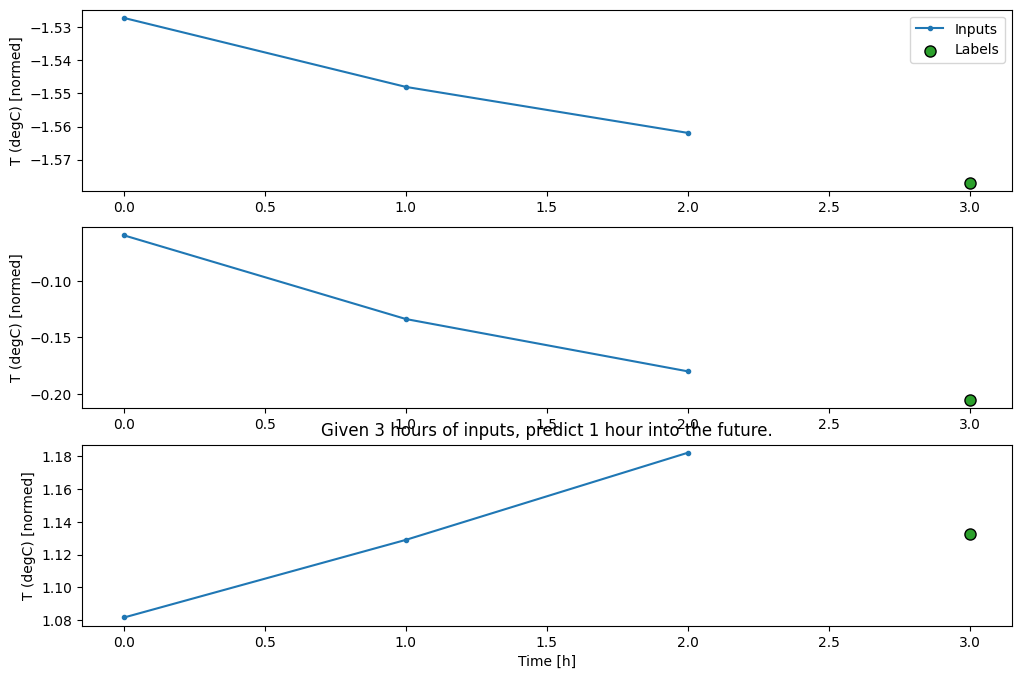

In [48]:
conv_window.plot()
plt.title("Given 3 hours of inputs, predict 1 hour into the future.")

`tf.keras.layers.Flatten`을 모델의 첫 번째 레이어로 추가하여 다중 입력 스텝 창에서 `dense` 모델을 훈련할 수 있습니다.

In [49]:
multi_step_dense = tf.keras.Sequential([
    # Shape: (time, features) => (time*features)
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(units=32, activation='relu'),
    tf.keras.layers.Dense(units=32, activation='relu'),
    tf.keras.layers.Dense(units=1),
    # Add back the time dimension.
    # Shape: (outputs) => (1, outputs)
    tf.keras.layers.Reshape([1, -1]),
])

In [50]:
print('Input shape:', conv_window.example[0].shape)
print('Output shape:', multi_step_dense(conv_window.example[0]).shape)

Input shape: (32, 3, 19)
Output shape: (32, 1, 1)


In [51]:
history = compile_and_fit(multi_step_dense, conv_window)

IPython.display.clear_output()
val_performance['Multi step dense'] = multi_step_dense.evaluate(conv_window.val)
performance['Multi step dense'] = multi_step_dense.evaluate(conv_window.test, verbose=0)

  1/438 [..............................] - ETA: 32s - loss: 0.0074 - mean_absolute_error: 0.0643

 24/438 [>.............................] - ETA: 0s - loss: 0.0072 - mean_absolute_error: 0.0635 

 50/438 [==>...........................] - ETA: 0s - loss: 0.0069 - mean_absolute_error: 0.0611

 77/438 [====>.........................] - ETA: 0s - loss: 0.0067 - mean_absolute_error: 0.0611

103/438 [======>.......................] - ETA: 0s - loss: 0.0067 - mean_absolute_error: 0.0611

129/438 [=======>......................] - ETA: 0s - loss: 0.0067 - mean_absolute_error: 0.0606

156/438 [=========>....................] - ETA: 0s - loss: 0.0070 - mean_absolute_error: 0.0614

184/438 [===========>..................] - ETA: 0s - loss: 0.0070 - mean_absolute_error: 0.0612

209/438 [=============>................] - ETA: 0s - loss: 0.0071 - mean_absolute_error: 0.0616

234/438 [===============>..............] - ETA: 0s - loss: 0.0070 - mean_absolute_error: 0.0612

260/438 [================>.............] - ETA: 0s - loss: 0.0071 - mean_absolute_error: 0.0613

285/438 [==================>...........] - ETA: 0s - loss: 0.0072 - mean_absolute_error: 0.0616

311/438 [====================>.........] - ETA: 0s - loss: 0.0071 - mean_absolute_error: 0.0613

337/438 [======================>.......] - ETA: 0s - loss: 0.0071 - mean_absolute_error: 0.0614

362/438 [=======================>......] - ETA: 0s - loss: 0.0071 - mean_absolute_error: 0.0611

388/438 [=========================>....] - ETA: 0s - loss: 0.0072 - mean_absolute_error: 0.0613

414/438 [===========================>..] - ETA: 0s - loss: 0.0072 - mean_absolute_error: 0.0614

438/438 [==============================] - 1s 2ms/step - loss: 0.0072 - mean_absolute_error: 0.0614


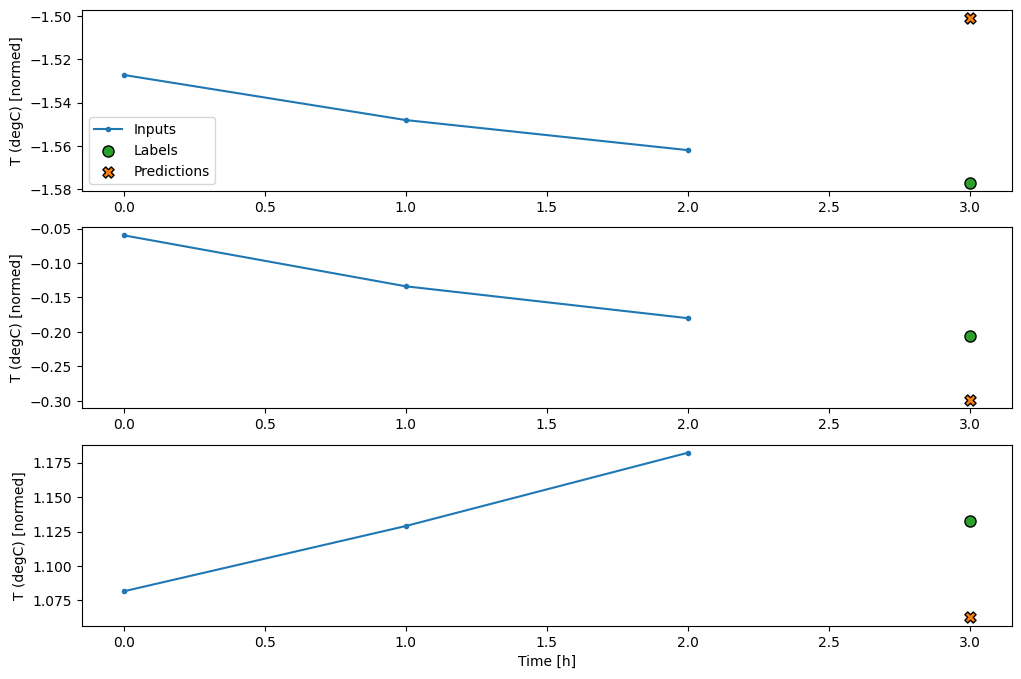

In [52]:
conv_window.plot(multi_step_dense)

이 접근법의 주된 단점은 결과적인 모델이 정확히 이 형상의 입력 창에서만 실행될 수 있다는 것입니다. 

In [53]:
print('Input shape:', wide_window.example[0].shape)
try:
  print('Output shape:', multi_step_dense(wide_window.example[0]).shape)
except Exception as e:
  print(f'\n{type(e).__name__}:{e}')

Input shape: (32, 24, 19)

ValueError:Exception encountered when calling layer 'sequential_2' (type Sequential).

Input 0 of layer "dense_4" is incompatible with the layer: expected axis -1 of input shape to have value 57, but received input with shape (32, 456)

Call arguments received by layer 'sequential_2' (type Sequential):
  • inputs=tf.Tensor(shape=(32, 24, 19), dtype=float32)
  • training=None
  • mask=None


다음 섹션의 컨볼루셔널 모델은 이 문제를 해결합니다.

### 컨볼루션 신경망

컨볼루션 레이어(`tf.keras.layers.Conv1D`)도 각 예측에 대한 입력으로 여러 타임스텝을 사용합니다.

다음은 컨볼루션으로 다시 작성한 `multi_step_dense`와 **동일한** 모델입니다.

다음 변경 사항에 주목하세요.

- `tf.keras.layers.Flatten`과 첫 번째 `tf.keras.layers.Dense`는 `tf.keras.layers.Conv1D`로 대체됩니다.
- 컨볼루션이 출력에서 시간 축을 유지하므로 `tf.keras.layers.Reshape`는 이 더 이상 필요하지 않습니다.

In [54]:
conv_model = tf.keras.Sequential([
    tf.keras.layers.Conv1D(filters=32,
                           kernel_size=(CONV_WIDTH,),
                           activation='relu'),
    tf.keras.layers.Dense(units=32, activation='relu'),
    tf.keras.layers.Dense(units=1),
])

예제 배치에서 실행하여 모델이 예상한 형상으로 출력을 생성하는지 확인합니다.

In [55]:
print("Conv model on `conv_window`")
print('Input shape:', conv_window.example[0].shape)
print('Output shape:', conv_model(conv_window.example[0]).shape)

Conv model on `conv_window`
Input shape: (32, 3, 19)
Output shape: (32, 1, 1)


`conv_window`에서 훈련하고 평가하면 `multi_step_dense` 모델과 유사한 성능을 제공해야 합니다.

In [56]:
history = compile_and_fit(conv_model, conv_window)

IPython.display.clear_output()
val_performance['Conv'] = conv_model.evaluate(conv_window.val)
performance['Conv'] = conv_model.evaluate(conv_window.test, verbose=0)

  1/438 [..............................] - ETA: 32s - loss: 0.0062 - mean_absolute_error: 0.0545

 20/438 [>.............................] - ETA: 1s - loss: 0.0052 - mean_absolute_error: 0.0526 

 40/438 [=>............................] - ETA: 1s - loss: 0.0055 - mean_absolute_error: 0.0529

 60/438 [===>..........................] - ETA: 0s - loss: 0.0058 - mean_absolute_error: 0.0541

 79/438 [====>.........................] - ETA: 0s - loss: 0.0056 - mean_absolute_error: 0.0536

 99/438 [=====>........................] - ETA: 0s - loss: 0.0056 - mean_absolute_error: 0.0534

119/438 [=======>......................] - ETA: 0s - loss: 0.0060 - mean_absolute_error: 0.0545

140/438 [========>.....................] - ETA: 0s - loss: 0.0060 - mean_absolute_error: 0.0544

159/438 [=========>....................] - ETA: 0s - loss: 0.0061 - mean_absolute_error: 0.0549

178/438 [===========>..................] - ETA: 0s - loss: 0.0060 - mean_absolute_error: 0.0546

198/438 [============>.................] - ETA: 0s - loss: 0.0062 - mean_absolute_error: 0.0547

218/438 [=============>................] - ETA: 0s - loss: 0.0060 - mean_absolute_error: 0.0542

237/438 [===============>..............] - ETA: 0s - loss: 0.0060 - mean_absolute_error: 0.0544

257/438 [================>.............] - ETA: 0s - loss: 0.0061 - mean_absolute_error: 0.0546

277/438 [=================>............] - ETA: 0s - loss: 0.0061 - mean_absolute_error: 0.0548

297/438 [===================>..........] - ETA: 0s - loss: 0.0061 - mean_absolute_error: 0.0546

316/438 [====================>.........] - ETA: 0s - loss: 0.0061 - mean_absolute_error: 0.0546

335/438 [=====================>........] - ETA: 0s - loss: 0.0062 - mean_absolute_error: 0.0547

355/438 [=======================>......] - ETA: 0s - loss: 0.0062 - mean_absolute_error: 0.0547

376/438 [========================>.....] - ETA: 0s - loss: 0.0062 - mean_absolute_error: 0.0545

395/438 [==========================>...] - ETA: 0s - loss: 0.0062 - mean_absolute_error: 0.0546

415/438 [===========================>..] - ETA: 0s - loss: 0.0062 - mean_absolute_error: 0.0544

435/438 [============================>.] - ETA: 0s - loss: 0.0062 - mean_absolute_error: 0.0543

438/438 [==============================] - 1s 3ms/step - loss: 0.0062 - mean_absolute_error: 0.0544


이 `conv_model`과 `multi_step_dense` 모델의 차이점은 `conv_model`은 모든 길이의 입력에서 실행될 수 있다는 것입니다. 컨볼루셔널 레이어는 입력의 슬라이딩 창에 적용됩니다.

![시퀀스에서 컨볼루션 모델 실행](images/wide_conv_window.png)

더 넓은 입력에서 실행하면 더 넓은 출력이 생성됩니다.

In [57]:
print("Wide window")
print('Input shape:', wide_window.example[0].shape)
print('Labels shape:', wide_window.example[1].shape)
print('Output shape:', conv_model(wide_window.example[0]).shape)

Wide window
Input shape: (32, 24, 19)
Labels shape: (32, 24, 1)
Output shape: (32, 22, 1)


출력은 입력보다 짧습니다. 훈련 또는 플롯 작업을 수행하려면 레이블과 예상의 길이가 동일해야 합니다. 따라서 레이블과 예측 길이가 일치하도록 몇 개의 추가 입력 타임스텝으로 넓은 창을 생성하는 `WindowGenerator`를 빌드합니다. 

In [58]:
LABEL_WIDTH = 24
INPUT_WIDTH = LABEL_WIDTH + (CONV_WIDTH - 1)
wide_conv_window = WindowGenerator(
    input_width=INPUT_WIDTH,
    label_width=LABEL_WIDTH,
    shift=1,
    label_columns=['T (degC)'])

wide_conv_window

Total window size: 27
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25]
Label indices: [ 3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26]
Label column name(s): ['T (degC)']

In [59]:
print("Wide conv window")
print('Input shape:', wide_conv_window.example[0].shape)
print('Labels shape:', wide_conv_window.example[1].shape)
print('Output shape:', conv_model(wide_conv_window.example[0]).shape)

Wide conv window
Input shape: (32, 26, 19)
Labels shape: (32, 24, 1)


Output shape: (32, 24, 1)


이제 더 넓은 창에 모델의 예측을 플롯할 수 있습니다. 첫 번째 예측 전 3개의 입력 타임스텝에 주목하세요. 여기서 모든 예측은 이전 3개의 타임스텝에 기초합니다.

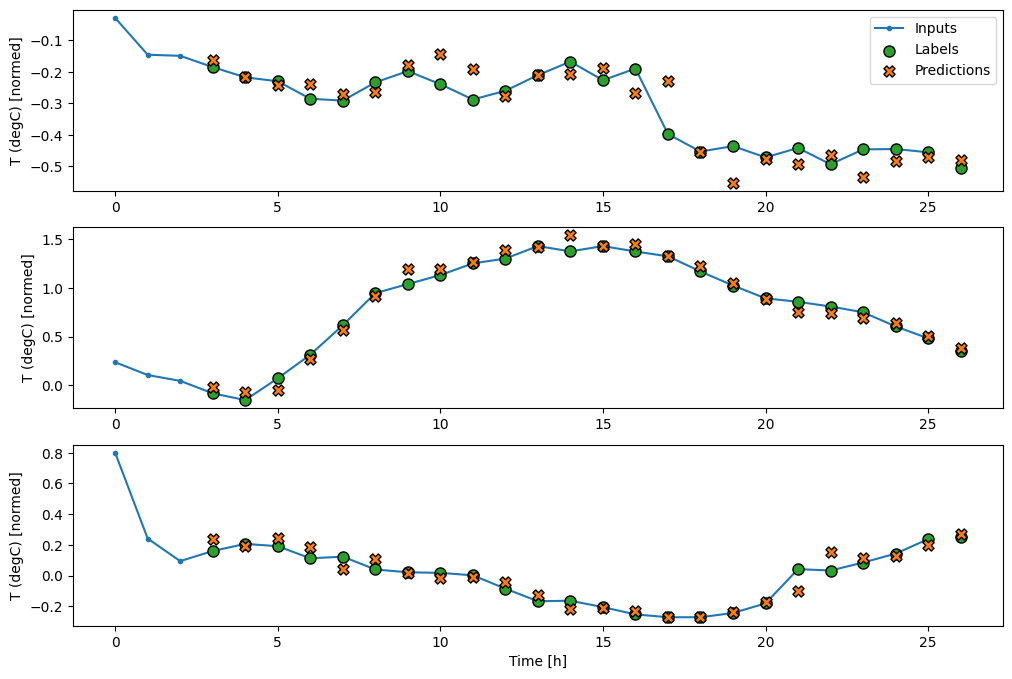

In [60]:
wide_conv_window.plot(conv_model)

### 순환 신경망

Recurrent Neural Network(RNN)는 시계열 데이터에 적합한 신경망 유형입니다. RNN은 시계열을 단계별로 처리하여 타임스텝 사이에서 내부 상태를 유지합니다.

[RNN을 사용한 텍스트 생성](https://www.tensorflow.org/text/tutorials/text_generation) 튜토리얼 및 [Keras를 사용한 순환 신경망(RNN)](https://www.tensorflow.org/guide/keras/rnn) 가이드에서 자세히 알아볼 수 있습니다.

이 튜토리얼에서는 LSTM(`tf.keras.layers.LSTM`)이라는 RNN 레이어를 사용합니다.

`tf.keras.layers.LSTM`와 같이 모든 keras RNN 레이어에 대한 중요한 생성자 인수는 `return_sequences` 인수입니다. 이 설정은 다음 두 가지 방법 중 하나로 레이어를 구성할 수 있습니다.

1. 기본값인 `False`인 경우 레이어는 최종 타임스텝의 출력만 반환하여 단일 예측을 수행하기 전에 모델이 내부 상태를 준비할 시간을 줍니다.

![lstm 워밍업 및 단일 예측](images/lstm_1_window.png)

1. `True`이면 레이어가 각 입력에 대한 출력을 반환합니다. 다음과 같은 경우에 유용합니다.
    - RNN 레이어 스태킹
    - 여러 타임스텝에서 동시에 모델 훈련

![모든 타임스텝 후에 예측하는 lstm](images/lstm_many_window.png)

In [61]:
lstm_model = tf.keras.models.Sequential([
    # Shape [batch, time, features] => [batch, time, lstm_units]
    tf.keras.layers.LSTM(32, return_sequences=True),
    # Shape => [batch, time, features]
    tf.keras.layers.Dense(units=1)
])

`return_sequences=True`이면 모델을 한 번에 24시간 분량 데이터에 대해 훈련할 수 있습니다.

참고: 이 경우에는 모델 성능의 관점에서 기대할 것이 없습니다. 첫 번째 타임스텝에서 모델이 이전 스텝에 액세스할 수 없으므로 이전에 표시한 단순한 `linear` 및 `dense` 모델보다 더 나을 것이 없기 때문입니다.

In [62]:
print('Input shape:', wide_window.example[0].shape)
print('Output shape:', lstm_model(wide_window.example[0]).shape)

Input shape: (32, 24, 19)


Output shape: (32, 24, 1)


In [63]:
history = compile_and_fit(lstm_model, wide_window)

IPython.display.clear_output()
val_performance['LSTM'] = lstm_model.evaluate(wide_window.val)
performance['LSTM'] = lstm_model.evaluate(wide_window.test, verbose=0)

  1/438 [..............................] - ETA: 31s - loss: 0.0065 - mean_absolute_error: 0.0566

 17/438 [>.............................] - ETA: 1s - loss: 0.0057 - mean_absolute_error: 0.0524 

 34/438 [=>............................] - ETA: 1s - loss: 0.0060 - mean_absolute_error: 0.0534

 51/438 [==>...........................] - ETA: 1s - loss: 0.0059 - mean_absolute_error: 0.0527

 68/438 [===>..........................] - ETA: 1s - loss: 0.0057 - mean_absolute_error: 0.0522

 85/438 [====>.........................] - ETA: 1s - loss: 0.0057 - mean_absolute_error: 0.0519

102/438 [=====>........................] - ETA: 1s - loss: 0.0057 - mean_absolute_error: 0.0519

119/438 [=======>......................] - ETA: 0s - loss: 0.0056 - mean_absolute_error: 0.0519

136/438 [========>.....................] - ETA: 0s - loss: 0.0056 - mean_absolute_error: 0.0517

152/438 [=========>....................] - ETA: 0s - loss: 0.0056 - mean_absolute_error: 0.0517

168/438 [==========>...................] - ETA: 0s - loss: 0.0056 - mean_absolute_error: 0.0517

184/438 [===========>..................] - ETA: 0s - loss: 0.0056 - mean_absolute_error: 0.0516

201/438 [============>.................] - ETA: 0s - loss: 0.0056 - mean_absolute_error: 0.0515

218/438 [=============>................] - ETA: 0s - loss: 0.0056 - mean_absolute_error: 0.0516

234/438 [===============>..............] - ETA: 0s - loss: 0.0056 - mean_absolute_error: 0.0517

251/438 [================>.............] - ETA: 0s - loss: 0.0056 - mean_absolute_error: 0.0518

268/438 [=================>............] - ETA: 0s - loss: 0.0056 - mean_absolute_error: 0.0517

285/438 [==================>...........] - ETA: 0s - loss: 0.0056 - mean_absolute_error: 0.0517

302/438 [===================>..........] - ETA: 0s - loss: 0.0056 - mean_absolute_error: 0.0516

319/438 [====================>.........] - ETA: 0s - loss: 0.0056 - mean_absolute_error: 0.0516

336/438 [======================>.......] - ETA: 0s - loss: 0.0056 - mean_absolute_error: 0.0515

353/438 [=======================>......] - ETA: 0s - loss: 0.0056 - mean_absolute_error: 0.0515

370/438 [========================>.....] - ETA: 0s - loss: 0.0056 - mean_absolute_error: 0.0515

387/438 [=========================>....] - ETA: 0s - loss: 0.0055 - mean_absolute_error: 0.0514

404/438 [==========================>...] - ETA: 0s - loss: 0.0056 - mean_absolute_error: 0.0515

421/438 [===========================>..] - ETA: 0s - loss: 0.0056 - mean_absolute_error: 0.0515

438/438 [==============================] - 1s 3ms/step - loss: 0.0056 - mean_absolute_error: 0.0515


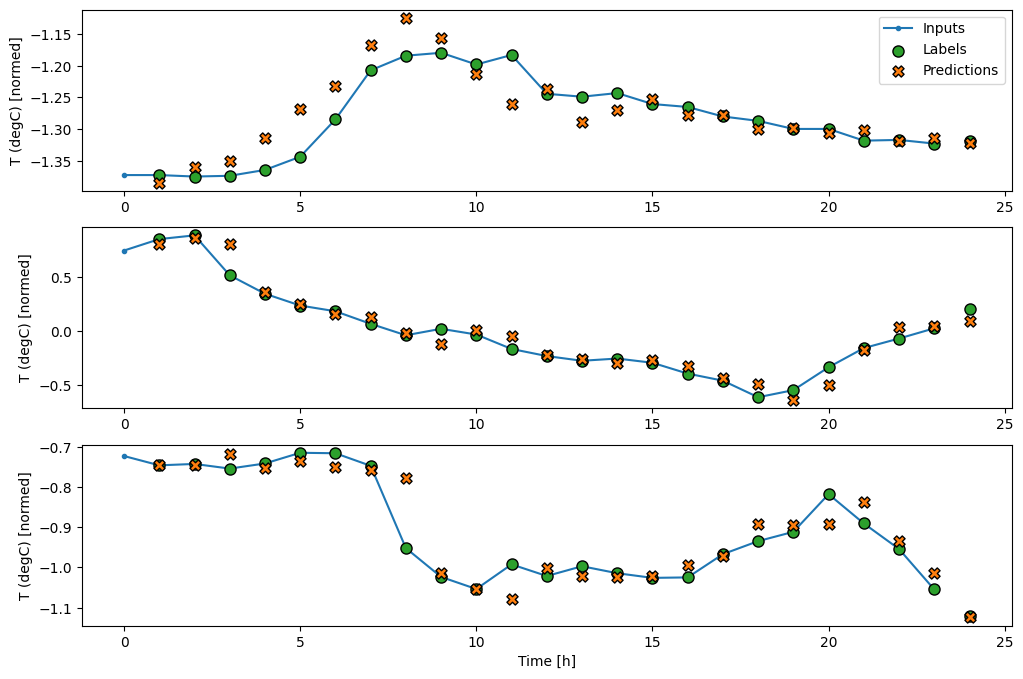

In [64]:
wide_window.plot(lstm_model)

### 성능

이 데이터세트를 사용하면 일반적으로 각 모델의 성능이 이전 모델보다 약간 더 좋습니다.

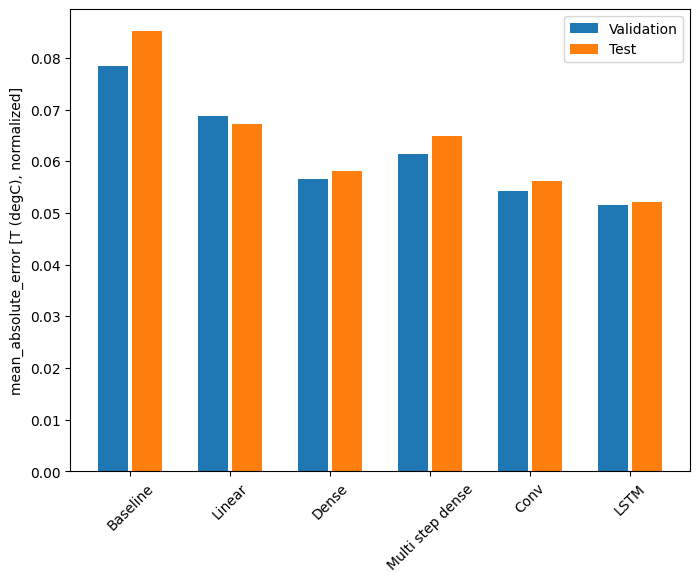

In [65]:
x = np.arange(len(performance))
width = 0.3
metric_name = 'mean_absolute_error'
metric_index = lstm_model.metrics_names.index('mean_absolute_error')
val_mae = [v[metric_index] for v in val_performance.values()]
test_mae = [v[metric_index] for v in performance.values()]

plt.ylabel('mean_absolute_error [T (degC), normalized]')
plt.bar(x - 0.17, val_mae, width, label='Validation')
plt.bar(x + 0.17, test_mae, width, label='Test')
plt.xticks(ticks=x, labels=performance.keys(),
           rotation=45)
_ = plt.legend()

In [66]:
for name, value in performance.items():
  print(f'{name:12s}: {value[1]:0.4f}')

Baseline    : 0.0852
Linear      : 0.0672
Dense       : 0.0581
Multi step dense: 0.0650
Conv        : 0.0561
LSTM        : 0.0521


### 다중 출력 모델

지금까지 모델은 모두 단일 타임스텝에 대해 단일 출력 특성 `T (degC)`를 예측했습니다.

이러한 모든 모델은 간단히 출력 레이어의 단위 수를 변경하고 code0}labels(`example_labels`)에 모든 특성을 포함하도록 훈련 창을 조정하여 여러 특성을 예측하도록 변환할 수 있습니다.

In [67]:
single_step_window = WindowGenerator(
    # `WindowGenerator` returns all features as labels if you 
    # don't set the `label_columns` argument.
    input_width=1, label_width=1, shift=1)

wide_window = WindowGenerator(
    input_width=24, label_width=24, shift=1)

for example_inputs, example_labels in wide_window.train.take(1):
  print(f'Inputs shape (batch, time, features): {example_inputs.shape}')
  print(f'Labels shape (batch, time, features): {example_labels.shape}')

Inputs shape (batch, time, features): (32, 24, 19)
Labels shape (batch, time, features): (32, 24, 19)


레이블의 `features` 축은 이제 1이 아닌 입력과 동일한 깊이를 갖습니다.

#### 기준

여기서는 동일한 기준 모델(`Baseline`)을 사용할 수 있지만 이번에는 특정 `label_index`를 선택하는 대신 모든 특성을 반복합니다.

In [68]:
baseline = Baseline()
baseline.compile(loss=tf.keras.losses.MeanSquaredError(),
                 metrics=[tf.keras.metrics.MeanAbsoluteError()])

In [69]:
val_performance = {}
performance = {}
val_performance['Baseline'] = baseline.evaluate(wide_window.val)
performance['Baseline'] = baseline.evaluate(wide_window.test, verbose=0)

  1/438 [..............................] - ETA: 56s - loss: 0.0800 - mean_absolute_error: 0.1530

 27/438 [>.............................] - ETA: 0s - loss: 0.0874 - mean_absolute_error: 0.1585 

 54/438 [==>...........................] - ETA: 0s - loss: 0.0879 - mean_absolute_error: 0.1585

 82/438 [====>.........................] - ETA: 0s - loss: 0.0885 - mean_absolute_error: 0.1588

109/438 [======>.......................] - ETA: 0s - loss: 0.0891 - mean_absolute_error: 0.1596

136/438 [========>.....................] - ETA: 0s - loss: 0.0895 - mean_absolute_error: 0.1598

165/438 [==========>...................] - ETA: 0s - loss: 0.0897 - mean_absolute_error: 0.1598

194/438 [============>.................] - ETA: 0s - loss: 0.0895 - mean_absolute_error: 0.1597

222/438 [==============>...............] - ETA: 0s - loss: 0.0894 - mean_absolute_error: 0.1596

249/438 [================>.............] - ETA: 0s - loss: 0.0893 - mean_absolute_error: 0.1595

276/438 [=================>............] - ETA: 0s - loss: 0.0895 - mean_absolute_error: 0.1596

304/438 [===================>..........] - ETA: 0s - loss: 0.0893 - mean_absolute_error: 0.1594

332/438 [=====================>........] - ETA: 0s - loss: 0.0891 - mean_absolute_error: 0.1593

360/438 [=======================>......] - ETA: 0s - loss: 0.0890 - mean_absolute_error: 0.1593

388/438 [=========================>....] - ETA: 0s - loss: 0.0888 - mean_absolute_error: 0.1591

416/438 [===========================>..] - ETA: 0s - loss: 0.0886 - mean_absolute_error: 0.1589

438/438 [==============================] - 1s 2ms/step - loss: 0.0886 - mean_absolute_error: 0.1589


#### 밀집

In [70]:
dense = tf.keras.Sequential([
    tf.keras.layers.Dense(units=64, activation='relu'),
    tf.keras.layers.Dense(units=64, activation='relu'),
    tf.keras.layers.Dense(units=num_features)
])

In [71]:
history = compile_and_fit(dense, single_step_window)

IPython.display.clear_output()
val_performance['Dense'] = dense.evaluate(single_step_window.val)
performance['Dense'] = dense.evaluate(single_step_window.test, verbose=0)

  1/439 [..............................] - ETA: 30s - loss: 0.0422 - mean_absolute_error: 0.1166

 18/439 [>.............................] - ETA: 1s - loss: 0.0634 - mean_absolute_error: 0.1322 

 37/439 [=>............................] - ETA: 1s - loss: 0.0682 - mean_absolute_error: 0.1342

 57/439 [==>...........................] - ETA: 1s - loss: 0.0673 - mean_absolute_error: 0.1334

 76/439 [====>.........................] - ETA: 0s - loss: 0.0683 - mean_absolute_error: 0.1343

 95/439 [=====>........................] - ETA: 0s - loss: 0.0671 - mean_absolute_error: 0.1330

115/439 [======>.......................] - ETA: 0s - loss: 0.0670 - mean_absolute_error: 0.1334

136/439 [========>.....................] - ETA: 0s - loss: 0.0685 - mean_absolute_error: 0.1345

155/439 [=========>....................] - ETA: 0s - loss: 0.0682 - mean_absolute_error: 0.1343

175/439 [==========>...................] - ETA: 0s - loss: 0.0691 - mean_absolute_error: 0.1348

195/439 [============>.................] - ETA: 0s - loss: 0.0691 - mean_absolute_error: 0.1350

215/439 [=============>................] - ETA: 0s - loss: 0.0693 - mean_absolute_error: 0.1349

235/439 [===============>..............] - ETA: 0s - loss: 0.0695 - mean_absolute_error: 0.1350

254/439 [================>.............] - ETA: 0s - loss: 0.0697 - mean_absolute_error: 0.1351

273/439 [=================>............] - ETA: 0s - loss: 0.0704 - mean_absolute_error: 0.1354

293/439 [===================>..........] - ETA: 0s - loss: 0.0699 - mean_absolute_error: 0.1351

313/439 [====================>.........] - ETA: 0s - loss: 0.0695 - mean_absolute_error: 0.1349

333/439 [=====================>........] - ETA: 0s - loss: 0.0697 - mean_absolute_error: 0.1350

353/439 [=======================>......] - ETA: 0s - loss: 0.0699 - mean_absolute_error: 0.1352

372/439 [========================>.....] - ETA: 0s - loss: 0.0696 - mean_absolute_error: 0.1350

392/439 [=========================>....] - ETA: 0s - loss: 0.0694 - mean_absolute_error: 0.1348

412/439 [===========================>..] - ETA: 0s - loss: 0.0692 - mean_absolute_error: 0.1346

432/439 [============================>.] - ETA: 0s - loss: 0.0691 - mean_absolute_error: 0.1346

439/439 [==============================] - 1s 3ms/step - loss: 0.0692 - mean_absolute_error: 0.1346


#### RNN


In [72]:
%%time
wide_window = WindowGenerator(
    input_width=24, label_width=24, shift=1)

lstm_model = tf.keras.models.Sequential([
    # Shape [batch, time, features] => [batch, time, lstm_units]
    tf.keras.layers.LSTM(32, return_sequences=True),
    # Shape => [batch, time, features]
    tf.keras.layers.Dense(units=num_features)
])

history = compile_and_fit(lstm_model, wide_window)

IPython.display.clear_output()
val_performance['LSTM'] = lstm_model.evaluate( wide_window.val)
performance['LSTM'] = lstm_model.evaluate( wide_window.test, verbose=0)

print()

  1/438 [..............................] - ETA: 30s - loss: 0.0585 - mean_absolute_error: 0.1158

 17/438 [>.............................] - ETA: 1s - loss: 0.0622 - mean_absolute_error: 0.1207 

 34/438 [=>............................] - ETA: 1s - loss: 0.0628 - mean_absolute_error: 0.1210

 51/438 [==>...........................] - ETA: 1s - loss: 0.0624 - mean_absolute_error: 0.1210

 68/438 [===>..........................] - ETA: 1s - loss: 0.0627 - mean_absolute_error: 0.1213

 85/438 [====>.........................] - ETA: 1s - loss: 0.0624 - mean_absolute_error: 0.1212

103/438 [======>.......................] - ETA: 1s - loss: 0.0623 - mean_absolute_error: 0.1211

121/438 [=======>......................] - ETA: 0s - loss: 0.0620 - mean_absolute_error: 0.1209

138/438 [========>.....................] - ETA: 0s - loss: 0.0622 - mean_absolute_error: 0.1210

156/438 [=========>....................] - ETA: 0s - loss: 0.0622 - mean_absolute_error: 0.1209

173/438 [==========>...................] - ETA: 0s - loss: 0.0623 - mean_absolute_error: 0.1210

190/438 [============>.................] - ETA: 0s - loss: 0.0623 - mean_absolute_error: 0.1209

207/438 [=============>................] - ETA: 0s - loss: 0.0624 - mean_absolute_error: 0.1210

225/438 [==============>...............] - ETA: 0s - loss: 0.0625 - mean_absolute_error: 0.1211

242/438 [===============>..............] - ETA: 0s - loss: 0.0625 - mean_absolute_error: 0.1211

259/438 [================>.............] - ETA: 0s - loss: 0.0625 - mean_absolute_error: 0.1211

276/438 [=================>............] - ETA: 0s - loss: 0.0625 - mean_absolute_error: 0.1211

293/438 [===================>..........] - ETA: 0s - loss: 0.0624 - mean_absolute_error: 0.1210

310/438 [====================>.........] - ETA: 0s - loss: 0.0622 - mean_absolute_error: 0.1209

327/438 [=====================>........] - ETA: 0s - loss: 0.0622 - mean_absolute_error: 0.1208

345/438 [======================>.......] - ETA: 0s - loss: 0.0622 - mean_absolute_error: 0.1208

363/438 [=======================>......] - ETA: 0s - loss: 0.0622 - mean_absolute_error: 0.1208

380/438 [=========================>....] - ETA: 0s - loss: 0.0621 - mean_absolute_error: 0.1207

397/438 [==========================>...] - ETA: 0s - loss: 0.0621 - mean_absolute_error: 0.1207

414/438 [===========================>..] - ETA: 0s - loss: 0.0621 - mean_absolute_error: 0.1206

431/438 [============================>.] - ETA: 0s - loss: 0.0620 - mean_absolute_error: 0.1206

438/438 [==============================] - 1s 3ms/step - loss: 0.0620 - mean_absolute_error: 0.1206



CPU times: user 3min 58s, sys: 58.6 s, total: 4min 56s
Wall time: 1min 34s


<a id="residual"></a>

#### 고급: 잔여 연결

이전의 `Baseline` 모델은 시퀀스가 타임스텝 사이에서 크게 변하지 않는다는 사실을 이용했습니다. 지금까지 이 튜토리얼에서 훈련한 모든 모델은 무작위로 초기화된 다음, 출력이 이전 타임스텝에서 약간 변경된다는 사실을 학습해야 했습니다.

신중한 초기화로 이 문제를 해결할 수 있지만 모델 구조로 빌드하는 것이 더 간단합니다.

시계열 분석에서는 다음 값을 예측하는 대신 다음 타임스텝에서 값이 어떻게 달라지는 지를 예측하는 모델을 빌드하는 것이 일반적입니다. 마찬가지로 딥러닝에서 <a href="https://arxiv.org/abs/1512.03385" class="external">잔여 네트워크</a>(Residual networks) 또는 ResNets는 각 레이어가 모델의 누적 결과에 추가되는 아키텍처를 나타냅니다.

이것은 변화가 작아야 한다는 사실을 이용하는 방법입니다.

![A model with a residual connection](images/residual.png)

기본적으로, `Baseline`과 일치하도록 모델을 초기화합니다. 그러면 이 작업에서 약간 더 나은 성능으로 모델이 더 빨리 수렴시키는 데 도움이 됩니다.

이 접근 방식은 이 튜토리얼에서 설명하는 모든 모델과 연계하여 사용할 수 있습니다.

여기서는 LSTM 모델에 적용합니다. `tf.initializers.zeros`를 사용하여 초기 예측하는 변경이 작고 잔류 연결을 압도하지 않도록 한다는 점에 유의하세요. `zeros`가 마지막 레이어에서만 사용되기 때문에 여기에서 그래디언트에 대한 대칭 파괴 문제는 없습니다.

In [73]:
class ResidualWrapper(tf.keras.Model):
  def __init__(self, model):
    super().__init__()
    self.model = model

  def call(self, inputs, *args, **kwargs):
    delta = self.model(inputs, *args, **kwargs)

    # The prediction for each time step is the input
    # from the previous time step plus the delta
    # calculated by the model.
    return inputs + delta

In [74]:
%%time
residual_lstm = ResidualWrapper(
    tf.keras.Sequential([
    tf.keras.layers.LSTM(32, return_sequences=True),
    tf.keras.layers.Dense(
        num_features,
        # The predicted deltas should start small.
        # Therefore, initialize the output layer with zeros.
        kernel_initializer=tf.initializers.zeros())
]))

history = compile_and_fit(residual_lstm, wide_window)

IPython.display.clear_output()
val_performance['Residual LSTM'] = residual_lstm.evaluate(wide_window.val)
performance['Residual LSTM'] = residual_lstm.evaluate(wide_window.test, verbose=0)
print()

  1/438 [..............................] - ETA: 30s - loss: 0.0667 - mean_absolute_error: 0.1254

 17/438 [>.............................] - ETA: 1s - loss: 0.0612 - mean_absolute_error: 0.1179 

 34/438 [=>............................] - ETA: 1s - loss: 0.0605 - mean_absolute_error: 0.1166

 50/438 [==>...........................] - ETA: 1s - loss: 0.0607 - mean_absolute_error: 0.1170

 67/438 [===>..........................] - ETA: 1s - loss: 0.0612 - mean_absolute_error: 0.1172

 83/438 [====>.........................] - ETA: 1s - loss: 0.0615 - mean_absolute_error: 0.1175

100/438 [=====>........................] - ETA: 1s - loss: 0.0614 - mean_absolute_error: 0.1175

118/438 [=======>......................] - ETA: 0s - loss: 0.0617 - mean_absolute_error: 0.1177

134/438 [========>.....................] - ETA: 0s - loss: 0.0619 - mean_absolute_error: 0.1180

151/438 [=========>....................] - ETA: 0s - loss: 0.0619 - mean_absolute_error: 0.1180

168/438 [==========>...................] - ETA: 0s - loss: 0.0622 - mean_absolute_error: 0.1183

185/438 [===========>..................] - ETA: 0s - loss: 0.0623 - mean_absolute_error: 0.1184

202/438 [============>.................] - ETA: 0s - loss: 0.0623 - mean_absolute_error: 0.1184

218/438 [=============>................] - ETA: 0s - loss: 0.0624 - mean_absolute_error: 0.1185

234/438 [===============>..............] - ETA: 0s - loss: 0.0623 - mean_absolute_error: 0.1184

251/438 [================>.............] - ETA: 0s - loss: 0.0625 - mean_absolute_error: 0.1185

268/438 [=================>............] - ETA: 0s - loss: 0.0626 - mean_absolute_error: 0.1186

284/438 [==================>...........] - ETA: 0s - loss: 0.0627 - mean_absolute_error: 0.1187

300/438 [===================>..........] - ETA: 0s - loss: 0.0626 - mean_absolute_error: 0.1186

317/438 [====================>.........] - ETA: 0s - loss: 0.0625 - mean_absolute_error: 0.1186

334/438 [=====================>........] - ETA: 0s - loss: 0.0625 - mean_absolute_error: 0.1186

351/438 [=======================>......] - ETA: 0s - loss: 0.0625 - mean_absolute_error: 0.1185

368/438 [========================>.....] - ETA: 0s - loss: 0.0626 - mean_absolute_error: 0.1186

385/438 [=========================>....] - ETA: 0s - loss: 0.0625 - mean_absolute_error: 0.1186

402/438 [==========================>...] - ETA: 0s - loss: 0.0626 - mean_absolute_error: 0.1186

419/438 [===========================>..] - ETA: 0s - loss: 0.0625 - mean_absolute_error: 0.1185

436/438 [============================>.] - ETA: 0s - loss: 0.0626 - mean_absolute_error: 0.1186

438/438 [==============================] - 1s 3ms/step - loss: 0.0626 - mean_absolute_error: 0.1186



CPU times: user 2min 50s, sys: 41.1 s, total: 3min 31s
Wall time: 1min 7s


#### 성능

다음은 이러한 다중 출력 모델의 전반적인 성능입니다.

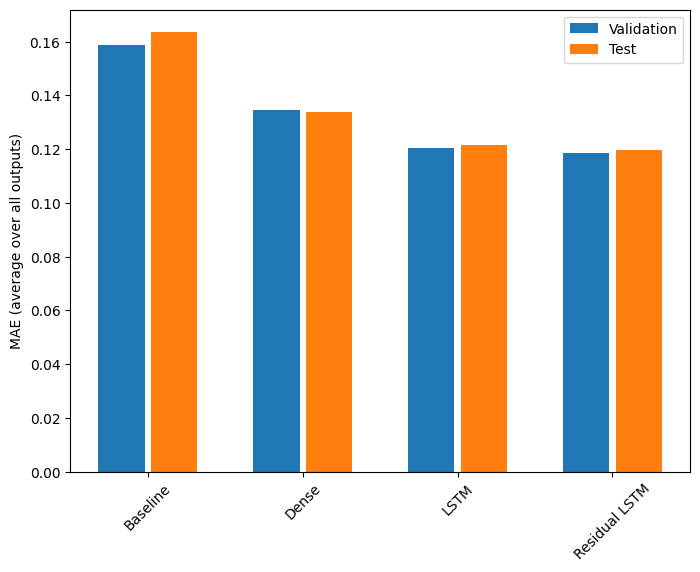

In [75]:
x = np.arange(len(performance))
width = 0.3

metric_name = 'mean_absolute_error'
metric_index = lstm_model.metrics_names.index('mean_absolute_error')
val_mae = [v[metric_index] for v in val_performance.values()]
test_mae = [v[metric_index] for v in performance.values()]

plt.bar(x - 0.17, val_mae, width, label='Validation')
plt.bar(x + 0.17, test_mae, width, label='Test')
plt.xticks(ticks=x, labels=performance.keys(),
           rotation=45)
plt.ylabel('MAE (average over all outputs)')
_ = plt.legend()

In [76]:
for name, value in performance.items():
  print(f'{name:15s}: {value[1]:0.4f}')

Baseline       : 0.1638
Dense          : 0.1340
LSTM           : 0.1217
Residual LSTM  : 0.1196


위의 성능은 모든 모델 출력에 대한 평균입니다.

## 다중 스텝 모델

이전 섹션의 단일 출력 및 다중 출력 모델은 모두 미래 1시간의 **단일 타임스텝 예측**을 수행했습니다.

이 섹션에서는 이러한 모델을 확장하여 **다중 타임스텝 예측**을 수행하는 방법을 살펴봅니다.

다중 스텝 예측에서 모델은 일정 범위의 미래 값을 예측하는 방법을 학습해야 합니다. 따라서 한 미래 시점만 예측하는 단일 스텝 모델과 달리 다중 스텝 모델은 미래 값의 시퀀스를 예측합니다.

대략적으로 두 가지 접근 방식이 있습니다.

1. 전체 시계열이 한 번에 예측되는 싱글샷 예측
2. 모델이 단일 스텝 예측만 수행하고 출력이 입력으로 피드백되는 자기 회귀적 예측

이 섹션에서는 모든 모델이 **모든 출력 타임스텝에 걸쳐 모든 특성**을 예측합니다.


다중 스텝 모델의 경우, 훈련 데이터는 다시 시간별 샘플로 구성됩니다. 그러나 여기에서 모델은 과거의 24시간을 고려하여 미래의 24시간을 예측하는 방법을 학습합니다.

다음은 데이터세트로부터 이러한 조각을 생성하는 `Window` 객체입니다.

Total window size: 48
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23]
Label indices: [24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47]
Label column name(s): None

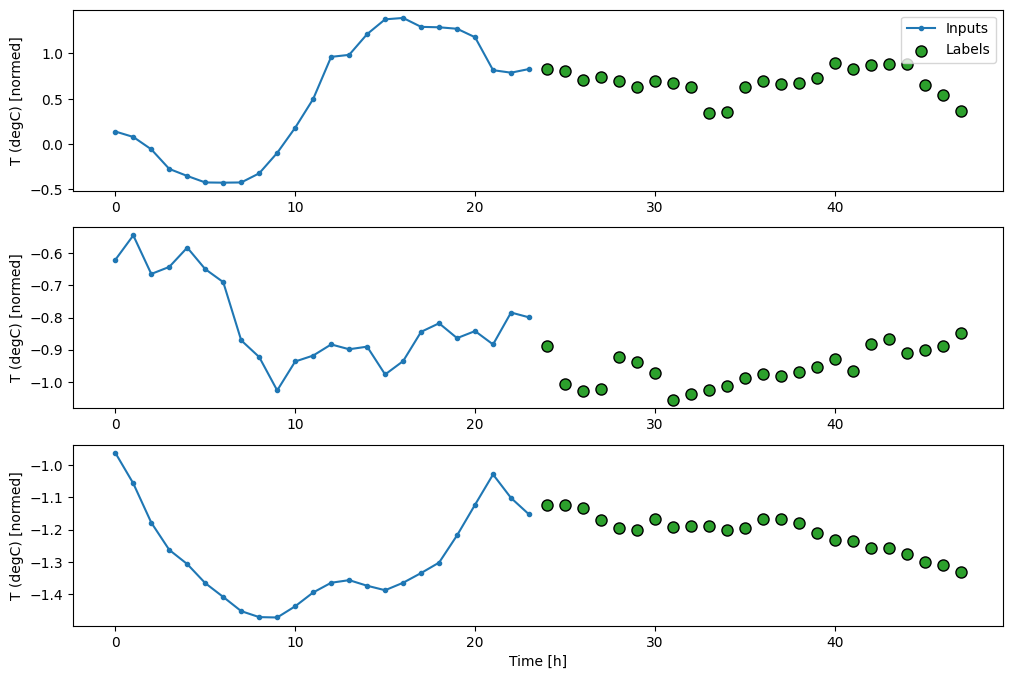

In [77]:
OUT_STEPS = 24
multi_window = WindowGenerator(input_width=24,
                               label_width=OUT_STEPS,
                               shift=OUT_STEPS)

multi_window.plot()
multi_window

### 기준

이 작업의 간단한 기준은 필요한 출력 타임스텝 수에 대해 마지막 입력 타임스텝을 반복하는 것입니다.

![각 출력 단계에 대해 마지막 입력 반복](images/multistep_last.png)

  1/437 [..............................] - ETA: 1:10 - loss: 0.6104 - mean_absolute_error: 0.5006

 25/437 [>.............................] - ETA: 0s - loss: 0.6262 - mean_absolute_error: 0.5017  

 52/437 [==>...........................] - ETA: 0s - loss: 0.6280 - mean_absolute_error: 0.5021

 78/437 [====>.........................] - ETA: 0s - loss: 0.6302 - mean_absolute_error: 0.5013

104/437 [======>.......................] - ETA: 0s - loss: 0.6261 - mean_absolute_error: 0.4998

131/437 [=======>......................] - ETA: 0s - loss: 0.6250 - mean_absolute_error: 0.4997

158/437 [=========>....................] - ETA: 0s - loss: 0.6265 - mean_absolute_error: 0.4998

184/437 [===========>..................] - ETA: 0s - loss: 0.6292 - mean_absolute_error: 0.5010

211/437 [=============>................] - ETA: 0s - loss: 0.6304 - mean_absolute_error: 0.5016

237/437 [===============>..............] - ETA: 0s - loss: 0.6305 - mean_absolute_error: 0.5017

264/437 [=================>............] - ETA: 0s - loss: 0.6310 - mean_absolute_error: 0.5016

291/437 [==================>...........] - ETA: 0s - loss: 0.6308 - mean_absolute_error: 0.5016

318/437 [====================>.........] - ETA: 0s - loss: 0.6312 - mean_absolute_error: 0.5016

347/437 [======================>.......] - ETA: 0s - loss: 0.6305 - mean_absolute_error: 0.5012

375/437 [========================>.....] - ETA: 0s - loss: 0.6298 - mean_absolute_error: 0.5008

402/437 [==========================>...] - ETA: 0s - loss: 0.6298 - mean_absolute_error: 0.5008

429/437 [============================>.] - ETA: 0s - loss: 0.6290 - mean_absolute_error: 0.5008

437/437 [==============================] - 1s 2ms/step - loss: 0.6285 - mean_absolute_error: 0.5007


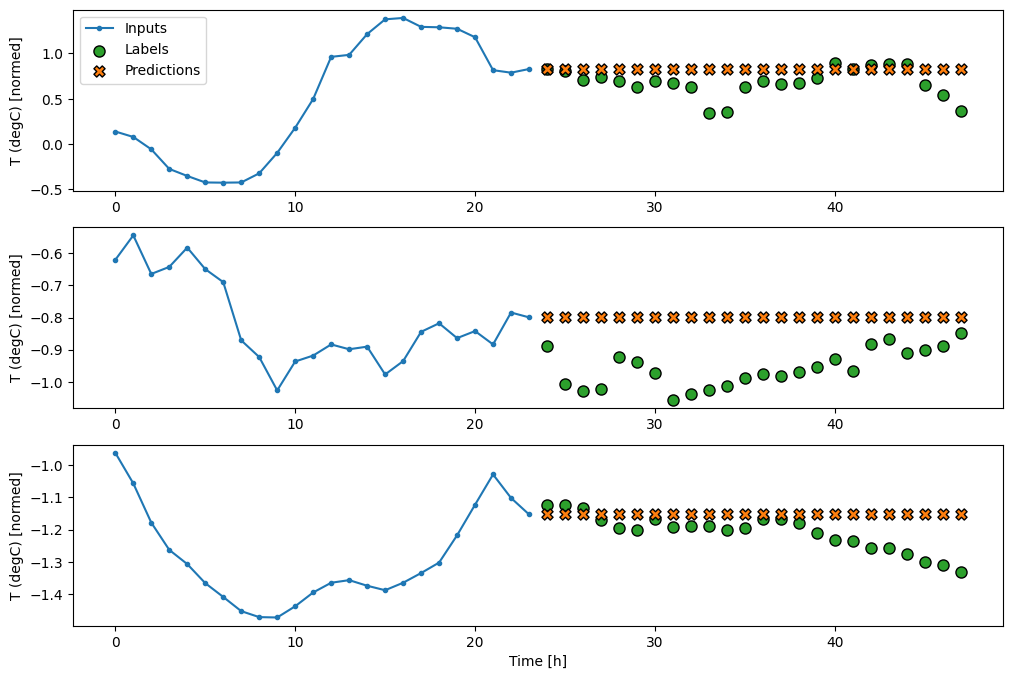

In [78]:
class MultiStepLastBaseline(tf.keras.Model):
  def call(self, inputs):
    return tf.tile(inputs[:, -1:, :], [1, OUT_STEPS, 1])

last_baseline = MultiStepLastBaseline()
last_baseline.compile(loss=tf.keras.losses.MeanSquaredError(),
                      metrics=[tf.keras.metrics.MeanAbsoluteError()])

multi_val_performance = {}
multi_performance = {}

multi_val_performance['Last'] = last_baseline.evaluate(multi_window.val)
multi_performance['Last'] = last_baseline.evaluate(multi_window.test, verbose=0)
multi_window.plot(last_baseline)

이 작업은 과거의 24시간을 고려하여 미래의 24시간을 예측하는 것이므로 또 다른 간단한 접근법은 내일도 비슷하다는 가정 하에 전날을 반복하는 것입니다.

![Repeat the previous day](images/multistep_repeat.png)

  1/437 [..............................] - ETA: 1:00 - loss: 0.5366 - mean_absolute_error: 0.4497

 26/437 [>.............................] - ETA: 0s - loss: 0.4316 - mean_absolute_error: 0.3978  

 53/437 [==>...........................] - ETA: 0s - loss: 0.4270 - mean_absolute_error: 0.3971

 81/437 [====>.........................] - ETA: 0s - loss: 0.4359 - mean_absolute_error: 0.4002

109/437 [======>.......................] - ETA: 0s - loss: 0.4362 - mean_absolute_error: 0.4006

137/437 [========>.....................] - ETA: 0s - loss: 0.4347 - mean_absolute_error: 0.4005

165/437 [==========>...................] - ETA: 0s - loss: 0.4339 - mean_absolute_error: 0.4000

193/437 [============>.................] - ETA: 0s - loss: 0.4308 - mean_absolute_error: 0.3984

220/437 [==============>...............] - ETA: 0s - loss: 0.4320 - mean_absolute_error: 0.3989

246/437 [===============>..............] - ETA: 0s - loss: 0.4302 - mean_absolute_error: 0.3981

273/437 [=================>............] - ETA: 0s - loss: 0.4294 - mean_absolute_error: 0.3975

301/437 [===================>..........] - ETA: 0s - loss: 0.4268 - mean_absolute_error: 0.3961

329/437 [=====================>........] - ETA: 0s - loss: 0.4284 - mean_absolute_error: 0.3965

357/437 [=======================>......] - ETA: 0s - loss: 0.4289 - mean_absolute_error: 0.3965

386/437 [=========================>....] - ETA: 0s - loss: 0.4276 - mean_absolute_error: 0.3961

415/437 [===========================>..] - ETA: 0s - loss: 0.4273 - mean_absolute_error: 0.3959

437/437 [==============================] - 1s 2ms/step - loss: 0.4270 - mean_absolute_error: 0.3959


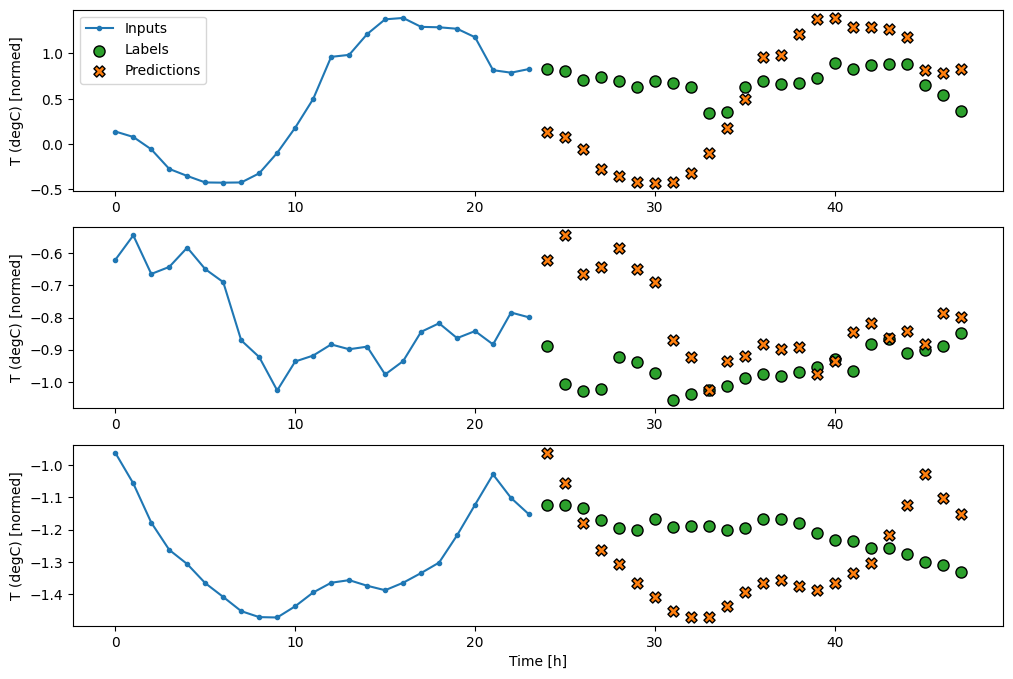

In [79]:
class RepeatBaseline(tf.keras.Model):
  def call(self, inputs):
    return inputs

repeat_baseline = RepeatBaseline()
repeat_baseline.compile(loss=tf.keras.losses.MeanSquaredError(),
                        metrics=[tf.keras.metrics.MeanAbsoluteError()])

multi_val_performance['Repeat'] = repeat_baseline.evaluate(multi_window.val)
multi_performance['Repeat'] = repeat_baseline.evaluate(multi_window.test, verbose=0)
multi_window.plot(repeat_baseline)

### 싱글샷 모델

이 문제에 대한 한 가지 높은 수준의 접근법은 모델이 한 번에 전체 시퀀스 예측을 수행하는 "싱글샷" 모델을 사용하는 것입니다.

이 모델은 `OUT_STEPS*features` 출력 단위를 이용한 `tf.keras.layers.Dense`로 효율적으로 구현할 수 있습니다. 이 모델은 이 출력의 형상을 필요한 `(OUTPUT_STEPS, features)`로 바꾸기만 하면 됩니다.

#### 선형

마지막 입력 타임스텝을 기반으로 하는 단순한 선형 모델은 기준 모델보다 성능이 더 좋지만 강력하지 못합니다. 이 모델은 선형 프로젝션을 이용해 단일 입력 타임스텝으로부터 `OUTPUT_STEPS` 타임스텝을 예측해야 합니다. 주로 하루 중 시간과 연중 시간을 기반으로 하는 행동의 저차원 조각만 캡처할 수 있습니다.

![마지막 타임스텝에서 모든 타임스텝 예측](images/multistep_dense.png)

  1/437 [..............................] - ETA: 28s - loss: 0.2271 - mean_absolute_error: 0.2947

 22/437 [>.............................] - ETA: 0s - loss: 0.2448 - mean_absolute_error: 0.2990 

 44/437 [==>...........................] - ETA: 0s - loss: 0.2507 - mean_absolute_error: 0.3028

 66/437 [===>..........................] - ETA: 0s - loss: 0.2514 - mean_absolute_error: 0.3026

 89/437 [=====>........................] - ETA: 0s - loss: 0.2518 - mean_absolute_error: 0.3029

111/437 [======>.......................] - ETA: 0s - loss: 0.2532 - mean_absolute_error: 0.3035

134/437 [========>.....................] - ETA: 0s - loss: 0.2537 - mean_absolute_error: 0.3037

157/437 [=========>....................] - ETA: 0s - loss: 0.2541 - mean_absolute_error: 0.3041

179/437 [===========>..................] - ETA: 0s - loss: 0.2547 - mean_absolute_error: 0.3043

201/437 [============>.................] - ETA: 0s - loss: 0.2545 - mean_absolute_error: 0.3045

222/437 [==============>...............] - ETA: 0s - loss: 0.2554 - mean_absolute_error: 0.3047

244/437 [===============>..............] - ETA: 0s - loss: 0.2555 - mean_absolute_error: 0.3047

267/437 [=================>............] - ETA: 0s - loss: 0.2550 - mean_absolute_error: 0.3045

289/437 [==================>...........] - ETA: 0s - loss: 0.2551 - mean_absolute_error: 0.3046

312/437 [====================>.........] - ETA: 0s - loss: 0.2556 - mean_absolute_error: 0.3047

334/437 [=====================>........] - ETA: 0s - loss: 0.2550 - mean_absolute_error: 0.3043

357/437 [=======================>......] - ETA: 0s - loss: 0.2554 - mean_absolute_error: 0.3046

379/437 [=========================>....] - ETA: 0s - loss: 0.2552 - mean_absolute_error: 0.3046

402/437 [==========================>...] - ETA: 0s - loss: 0.2556 - mean_absolute_error: 0.3047

425/437 [============================>.] - ETA: 0s - loss: 0.2555 - mean_absolute_error: 0.3048

437/437 [==============================] - 1s 2ms/step - loss: 0.2552 - mean_absolute_error: 0.3047


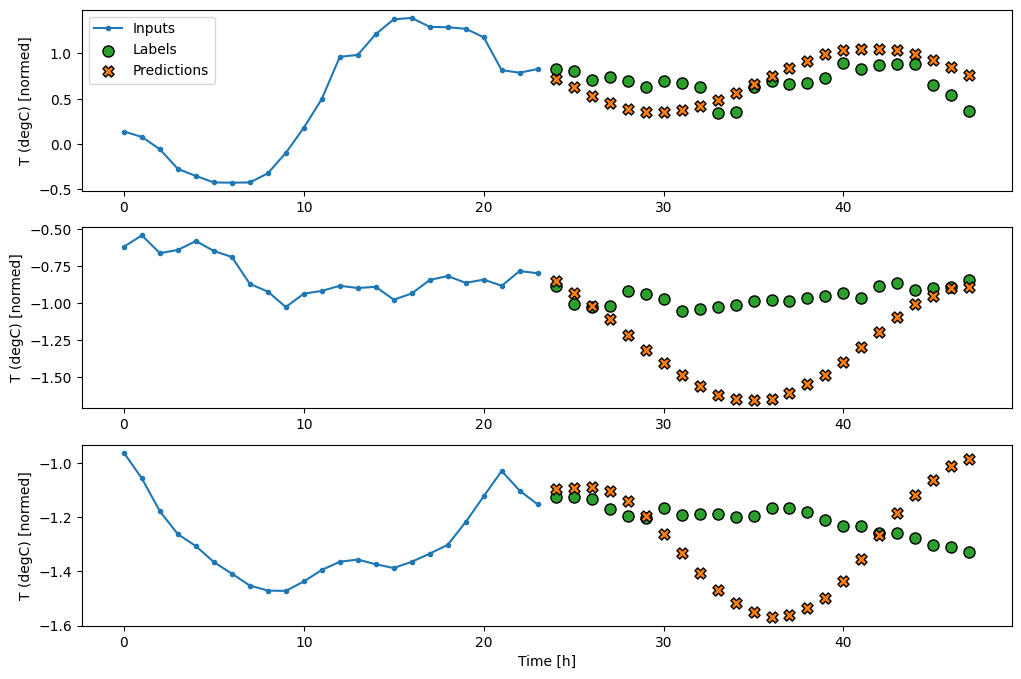

In [80]:
multi_linear_model = tf.keras.Sequential([
    # Take the last time-step.
    # Shape [batch, time, features] => [batch, 1, features]
    tf.keras.layers.Lambda(lambda x: x[:, -1:, :]),
    # Shape => [batch, 1, out_steps*features]
    tf.keras.layers.Dense(OUT_STEPS*num_features,
                          kernel_initializer=tf.initializers.zeros()),
    # Shape => [batch, out_steps, features]
    tf.keras.layers.Reshape([OUT_STEPS, num_features])
])

history = compile_and_fit(multi_linear_model, multi_window)

IPython.display.clear_output()
multi_val_performance['Linear'] = multi_linear_model.evaluate(multi_window.val)
multi_performance['Linear'] = multi_linear_model.evaluate(multi_window.test, verbose=0)
multi_window.plot(multi_linear_model)

#### 밀집

입력과 출력 사이에 `tf.keras.layers.Dense`를 추가하면 선형 모델이 더 강력해지지만 여전히 단일 입력에 기반합니다.

  1/437 [..............................] - ETA: 28s - loss: 0.2352 - mean_absolute_error: 0.2890

 20/437 [>.............................] - ETA: 1s - loss: 0.2332 - mean_absolute_error: 0.2888 

 41/437 [=>............................] - ETA: 1s - loss: 0.2284 - mean_absolute_error: 0.2873

 62/437 [===>..........................] - ETA: 0s - loss: 0.2219 - mean_absolute_error: 0.2838

 82/437 [====>.........................] - ETA: 0s - loss: 0.2240 - mean_absolute_error: 0.2846

103/437 [======>.......................] - ETA: 0s - loss: 0.2227 - mean_absolute_error: 0.2843

124/437 [=======>......................] - ETA: 0s - loss: 0.2225 - mean_absolute_error: 0.2840

146/437 [=========>....................] - ETA: 0s - loss: 0.2222 - mean_absolute_error: 0.2839

168/437 [==========>...................] - ETA: 0s - loss: 0.2219 - mean_absolute_error: 0.2837

190/437 [============>.................] - ETA: 0s - loss: 0.2222 - mean_absolute_error: 0.2840

211/437 [=============>................] - ETA: 0s - loss: 0.2224 - mean_absolute_error: 0.2840

232/437 [==============>...............] - ETA: 0s - loss: 0.2223 - mean_absolute_error: 0.2840

253/437 [================>.............] - ETA: 0s - loss: 0.2232 - mean_absolute_error: 0.2847

275/437 [=================>............] - ETA: 0s - loss: 0.2225 - mean_absolute_error: 0.2844

296/437 [===================>..........] - ETA: 0s - loss: 0.2218 - mean_absolute_error: 0.2839

317/437 [====================>.........] - ETA: 0s - loss: 0.2224 - mean_absolute_error: 0.2842

338/437 [======================>.......] - ETA: 0s - loss: 0.2224 - mean_absolute_error: 0.2841

359/437 [=======================>......] - ETA: 0s - loss: 0.2217 - mean_absolute_error: 0.2838

380/437 [=========================>....] - ETA: 0s - loss: 0.2218 - mean_absolute_error: 0.2838

402/437 [==========================>...] - ETA: 0s - loss: 0.2216 - mean_absolute_error: 0.2837

424/437 [============================>.] - ETA: 0s - loss: 0.2212 - mean_absolute_error: 0.2833

437/437 [==============================] - 1s 2ms/step - loss: 0.2211 - mean_absolute_error: 0.2833


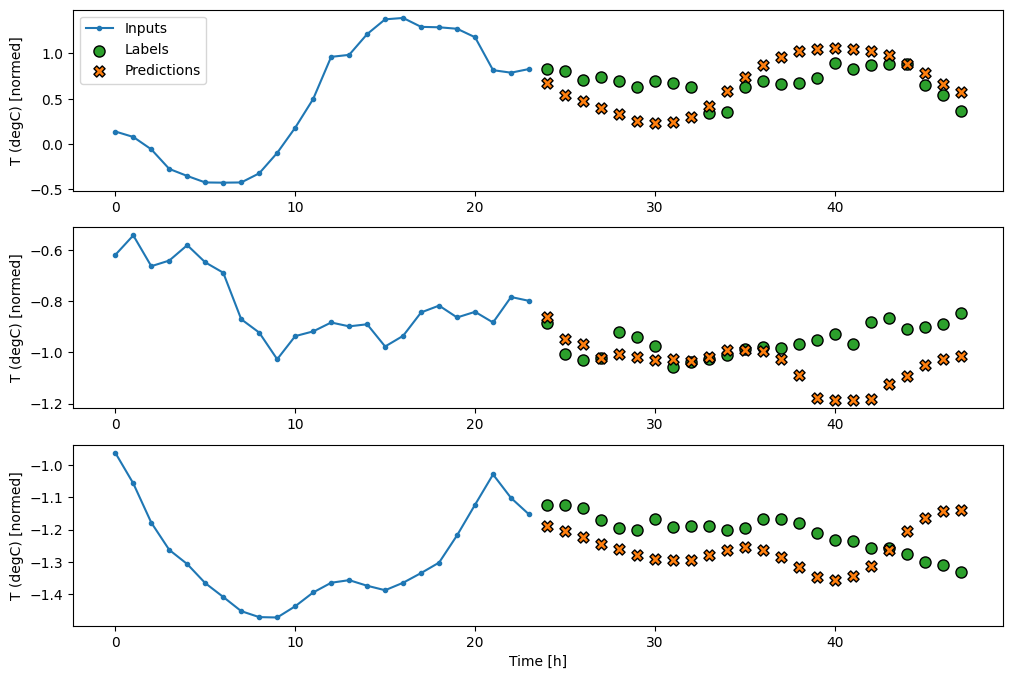

In [81]:
multi_dense_model = tf.keras.Sequential([
    # Take the last time step.
    # Shape [batch, time, features] => [batch, 1, features]
    tf.keras.layers.Lambda(lambda x: x[:, -1:, :]),
    # Shape => [batch, 1, dense_units]
    tf.keras.layers.Dense(512, activation='relu'),
    # Shape => [batch, out_steps*features]
    tf.keras.layers.Dense(OUT_STEPS*num_features,
                          kernel_initializer=tf.initializers.zeros()),
    # Shape => [batch, out_steps, features]
    tf.keras.layers.Reshape([OUT_STEPS, num_features])
])

history = compile_and_fit(multi_dense_model, multi_window)

IPython.display.clear_output()
multi_val_performance['Dense'] = multi_dense_model.evaluate(multi_window.val)
multi_performance['Dense'] = multi_dense_model.evaluate(multi_window.test, verbose=0)
multi_window.plot(multi_dense_model)

#### CNN

컨볼루션 모델은 고정 너비 기록을 기반으로 예측을 수행하므로 시간에 따라 상황이 어떻게 변하는지 볼 수 있어 밀집 모델보다 성능을 높일 수 있습니다.

![컨볼루션 모델은 시간이 지남에 따라 상황이 어떻게 변하는지 확인합니다](images/multistep_conv.png)

  1/437 [..............................] - ETA: 29s - loss: 0.2029 - mean_absolute_error: 0.2695

 21/437 [>.............................] - ETA: 1s - loss: 0.2137 - mean_absolute_error: 0.2792 

 42/437 [=>............................] - ETA: 0s - loss: 0.2136 - mean_absolute_error: 0.2806

 63/437 [===>..........................] - ETA: 0s - loss: 0.2128 - mean_absolute_error: 0.2796

 84/437 [====>.........................] - ETA: 0s - loss: 0.2132 - mean_absolute_error: 0.2802

105/437 [======>.......................] - ETA: 0s - loss: 0.2130 - mean_absolute_error: 0.2796

127/437 [=======>......................] - ETA: 0s - loss: 0.2138 - mean_absolute_error: 0.2796

150/437 [=========>....................] - ETA: 0s - loss: 0.2153 - mean_absolute_error: 0.2806

171/437 [==========>...................] - ETA: 0s - loss: 0.2162 - mean_absolute_error: 0.2813

192/437 [============>.................] - ETA: 0s - loss: 0.2155 - mean_absolute_error: 0.2809

213/437 [=============>................] - ETA: 0s - loss: 0.2147 - mean_absolute_error: 0.2805

234/437 [===============>..............] - ETA: 0s - loss: 0.2146 - mean_absolute_error: 0.2803

255/437 [================>.............] - ETA: 0s - loss: 0.2151 - mean_absolute_error: 0.2806

276/437 [=================>............] - ETA: 0s - loss: 0.2149 - mean_absolute_error: 0.2804

297/437 [===================>..........] - ETA: 0s - loss: 0.2145 - mean_absolute_error: 0.2801

318/437 [====================>.........] - ETA: 0s - loss: 0.2139 - mean_absolute_error: 0.2797

339/437 [======================>.......] - ETA: 0s - loss: 0.2142 - mean_absolute_error: 0.2799

360/437 [=======================>......] - ETA: 0s - loss: 0.2138 - mean_absolute_error: 0.2798

382/437 [=========================>....] - ETA: 0s - loss: 0.2137 - mean_absolute_error: 0.2797

403/437 [==========================>...] - ETA: 0s - loss: 0.2135 - mean_absolute_error: 0.2795

425/437 [============================>.] - ETA: 0s - loss: 0.2132 - mean_absolute_error: 0.2793

437/437 [==============================] - 1s 2ms/step - loss: 0.2134 - mean_absolute_error: 0.2795


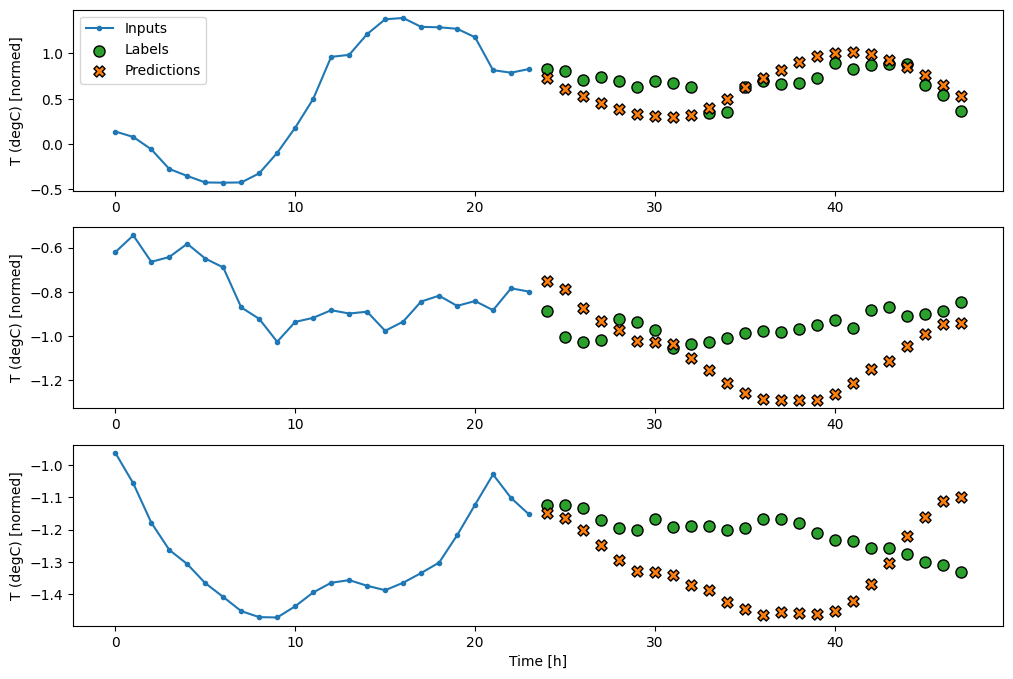

In [82]:
CONV_WIDTH = 3
multi_conv_model = tf.keras.Sequential([
    # Shape [batch, time, features] => [batch, CONV_WIDTH, features]
    tf.keras.layers.Lambda(lambda x: x[:, -CONV_WIDTH:, :]),
    # Shape => [batch, 1, conv_units]
    tf.keras.layers.Conv1D(256, activation='relu', kernel_size=(CONV_WIDTH)),
    # Shape => [batch, 1,  out_steps*features]
    tf.keras.layers.Dense(OUT_STEPS*num_features,
                          kernel_initializer=tf.initializers.zeros()),
    # Shape => [batch, out_steps, features]
    tf.keras.layers.Reshape([OUT_STEPS, num_features])
])

history = compile_and_fit(multi_conv_model, multi_window)

IPython.display.clear_output()

multi_val_performance['Conv'] = multi_conv_model.evaluate(multi_window.val)
multi_performance['Conv'] = multi_conv_model.evaluate(multi_window.test, verbose=0)
multi_window.plot(multi_conv_model)

#### RNN

반복 모델은 모델이 수행하는 예측과 관련이 있는 경우 긴 입력 기록을 사용하는 방법을 학습할 수 있습니다. 여기서 모델은 다음 24시간에 대한 단일 예측을 수행하기 전에 24시간 동안 내부 상태를 축적합니다.

이 싱글샷 형식에서 LSTM은 마지막 타임스텝에서만 출력을 생성하면 되므로 `tf.keras.layers.LSTM`에서 `return_sequences=False`를 설정합니다.

![lstm은 입력 창에 대한 상태를 누적하고 다음 24시간 동안 단일 예측을 수행합니다](https://github.com/tensorflow/docs-l10n/blob/master/site/ko/tutorials/structured_data/images/multistep_lstm.png?raw=true)


  1/437 [..............................] - ETA: 29s - loss: 0.2182 - mean_absolute_error: 0.2789

 18/437 [>.............................] - ETA: 1s - loss: 0.2232 - mean_absolute_error: 0.2881 

 36/437 [=>............................] - ETA: 1s - loss: 0.2270 - mean_absolute_error: 0.2891

 55/437 [==>...........................] - ETA: 1s - loss: 0.2201 - mean_absolute_error: 0.2860

 74/437 [====>.........................] - ETA: 1s - loss: 0.2170 - mean_absolute_error: 0.2846

 93/437 [=====>........................] - ETA: 0s - loss: 0.2150 - mean_absolute_error: 0.2837

112/437 [======>.......................] - ETA: 0s - loss: 0.2134 - mean_absolute_error: 0.2827

131/437 [=======>......................] - ETA: 0s - loss: 0.2135 - mean_absolute_error: 0.2829

149/437 [=========>....................] - ETA: 0s - loss: 0.2140 - mean_absolute_error: 0.2832

167/437 [==========>...................] - ETA: 0s - loss: 0.2136 - mean_absolute_error: 0.2829

185/437 [===========>..................] - ETA: 0s - loss: 0.2134 - mean_absolute_error: 0.2827

203/437 [============>.................] - ETA: 0s - loss: 0.2135 - mean_absolute_error: 0.2831

222/437 [==============>...............] - ETA: 0s - loss: 0.2128 - mean_absolute_error: 0.2827

240/437 [===============>..............] - ETA: 0s - loss: 0.2123 - mean_absolute_error: 0.2824

258/437 [================>.............] - ETA: 0s - loss: 0.2128 - mean_absolute_error: 0.2827

277/437 [==================>...........] - ETA: 0s - loss: 0.2133 - mean_absolute_error: 0.2829

295/437 [===================>..........] - ETA: 0s - loss: 0.2132 - mean_absolute_error: 0.2828

313/437 [====================>.........] - ETA: 0s - loss: 0.2130 - mean_absolute_error: 0.2827

331/437 [=====================>........] - ETA: 0s - loss: 0.2129 - mean_absolute_error: 0.2827

349/437 [======================>.......] - ETA: 0s - loss: 0.2128 - mean_absolute_error: 0.2827

367/437 [========================>.....] - ETA: 0s - loss: 0.2133 - mean_absolute_error: 0.2829

385/437 [=========================>....] - ETA: 0s - loss: 0.2132 - mean_absolute_error: 0.2829

403/437 [==========================>...] - ETA: 0s - loss: 0.2136 - mean_absolute_error: 0.2831

421/437 [===========================>..] - ETA: 0s - loss: 0.2140 - mean_absolute_error: 0.2834

437/437 [==============================] - 1s 3ms/step - loss: 0.2137 - mean_absolute_error: 0.2833


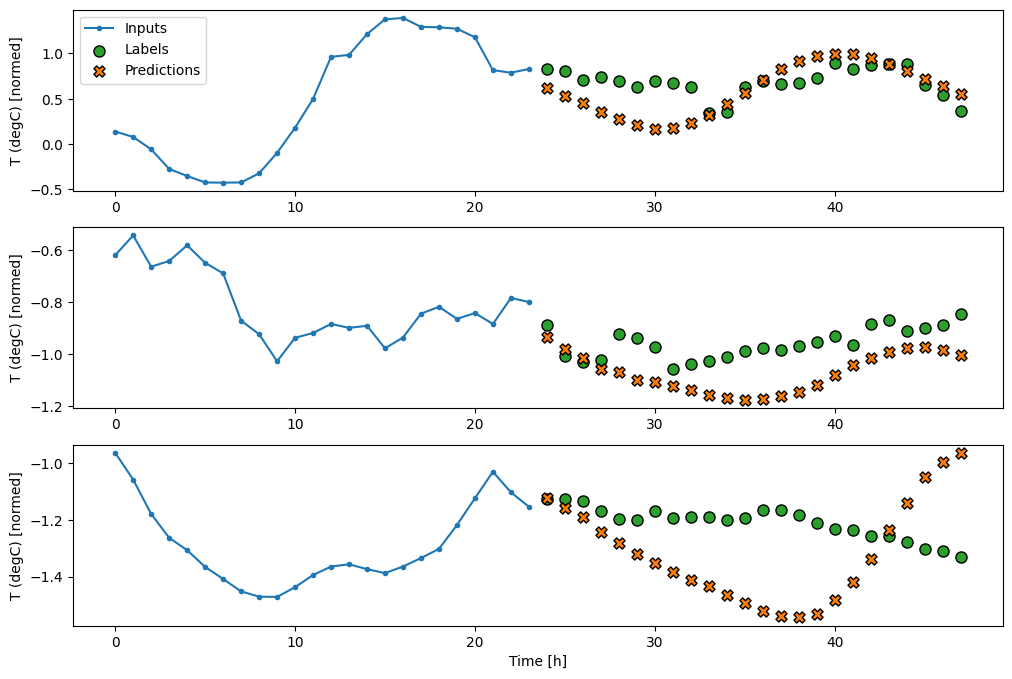

In [83]:
multi_lstm_model = tf.keras.Sequential([
    # Shape [batch, time, features] => [batch, lstm_units].
    # Adding more `lstm_units` just overfits more quickly.
    tf.keras.layers.LSTM(32, return_sequences=False),
    # Shape => [batch, out_steps*features].
    tf.keras.layers.Dense(OUT_STEPS*num_features,
                          kernel_initializer=tf.initializers.zeros()),
    # Shape => [batch, out_steps, features].
    tf.keras.layers.Reshape([OUT_STEPS, num_features])
])

history = compile_and_fit(multi_lstm_model, multi_window)

IPython.display.clear_output()

multi_val_performance['LSTM'] = multi_lstm_model.evaluate(multi_window.val)
multi_performance['LSTM'] = multi_lstm_model.evaluate(multi_window.test, verbose=0)
multi_window.plot(multi_lstm_model)

### 고급: 자기 회귀 모델

위의 모델은 모두 한 번에 전체 출력 시퀀스를 예측합니다.

경우에 따라 모델이 이 예측을 여러 타임스텝으로 분해하는 것이 도움이 될 수 있습니다. 그러면 이전의 <a href="https://arxiv.org/abs/1308.0850" class="external">RNN(Recurrent Neural Networks)을 이용한 시퀀스 생성</a>에서와 같이 각 모델의 출력을 각 스텝에서 자체 피드백할 수 있어 이전 예측을 조건부로 예측을 수행할 수 있습니다.

이 형태의 모델이 갖는 한 가지 분명한 장점은 다양한 길이의 출력을 생성하도록 설정할 수 있다는 것입니다.

이 튜토리얼의 전반부에서 훈련한 단일 스텝 다중 출력 모델 중 하나를 가져와 자기 회귀 피드백 루프에서 실행할 수 있지만 여기서는 이를 수행하도록 명시적으로 훈련된 모델을 빌드하는 데 중점을 둘 것입니다.

![모델의 출력을 입력으로 피드백](images/multistep_autoregressive.png)

#### RNN

이 튜토리얼에서는 자기 회귀 RNN 모델만 빌드하지만 이 패턴은 단일 타임스텝을 출력하도록 설계된 모든 모델에 적용할 수 있습니다.

이 모델은 앞의 단일 스텝 LSTM 모델과 기본 형태가 동일하여 `tf.keras.layers.LSTM` 레이어 다음에 `LSTM` 레이어 출력을 모델 예측으로 변환하는 `tf.keras.layers.Dense` 레이어가 이어집니다.

`tf.keras.layers.LSTM`은 상태와 시퀀스 결과를 자동으로 관리하는 더 높은 수준의 `tf.keras.layers.RNN`에서 래핑된 `tf.keras.layers.LSTMCell`입니다(자세한 내용은 [Keras를 사용한 순환 신경망(RNN)](https://www.tensorflow.org/guide/keras/rnn) 가이드 참조).

이 경우 모델은 각 스텝에 대한 입력을 수동으로 관리해야 하므로 더 낮은 수준의 단일 타임스텝 인터페이스에 대해 `tf.keras.layers.LSTMCell`를 직접 사용합니다.

In [84]:
class FeedBack(tf.keras.Model):
  def __init__(self, units, out_steps):
    super().__init__()
    self.out_steps = out_steps
    self.units = units
    self.lstm_cell = tf.keras.layers.LSTMCell(units)
    # Also wrap the LSTMCell in an RNN to simplify the `warmup` method.
    self.lstm_rnn = tf.keras.layers.RNN(self.lstm_cell, return_state=True)
    self.dense = tf.keras.layers.Dense(num_features)

In [85]:
feedback_model = FeedBack(units=32, out_steps=OUT_STEPS)

이 모델에 필요한 첫 번째 메서드는 입력을 기반으로 내부 상태를 초기화하는 `warmup` 메서드입니다. 일단 훈련되면 이 상태는 입력 기록의 관련 부분을 캡처합니다. 이는 앞서 알아본 단일 스탭 `LSTM` 모델과 동일합니다.

In [86]:
def warmup(self, inputs):
  # inputs.shape => (batch, time, features)
  # x.shape => (batch, lstm_units)
  x, *state = self.lstm_rnn(inputs)

  # predictions.shape => (batch, features)
  prediction = self.dense(x)
  return prediction, state

FeedBack.warmup = warmup

이 메서드는 단일 타임스텝 예측과 `LSTM`의 내부 상태를 반환합니다.

In [87]:
prediction, state = feedback_model.warmup(multi_window.example[0])
prediction.shape

TensorShape([32, 19])

`RNN`의 상태 및 초기 예측을 사용하여 이제 이전의 각 스텝에서 수행한 예측을 입력으로 제공하여 모델을 계속 반복할 수 있습니다.

출력 예측을 수집하는 가장 간단한 방법은 Python 목록을 사용하고 루프 후에 `tf.stack`을 사용하는 것입니다.

참고: 이와 같은 Python 목록 스태킹은 훈련을 위해 `Model.compile(..., run_eagerly=True)`를 사용하거나 고정 길이의 출력을 통해 즉시 실행하는 경우에만 효과가 있습니다. 동적 출력 길이의 경우 Python 목록 대신 `tf.TensorArray`를 사용하고 Python `range` 대신 `tf.range`를 사용해야 합니다.

In [88]:
def call(self, inputs, training=None):
  # Use a TensorArray to capture dynamically unrolled outputs.
  predictions = []
  # Initialize the LSTM state.
  prediction, state = self.warmup(inputs)

  # Insert the first prediction.
  predictions.append(prediction)

  # Run the rest of the prediction steps.
  for n in range(1, self.out_steps):
    # Use the last prediction as input.
    x = prediction
    # Execute one lstm step.
    x, state = self.lstm_cell(x, states=state,
                              training=training)
    # Convert the lstm output to a prediction.
    prediction = self.dense(x)
    # Add the prediction to the output.
    predictions.append(prediction)

  # predictions.shape => (time, batch, features)
  predictions = tf.stack(predictions)
  # predictions.shape => (batch, time, features)
  predictions = tf.transpose(predictions, [1, 0, 2])
  return predictions

FeedBack.call = call

예제 입력에서 이 모델을 테스트 실행합니다.

In [89]:
print('Output shape (batch, time, features): ', feedback_model(multi_window.example[0]).shape)

Output shape (batch, time, features):  (32, 24, 19)


이제 모델을 훈련합니다.

  1/437 [..............................] - ETA: 31s - loss: 0.2013 - mean_absolute_error: 0.2902

  7/437 [..............................] - ETA: 3s - loss: 0.2147 - mean_absolute_error: 0.2943 

 14/437 [..............................] - ETA: 3s - loss: 0.2142 - mean_absolute_error: 0.2929

 21/437 [>.............................] - ETA: 3s - loss: 0.2205 - mean_absolute_error: 0.2978

 28/437 [>.............................] - ETA: 3s - loss: 0.2284 - mean_absolute_error: 0.3033

 35/437 [=>............................] - ETA: 3s - loss: 0.2280 - mean_absolute_error: 0.3036

 42/437 [=>............................] - ETA: 3s - loss: 0.2252 - mean_absolute_error: 0.3018

 49/437 [==>...........................] - ETA: 3s - loss: 0.2272 - mean_absolute_error: 0.3028

 56/437 [==>...........................] - ETA: 2s - loss: 0.2254 - mean_absolute_error: 0.3021

 63/437 [===>..........................] - ETA: 2s - loss: 0.2227 - mean_absolute_error: 0.3009

 70/437 [===>..........................] - ETA: 2s - loss: 0.2243 - mean_absolute_error: 0.3020

 77/437 [====>.........................] - ETA: 2s - loss: 0.2246 - mean_absolute_error: 0.3020

 84/437 [====>.........................] - ETA: 2s - loss: 0.2250 - mean_absolute_error: 0.3023

 91/437 [=====>........................] - ETA: 2s - loss: 0.2266 - mean_absolute_error: 0.3033

 98/437 [=====>........................] - ETA: 2s - loss: 0.2277 - mean_absolute_error: 0.3043

105/437 [======>.......................] - ETA: 2s - loss: 0.2280 - mean_absolute_error: 0.3045

112/437 [======>.......................] - ETA: 2s - loss: 0.2275 - mean_absolute_error: 0.3044

119/437 [=======>......................] - ETA: 2s - loss: 0.2275 - mean_absolute_error: 0.3043

126/437 [=======>......................] - ETA: 2s - loss: 0.2267 - mean_absolute_error: 0.3038

133/437 [========>.....................] - ETA: 2s - loss: 0.2267 - mean_absolute_error: 0.3041

140/437 [========>.....................] - ETA: 2s - loss: 0.2267 - mean_absolute_error: 0.3039

147/437 [=========>....................] - ETA: 2s - loss: 0.2266 - mean_absolute_error: 0.3042

154/437 [=========>....................] - ETA: 2s - loss: 0.2265 - mean_absolute_error: 0.3040

161/437 [==========>...................] - ETA: 2s - loss: 0.2255 - mean_absolute_error: 0.3034

168/437 [==========>...................] - ETA: 2s - loss: 0.2253 - mean_absolute_error: 0.3033

175/437 [===========>..................] - ETA: 1s - loss: 0.2244 - mean_absolute_error: 0.3028

182/437 [===========>..................] - ETA: 1s - loss: 0.2242 - mean_absolute_error: 0.3027

189/437 [===========>..................] - ETA: 1s - loss: 0.2242 - mean_absolute_error: 0.3028

196/437 [============>.................] - ETA: 1s - loss: 0.2238 - mean_absolute_error: 0.3025

203/437 [============>.................] - ETA: 1s - loss: 0.2240 - mean_absolute_error: 0.3025

210/437 [=============>................] - ETA: 1s - loss: 0.2241 - mean_absolute_error: 0.3025

217/437 [=============>................] - ETA: 1s - loss: 0.2242 - mean_absolute_error: 0.3027

224/437 [==============>...............] - ETA: 1s - loss: 0.2240 - mean_absolute_error: 0.3025

231/437 [==============>...............] - ETA: 1s - loss: 0.2250 - mean_absolute_error: 0.3031

238/437 [===============>..............] - ETA: 1s - loss: 0.2253 - mean_absolute_error: 0.3033

245/437 [===============>..............] - ETA: 1s - loss: 0.2253 - mean_absolute_error: 0.3032

252/437 [================>.............] - ETA: 1s - loss: 0.2260 - mean_absolute_error: 0.3036

259/437 [================>.............] - ETA: 1s - loss: 0.2255 - mean_absolute_error: 0.3033

266/437 [=================>............] - ETA: 1s - loss: 0.2256 - mean_absolute_error: 0.3034

273/437 [=================>............] - ETA: 1s - loss: 0.2255 - mean_absolute_error: 0.3033

280/437 [==================>...........] - ETA: 1s - loss: 0.2258 - mean_absolute_error: 0.3035

287/437 [==================>...........] - ETA: 1s - loss: 0.2257 - mean_absolute_error: 0.3035

294/437 [===================>..........] - ETA: 1s - loss: 0.2258 - mean_absolute_error: 0.3035

301/437 [===================>..........] - ETA: 1s - loss: 0.2256 - mean_absolute_error: 0.3035

308/437 [====================>.........] - ETA: 0s - loss: 0.2252 - mean_absolute_error: 0.3032

315/437 [====================>.........] - ETA: 0s - loss: 0.2252 - mean_absolute_error: 0.3032

322/437 [=====================>........] - ETA: 0s - loss: 0.2253 - mean_absolute_error: 0.3033

329/437 [=====================>........] - ETA: 0s - loss: 0.2255 - mean_absolute_error: 0.3034

336/437 [======================>.......] - ETA: 0s - loss: 0.2256 - mean_absolute_error: 0.3034

343/437 [======================>.......] - ETA: 0s - loss: 0.2257 - mean_absolute_error: 0.3035

350/437 [=======================>......] - ETA: 0s - loss: 0.2258 - mean_absolute_error: 0.3035

357/437 [=======================>......] - ETA: 0s - loss: 0.2258 - mean_absolute_error: 0.3034

364/437 [=======================>......] - ETA: 0s - loss: 0.2256 - mean_absolute_error: 0.3033

371/437 [========================>.....] - ETA: 0s - loss: 0.2256 - mean_absolute_error: 0.3033

378/437 [========================>.....] - ETA: 0s - loss: 0.2257 - mean_absolute_error: 0.3033

385/437 [=========================>....] - ETA: 0s - loss: 0.2257 - mean_absolute_error: 0.3033

392/437 [=========================>....] - ETA: 0s - loss: 0.2257 - mean_absolute_error: 0.3033

399/437 [==========================>...] - ETA: 0s - loss: 0.2255 - mean_absolute_error: 0.3030

406/437 [==========================>...] - ETA: 0s - loss: 0.2254 - mean_absolute_error: 0.3029

413/437 [===========================>..] - ETA: 0s - loss: 0.2253 - mean_absolute_error: 0.3029

420/437 [===========================>..] - ETA: 0s - loss: 0.2251 - mean_absolute_error: 0.3027

427/437 [============================>.] - ETA: 0s - loss: 0.2250 - mean_absolute_error: 0.3026

435/437 [============================>.] - ETA: 0s - loss: 0.2252 - mean_absolute_error: 0.3027

437/437 [==============================] - 3s 7ms/step - loss: 0.2251 - mean_absolute_error: 0.3027


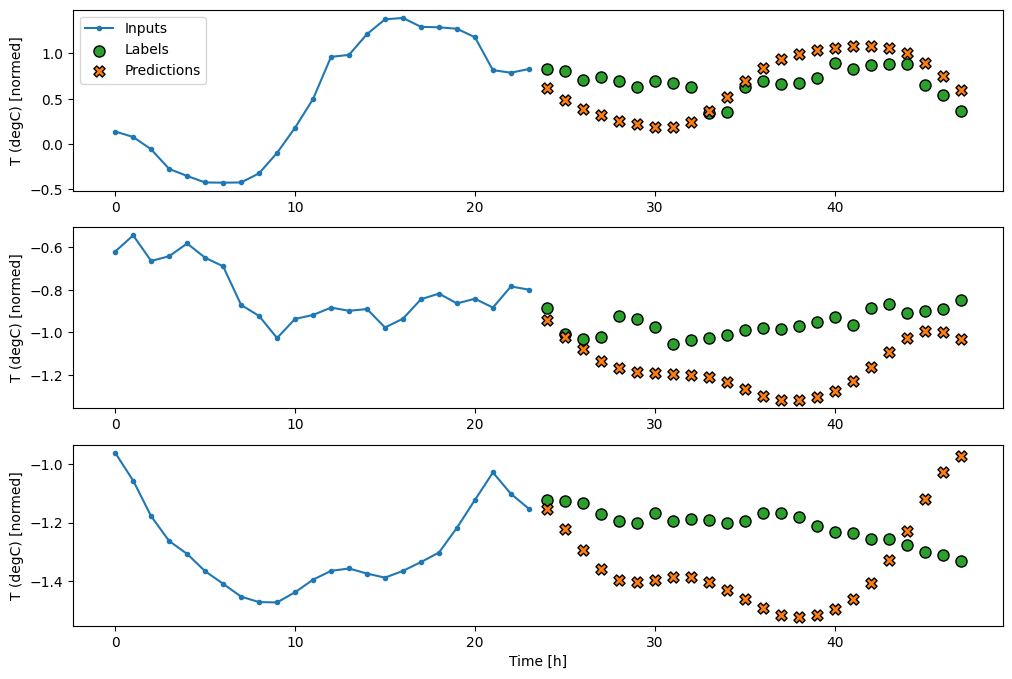

In [90]:
history = compile_and_fit(feedback_model, multi_window)

IPython.display.clear_output()

multi_val_performance['AR LSTM'] = feedback_model.evaluate(multi_window.val)
multi_performance['AR LSTM'] = feedback_model.evaluate(multi_window.test, verbose=0)
multi_window.plot(feedback_model)

### 성능

이 문제에 대해 모델 복잡성이 증가함에 따라 분명히 이득이 감소합니다.

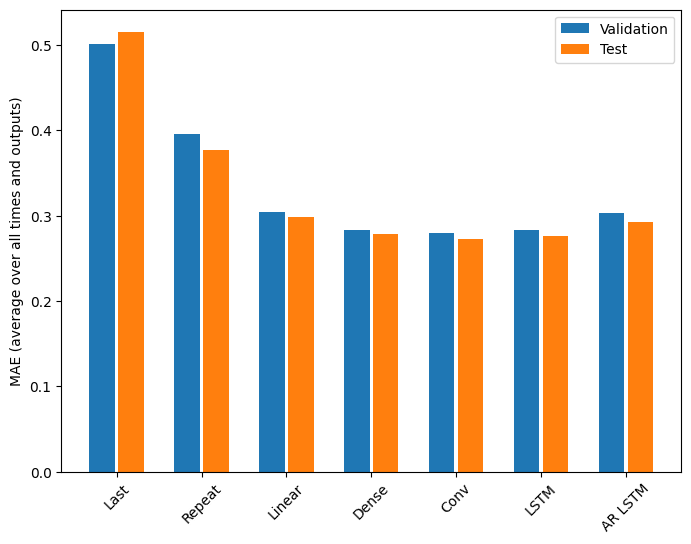

In [91]:
x = np.arange(len(multi_performance))
width = 0.3

metric_name = 'mean_absolute_error'
metric_index = lstm_model.metrics_names.index('mean_absolute_error')
val_mae = [v[metric_index] for v in multi_val_performance.values()]
test_mae = [v[metric_index] for v in multi_performance.values()]

plt.bar(x - 0.17, val_mae, width, label='Validation')
plt.bar(x + 0.17, test_mae, width, label='Test')
plt.xticks(ticks=x, labels=multi_performance.keys(),
           rotation=45)
plt.ylabel(f'MAE (average over all times and outputs)')
_ = plt.legend()

이 튜토리얼의 전반부에서 소개한 다중 출력 모델에 대한 메트릭은 모든 출력 특성에 평균화된 성능을 보여줍니다. 이러한 성능은 유사하지만 출력 타임스텝에 걸쳐서도 평균화됩니다. 

In [92]:
for name, value in multi_performance.items():
  print(f'{name:8s}: {value[1]:0.4f}')

Last    : 0.5157
Repeat  : 0.3774
Linear  : 0.2981
Dense   : 0.2784
Conv    : 0.2726
LSTM    : 0.2759
AR LSTM : 0.2920


밀집 모델에서 컨볼루션 및 반복 모델로 이동하여 얻은 이득은 몇 퍼센트(있다고 하더라도)에 불과하며 자기 회귀 모델의 성능은 분명히 더 나빴습니다. 따라서 이러한 더 복잡한 접근 방법은 **이** 문제에서는 가치가 없을 수도 있지만 시도해 보기 전에는 알 수 있는 방법이 없었으며 이러한 모델은 **다른 특정** 문제에 도움이 될 수 있습니다.

## 다음 단계

이 튜토리얼에서는 TensorFlow를 사용한 시계열 예측에 대해 간단히 소개했습니다.

자세한 내용은 다음을 참조하세요.

- <a href="https://www.oreilly.com/library/view/hands-on-machine-learning/9781492032632/" class="external">Scikit-Learn, Keras 및 TensorFlow를 이용한 머신러닝 실무</a>(2차 개정 버전), 챕터 15
- [Python을 이용한 딥러닝](https://www.manning.com/books/deep-learning-with-python) 챕터 6
- <a href="https://www.udacity.com/course/intro-to-tensorflow-for-deep-learning--ud187" class="external">Udacity의 딥러닝을 위한 TensorFlow 소개</a>(<a href="https://github.com/tensorflow/examples/tree/master/courses/udacity_intro_to_tensorflow_for_deep_learning" class="external">연습 노트북</a> 포함)의 레슨 8.

또한 TensorFlow에서 어떤 <a href="https://otexts.com/fpp2/index.html" class="external">클래식 시계열 모델</a>이든 구현할 수 있다는 점을 기억하세요. 이 튜토리얼에서는 TensdorFlow의 내장 기능에 초점을 맞추었습니다.
